**Exploratory Data Analysis**

É importante mencionar que os dados foram transformados pelo Faker para garantir sigilo do cliente. Contudo, toda a abordagem feita é real e utilizada constantemente. Não farei insisghts por tratarem-se de dados falsos, no entanto, aproveitem o código.

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import researchpy as rp
import warnings
import sweetviz # an extra and fast option
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings("ignore")
warnings.filterwarnings(action = "ignore", category=DeprecationWarning)
from plotnine import ggplot, aes, geom_boxplot, labs
import plotnine as pn

In [170]:
data = pd.read_csv('sample_df.csv')

In [169]:
half_df = data.sample(frac=0.5, random_state=42)
half_df.to_csv('sample_df.csv')

In [172]:
print("Amostra dos dados:")
display(data.head(3))

Amostra dos dados:


Unnamed: 0  codigo_liberacao_venda              periodo  uf  \
0       92497              1280800704  2022-09-08 13:28:22  SP   
1       82766              2705392202  2022-06-05 12:33:10  RJ   
2       48452              7089734345  2022-02-07 16:18:51  RJ   

           cidade             status_venda   loja departamento       rede  \
0       SAO PAULO  Confirmada Parcialmente  Loja4     ALIMENTO  Empresa A   
1  RIO DE JANEIRO               Confirmada  Loja2     ALIMENTO  Empresa B   
2  RIO DE JANEIRO               Confirmada  Loja2     ALIMENTO  Empresa A   

   cd_conveniada  ...  qtde_produto valor_bruto_venda valor_liquido_venda  \
0          28625  ...             4              7339                8159   
1          99055  ...             3              4973                7343   
2          76809  ...             5              8238                4928   

   preco_produto_vendido preco_produto mes   ano  ano_mes  dia_da_semana  \
0                   1234         1.990   9  2022  2022-09       Thursday   
1                   7762         2.090   6  2022  2022-06         Sunday   
2                    754         5.690   2  2022  2022-02         Monday   

   Desconto  
0       NaN  
1       NaN  
2    40.180  

[3 rows x 28 columns]

`PRE-PROCESSAMENTO`

Criação de algumas variáveis relacionadas a data para dar suporte às analises

In [173]:
data['periodo'] = pd.to_datetime(data['periodo'])
data['mes'] = data['periodo'].dt.month
data['ano'] = data['periodo'].dt.year
data['ano_mes'] = data['periodo'].dt.strftime('%Y-%m')
data['dia_da_semana'] = data['periodo'].dt.day_name()

Verificando o intervalo de datas

In [174]:
print('Menor data nos dados')
display(data.periodo.min())
print('')
print('Maior data nos dados')
display(data.periodo.max())

Menor data nos dados


Timestamp('2022-01-01 02:34:33')


Maior data nos dados


Timestamp('2023-12-31 22:29:26')

Nesse caso específico, o cliente queria entender sobre o impacto do Desconto em várias áreas do negócio e aqui vai uma dica: não fique restrito aos dados "originais". Uma vez feita a análise, busque entender mais a fundo usando algumas vezes de recursos simples com esse do Desconto.

Criar a variável `Desconto`

In [175]:
data = data.assign(Desconto=((data['valor_bruto_venda'] - data['valor_liquido_venda']) / data['valor_bruto_venda']) * 100)

Verificar dados nulos

In [176]:
tabela_nulos = (
    pd.concat([data.isnull().sum(), (data.isnull().sum() / len(data) * 100).round(1)], axis=1)
    .rename(columns={0: 'Valores nulos', 1: '% do Total'})
    .loc[lambda x: x['% do Total'] != 0]
    .sort_values('% do Total', ascending=False)
)

print('Presença de dados nulos:')
display(tabela_nulos)

Presença de dados nulos:


Valores nulos  % do Total
classe_terapeutica          82012      96.500
cpf                          3659       4.300

**Análise Descritiva**

*Variáveis numéricas*

(é importante lembrar que os números foram substituídos pelo Faker também e logo podem não fazer sentido. Contudo, aproveitem o código pois essa é a ideia)

In [177]:
print('Principais medidas de tendência central (colunas numéricas)')
display(data[['Desconto','qtde_produto', 'valor_bruto_venda', 'valor_liquido_venda','preco_produto_vendido', 'preco_produto']].describe(percentiles=[0,.25,.50,.75,.80,.85,.90,.95,.99]))

Principais medidas de tendência central (colunas numéricas)


Desconto  qtde_produto  valor_bruto_venda  valor_liquido_venda  \
count 85023.000     85023.000          85023.000            85023.000   
mean       -inf         4.610          39779.342           137453.512   
std         NaN         4.670         134352.343          3273300.097   
min        -inf         0.000              0.000                0.000   
0%          NaN         0.000              0.000                0.000   
25%    -108.585         2.000           3697.500             3685.000   
50%      -0.519         5.000           7654.000             7593.000   
75%      51.114         7.000          38708.000            38456.000   
80%      61.543         8.000          52918.000            53450.000   
85%      71.740         8.000          67330.600            68104.300   
90%      81.668         9.000          81252.400            83052.800   
95%      91.226         9.000          95365.900            97456.000   
99%      98.388         9.000         731691.840           869373.300   
max     100.000       836.000        9889651.000        704744831.000   

       preco_produto_vendido  preco_produto  
count              85023.000      85023.000  
mean       3223124872201.476         20.953  
std      143089412685605.875         29.133  
min                    0.000          1.290  
0%                     0.000          1.290  
25%                 3572.000          2.990  
50%                 7199.000          5.090  
75%                28056.000         38.690  
80%                44034.200         44.990  
85%                60063.800         51.490  
90%                76299.800         63.690  
95%                92567.800         75.190  
99%               726005.700        129.990  
max     9710075544574806.000        299.990

In [178]:
top_10_products = data.groupby(['produto'], as_index=False)['qtde_produto'].sum().nlargest(10, 'qtde_produto')
describe_top_10_products = data[data['produto'].isin(top_10_products['produto'])].groupby('produto')['qtde_produto'].describe(percentiles=[0,.25,.50,.75,.80,.85,.90,.95,.99])

print("Estatística Descritiva Top 10 Produtos:")
display(describe_top_10_products.sort_values(by='count',ascending=False))

Estatística Descritiva Top 10 Produtos:


count  mean   std   min    0%   25%   50%   75%   80%   85%  \
produto                                                                    
Produto8  8654.000 4.629 3.780 0.000 0.000 2.000 5.000 7.000 8.000 8.000   
Produto5  8589.000 4.565 3.531 0.000 0.000 2.000 4.000 7.000 7.000 8.000   
Produto1  8557.000 4.723 9.615 0.000 0.000 2.000 5.000 7.000 8.000 8.000   
Produto2  8514.000 4.590 3.644 0.000 0.000 2.000 5.000 7.000 8.000 8.000   
Produto10 8506.000 4.654 4.004 0.000 0.000 2.000 5.000 7.000 8.000 8.000   
Produto4  8476.000 4.602 3.977 0.000 0.000 2.000 4.000 7.000 7.000 8.000   
Produto9  8470.000 4.580 3.498 0.000 0.000 2.000 4.000 7.000 8.000 8.000   
Produto7  8438.000 4.573 3.855 0.000 0.000 2.000 4.000 7.000 8.000 8.000   
Produto3  8415.000 4.654 3.874 0.000 0.000 2.000 5.000 7.000 8.000 8.000   
Produto6  8404.000 4.528 3.335 0.000 0.000 2.000 4.000 7.000 7.000 8.000   

            90%   95%   99%     max  
produto                              
Produto8  9.000 9.000 9.000  88.000  
Produto5  9.000 9.000 9.000  97.000  
Produto1  9.000 9.000 9.000 836.000  
Produto2  8.000 9.000 9.000  99.000  
Produto10 9.000 9.000 9.000  98.000  
Produto4  9.000 9.000 9.000  95.000  
Produto9  9.000 9.000 9.000  91.000  
Produto7  8.000 9.000 9.000  99.000  
Produto3  9.000 9.000 9.000  97.000  
Produto6  9.000 9.000 9.000  89.000

QUANTIDADE DE PRODUTO

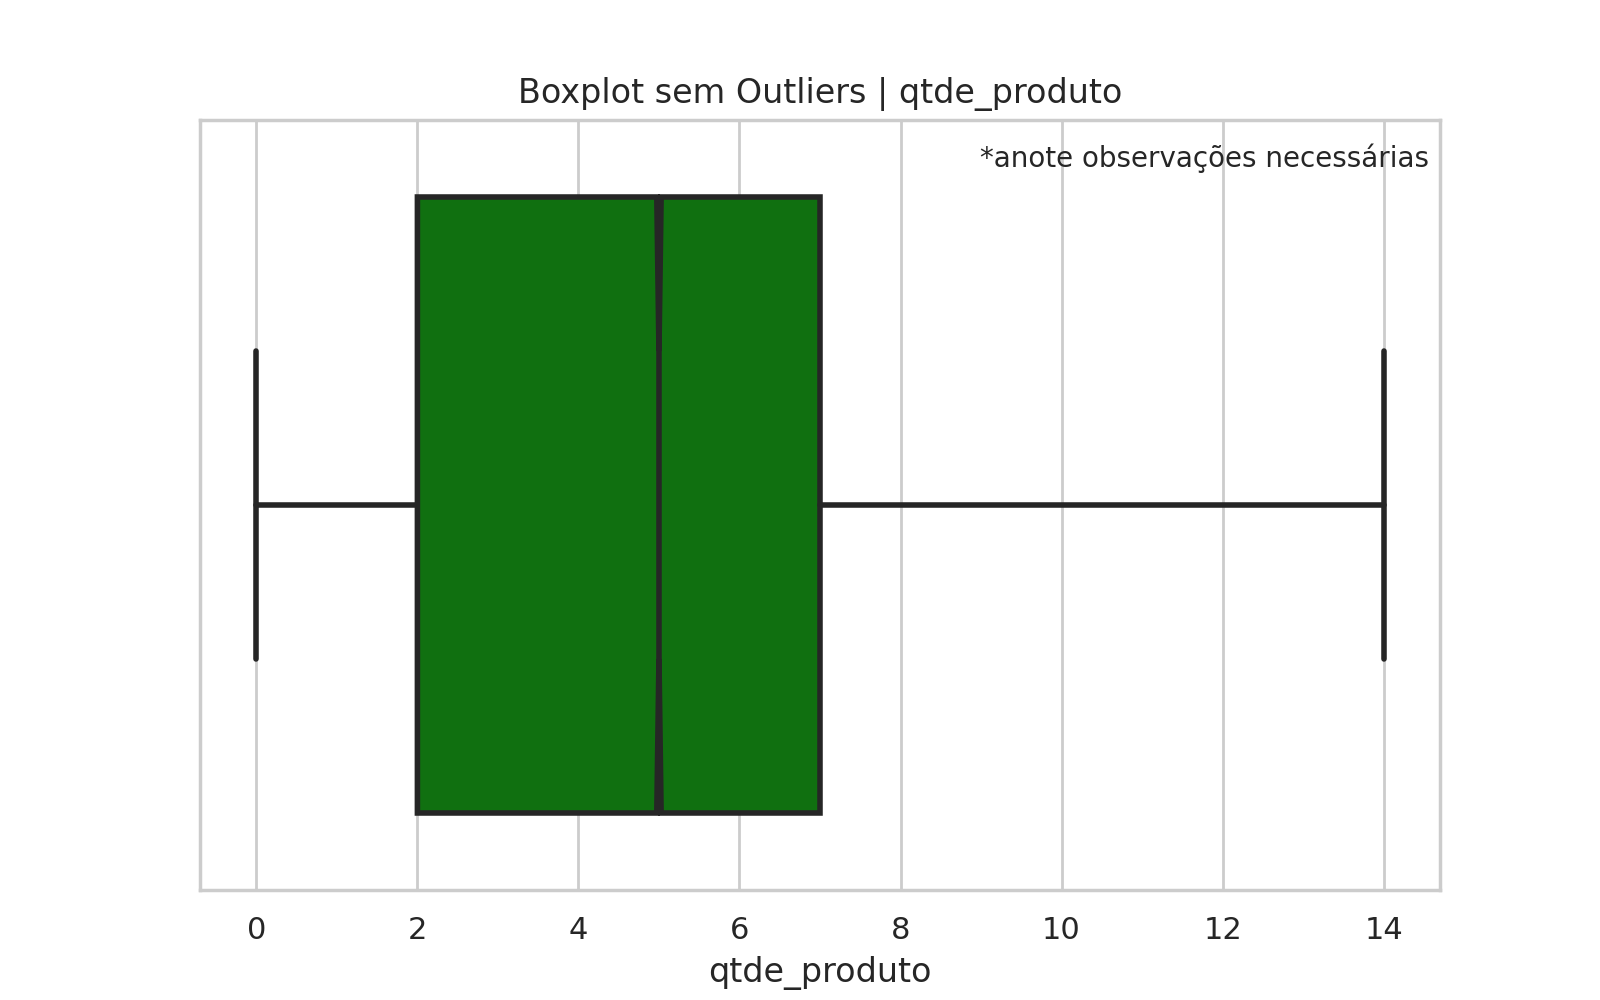

In [179]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='qtde_produto', data=data, color='green', showfliers=False, linewidth=2, notch=True)
plt.title('Boxplot sem Outliers | qtde_produto')
plt.text(0.81, 0.95, '*anote observações necessárias', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)
plt.show()

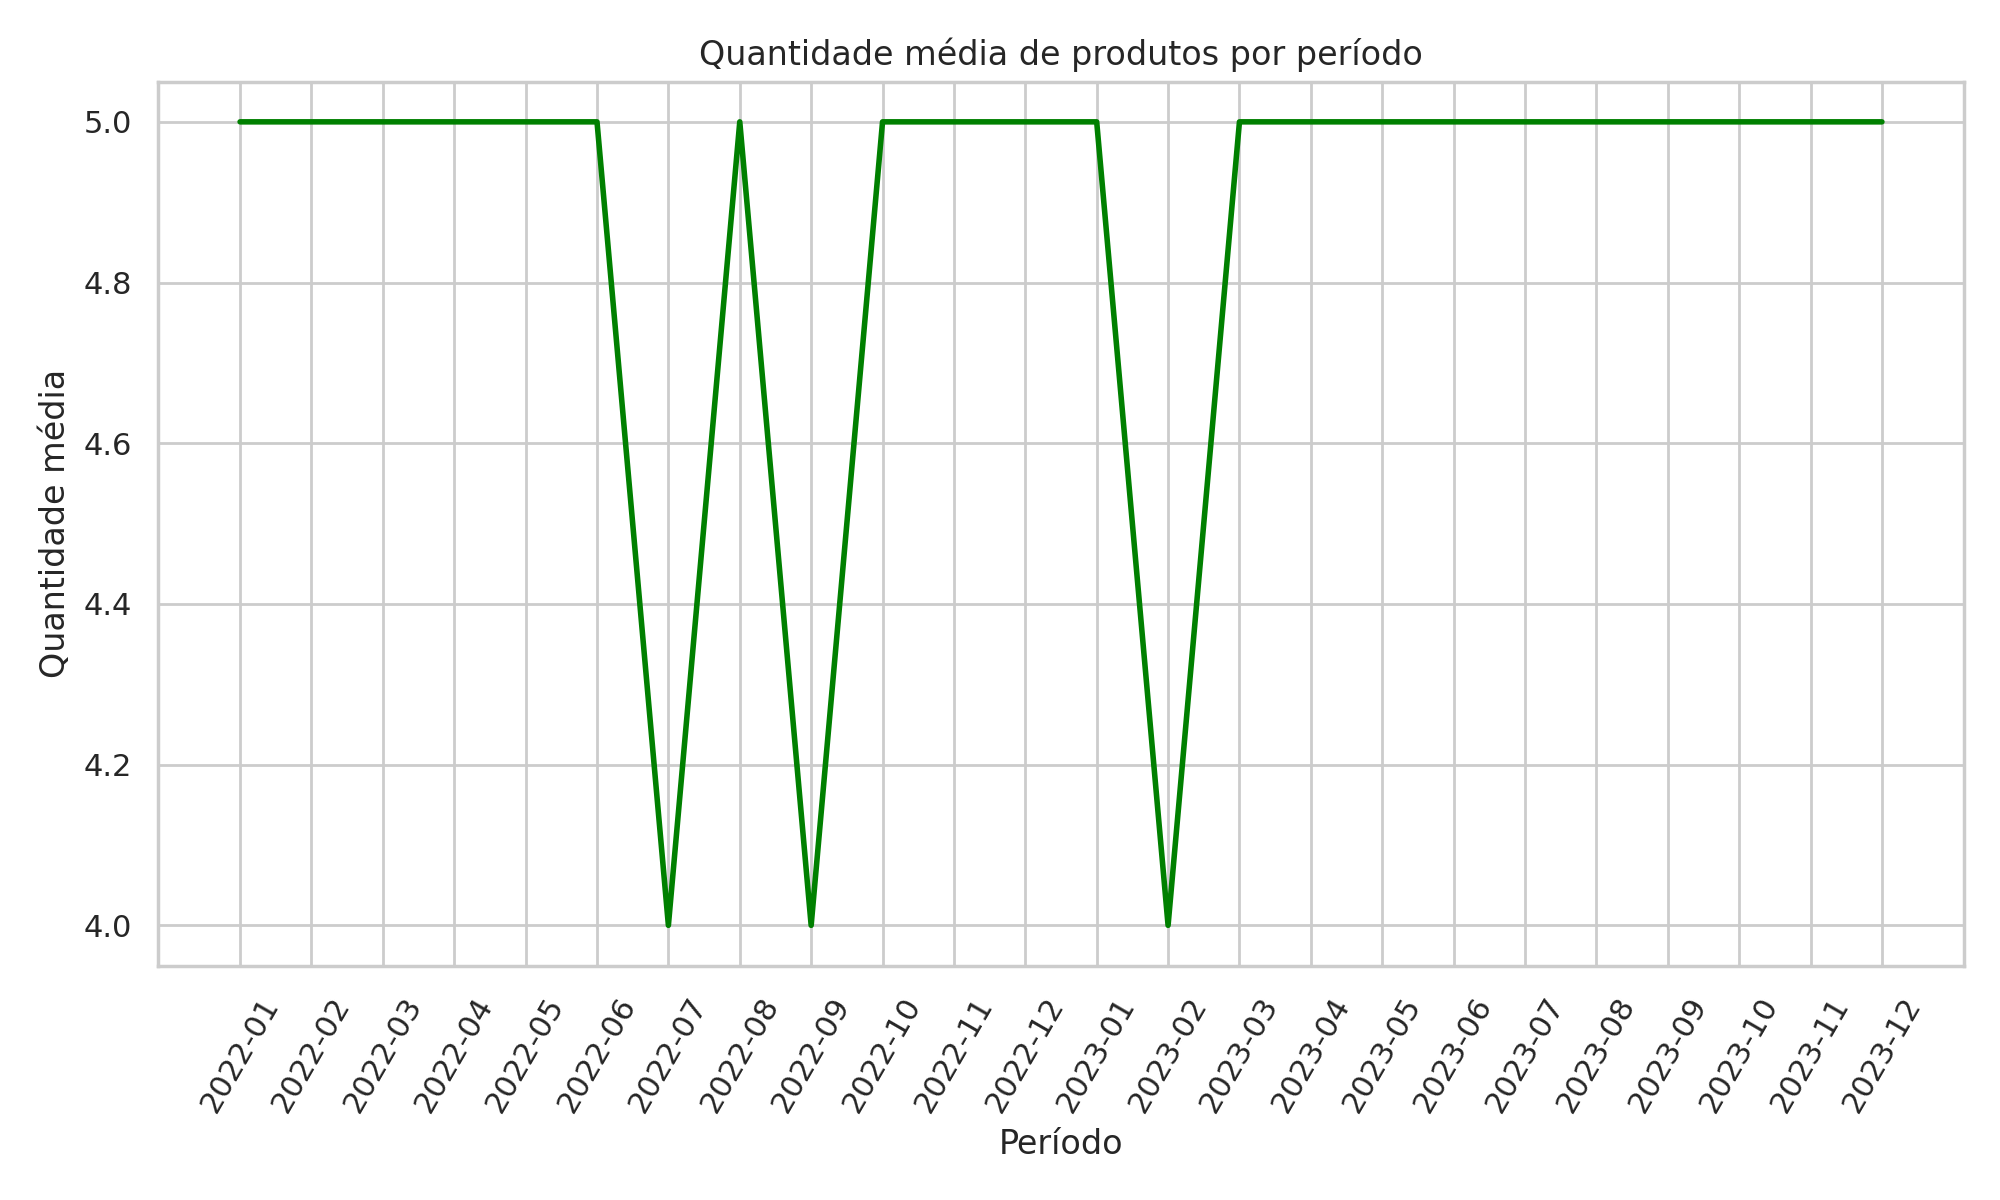

In [180]:
yearly_monthly_mean = data.groupby(['ano_mes'])['qtde_produto'].mean().round().reset_index()

# Set seaborn style
sns.set(style="whitegrid")

# Plotting line plot for mean quantity of products per year-month with a transparent background
plt.figure(figsize=(10, 6))
sns.lineplot(x='ano_mes', y='qtde_produto', data=yearly_monthly_mean, color='green', linewidth=2)
plt.title('Quantidade média de produtos por período')
plt.xlabel('Período')
plt.ylabel('Quantidade média')
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()

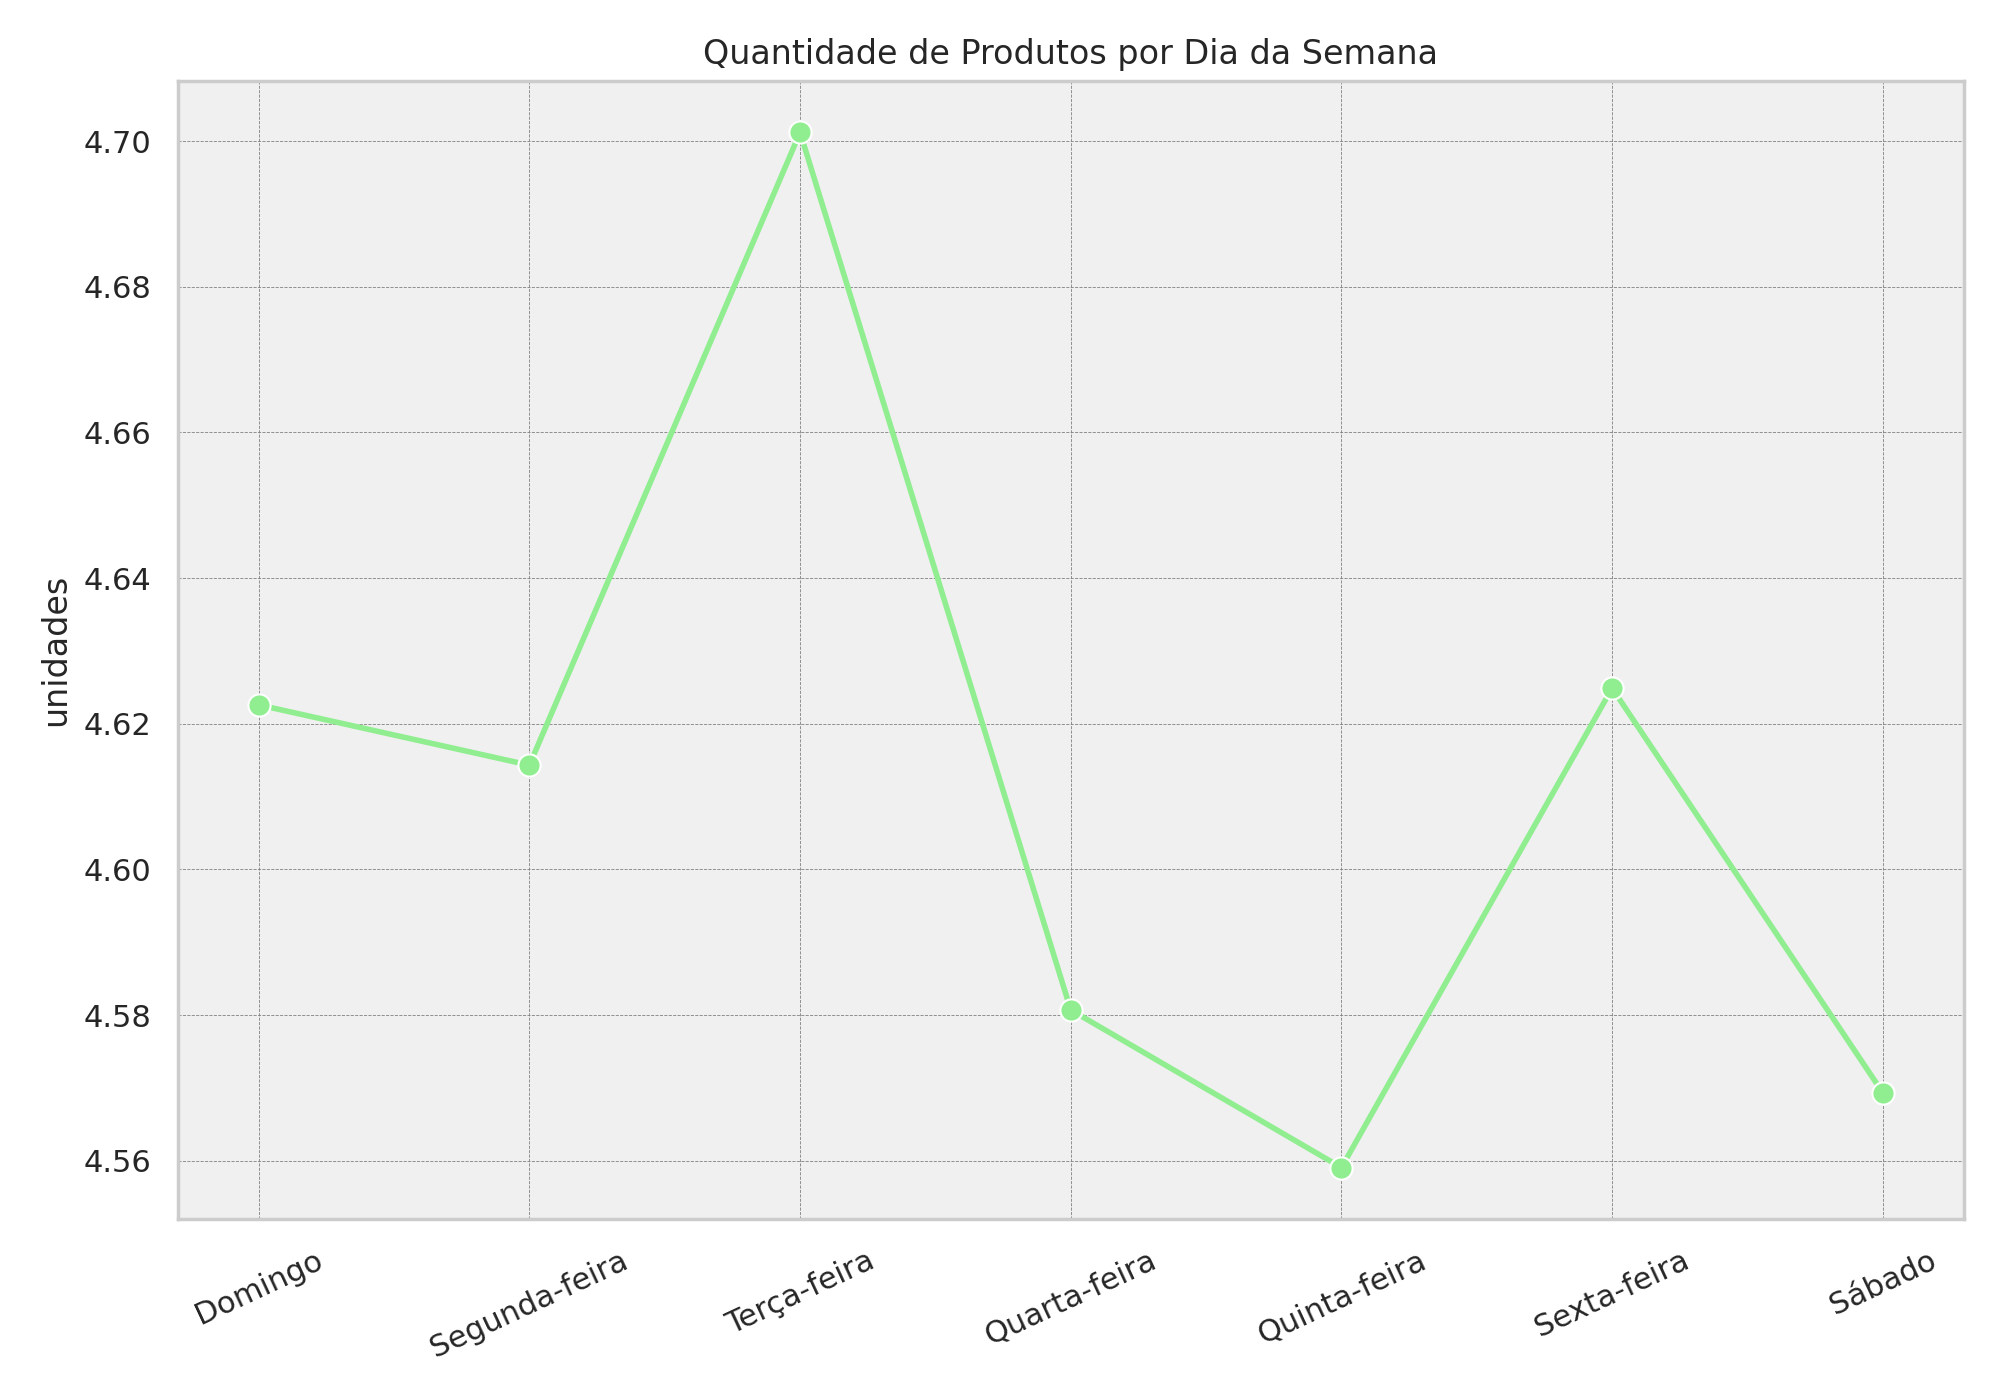

In [181]:
sns.set(style="whitegrid")

weekday_mean = data.groupby(['dia_da_semana'])['qtde_produto'].mean().to_frame().reset_index()

custom_order = ['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado']

plt.figure(figsize=(10, 7))
sns.lineplot(x='dia_da_semana', y='qtde_produto', data=weekday_mean, color='lightgreen', marker='o', markersize=8, linewidth=2)
plt.xlabel('')
plt.ylabel('unidades')
plt.title('Quantidade de Produtos por Dia da Semana')
plt.gca().set_facecolor('#F0F0F0')
plt.grid(color='gray', linestyle='--', linewidth=0.3)

plt.xticks(range(len(custom_order)), custom_order, rotation=25)

plt.tight_layout()
plt.show()

VALOR BRUTO DA VENDA

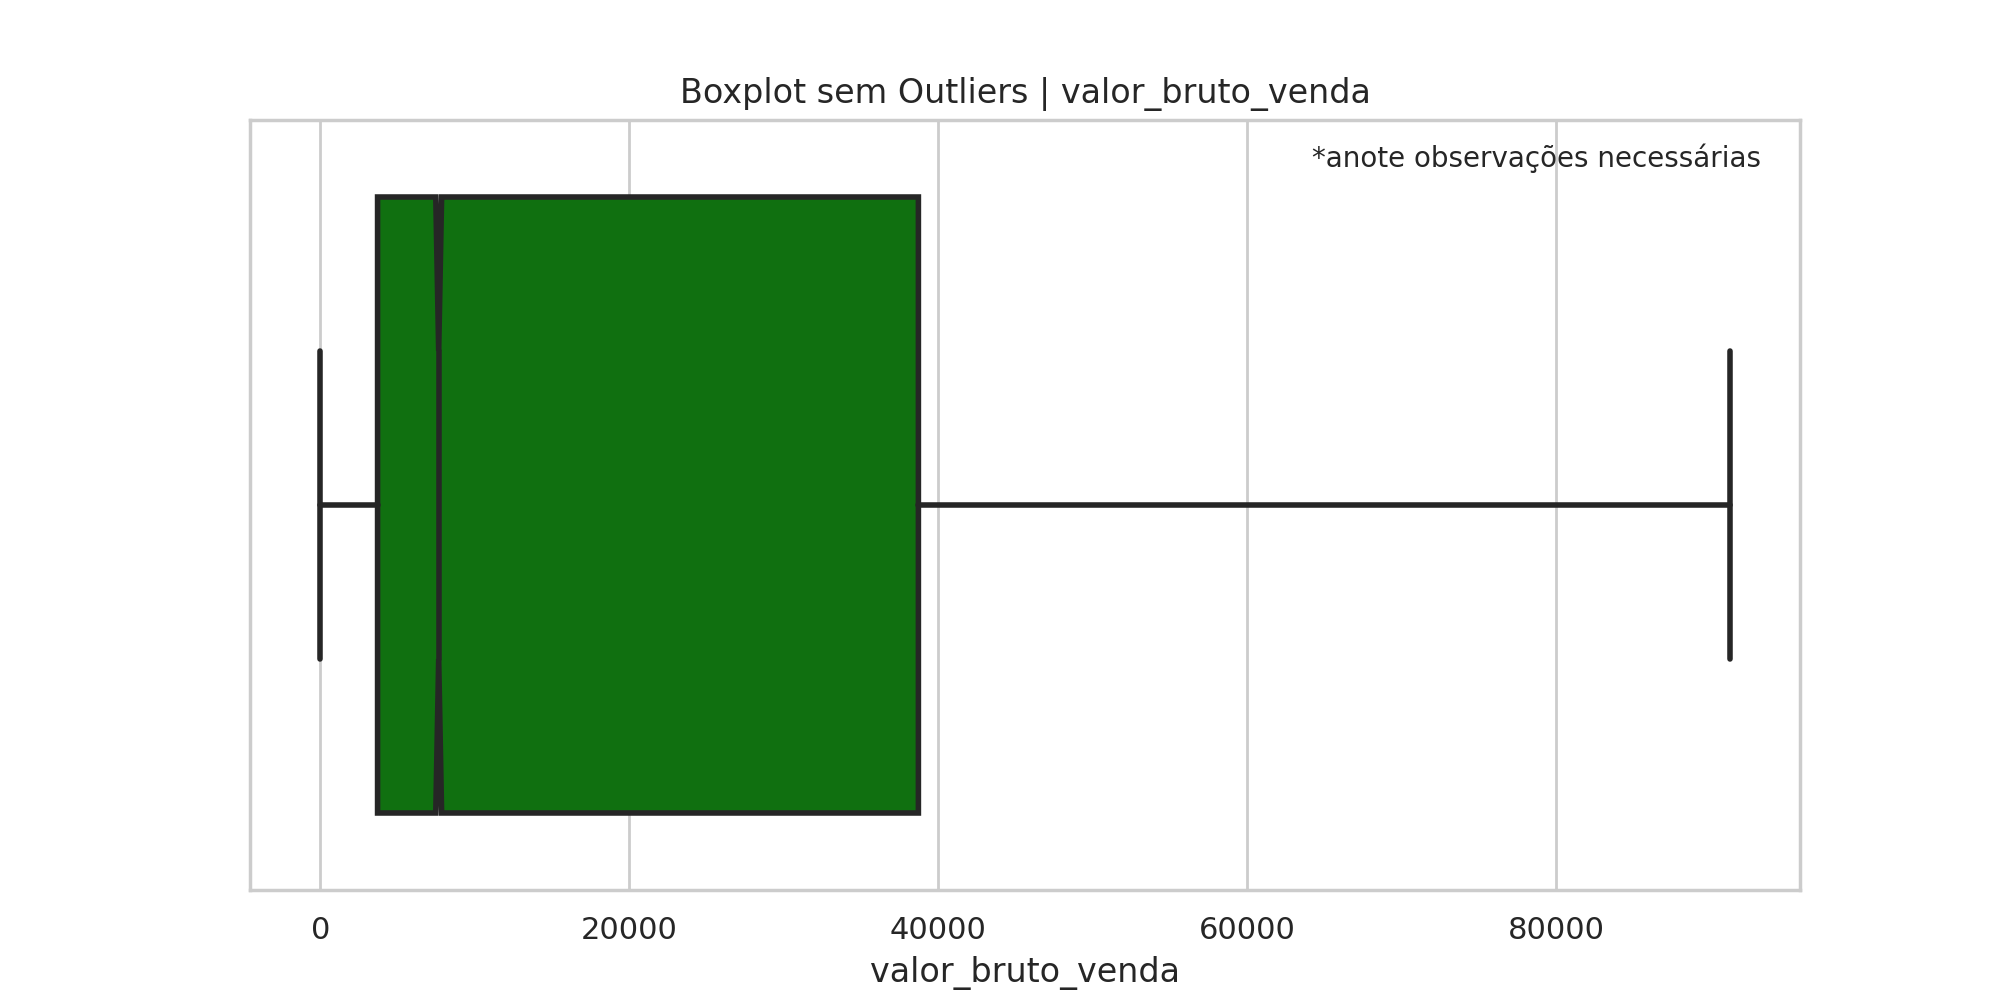

In [182]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='valor_bruto_venda', data=data, color='green', showfliers=False, linewidth=2, notch=True)
plt.title('Boxplot sem Outliers | valor_bruto_venda')
plt.text(0.83, 0.95, '*anote observações necessárias', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)
plt.show()

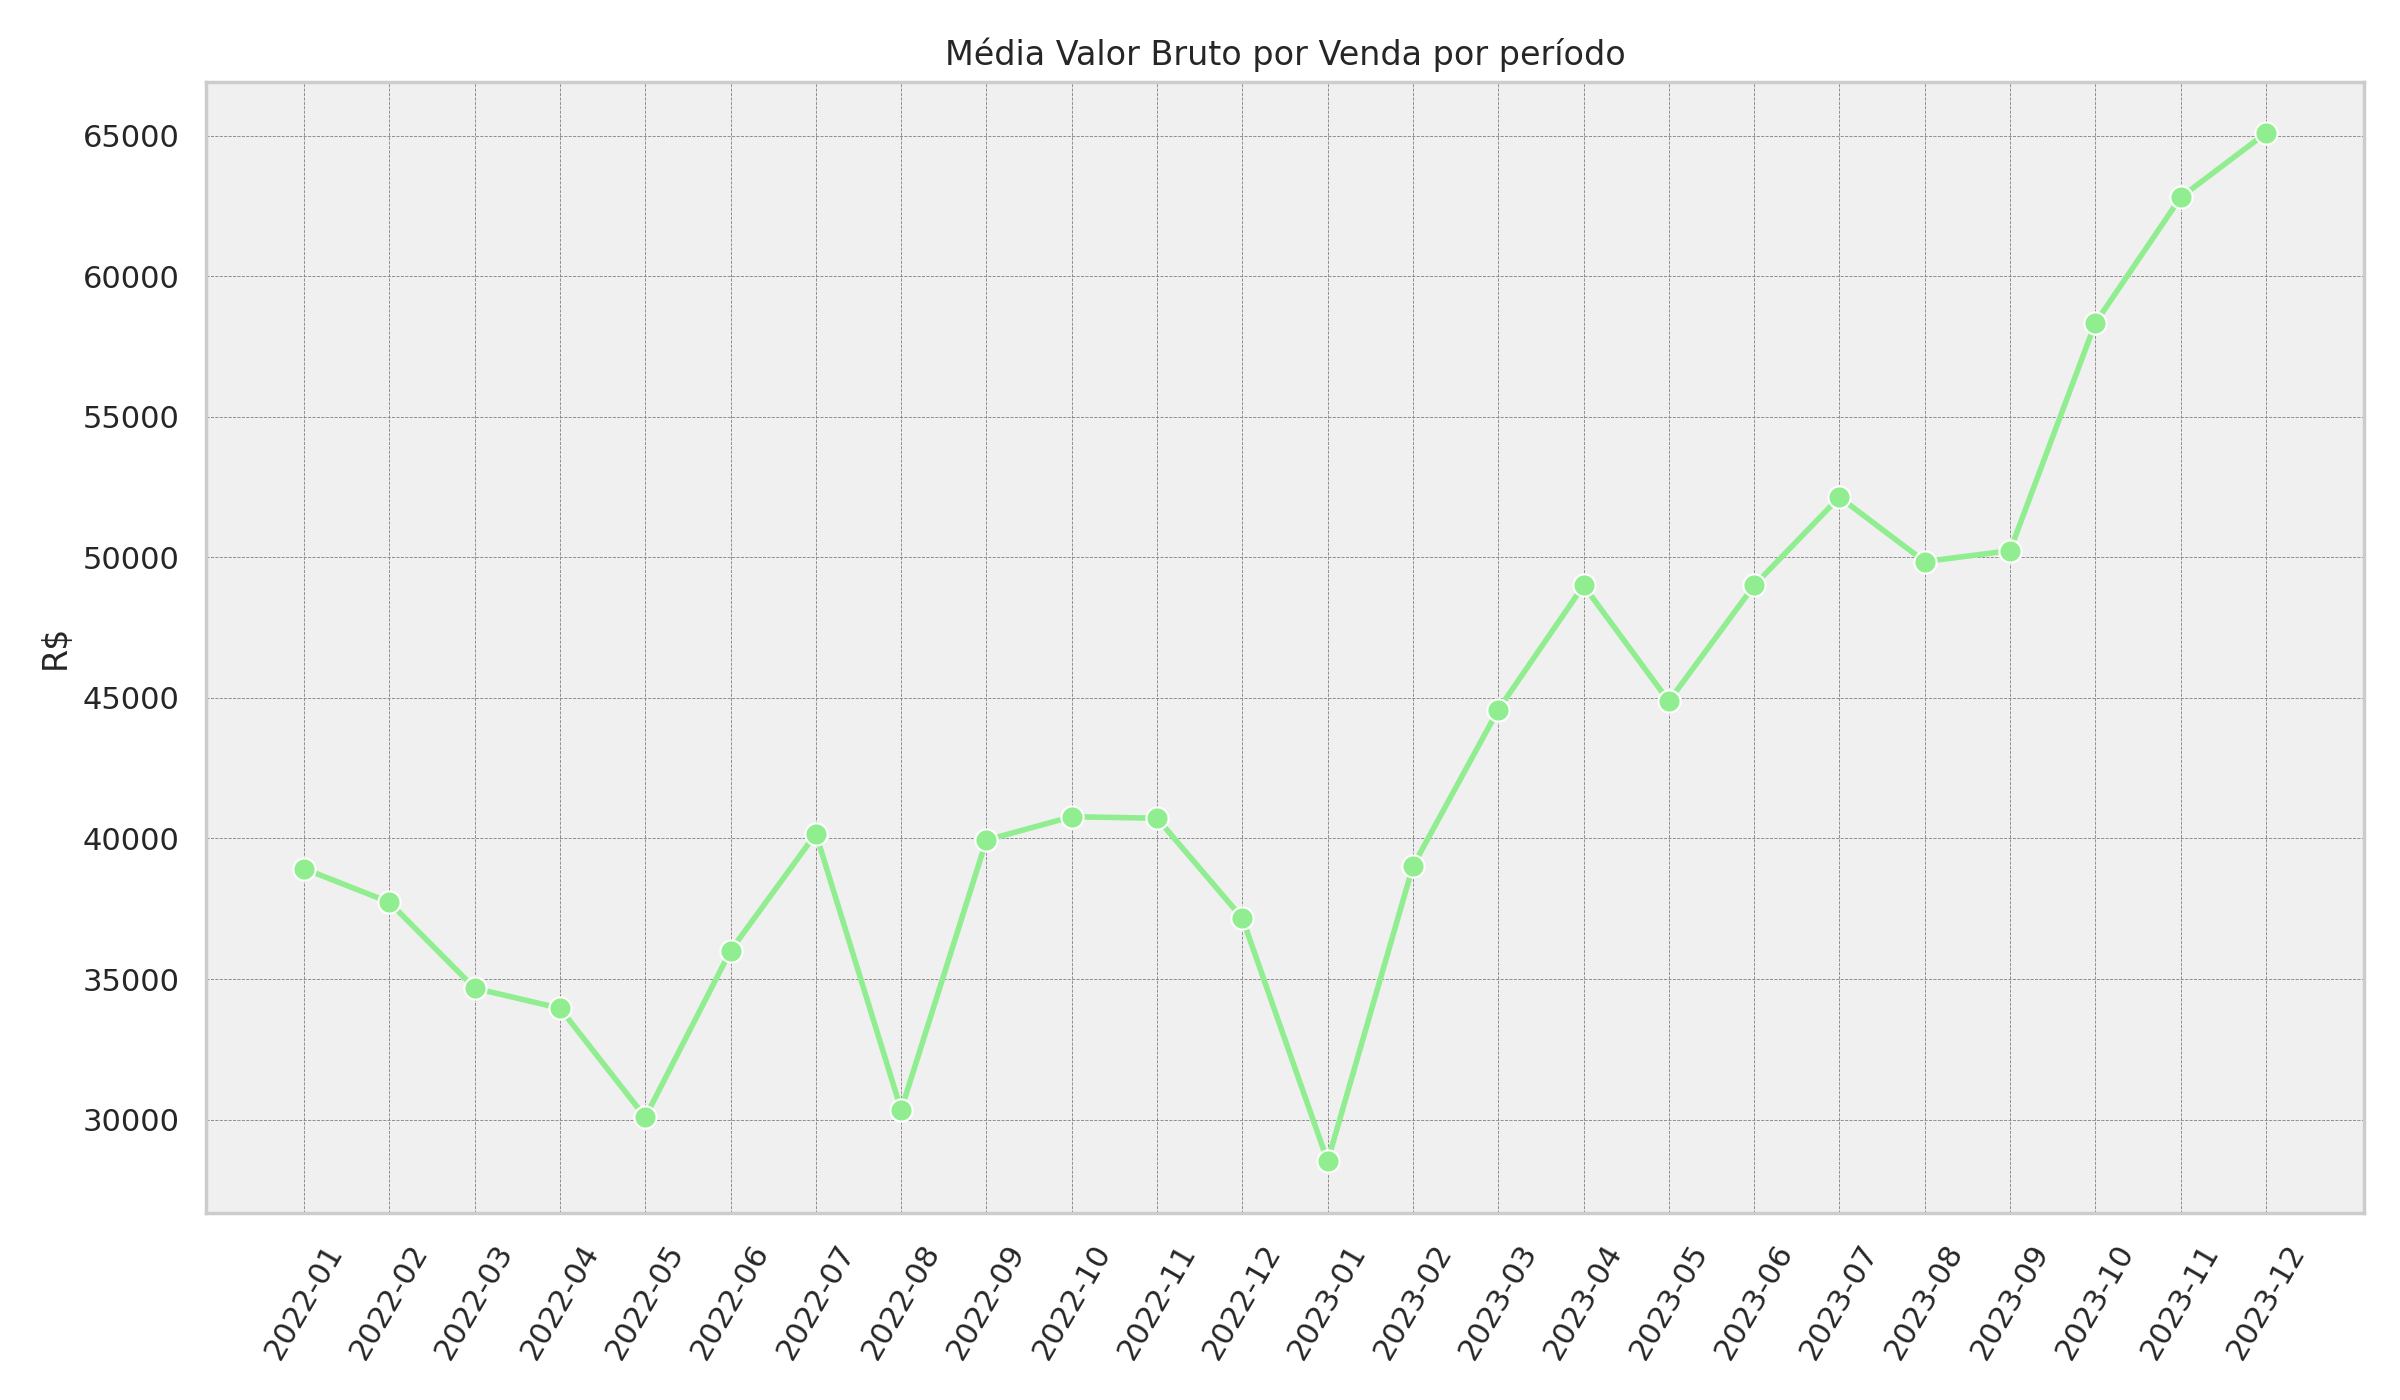

In [183]:
sns.set(style="whitegrid")

yearly_monthly_mean = data.groupby(['ano_mes'])['valor_bruto_venda'].mean().to_frame().sort_values(by='ano_mes',ascending=True).reset_index()

# Plotting line plot for mean 'valor_bruto_venda' per year-month
plt.figure(figsize=(12, 7))
sns.lineplot(x='ano_mes', y='valor_bruto_venda', data=yearly_monthly_mean, color='lightgreen', marker='o', markersize=8, linewidth=2)
plt.xlabel('')
plt.ylabel('R$')
plt.title('Média Valor Bruto por Venda por período')
plt.xticks(rotation=60)
plt.gca().set_facecolor('#F0F0F0')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

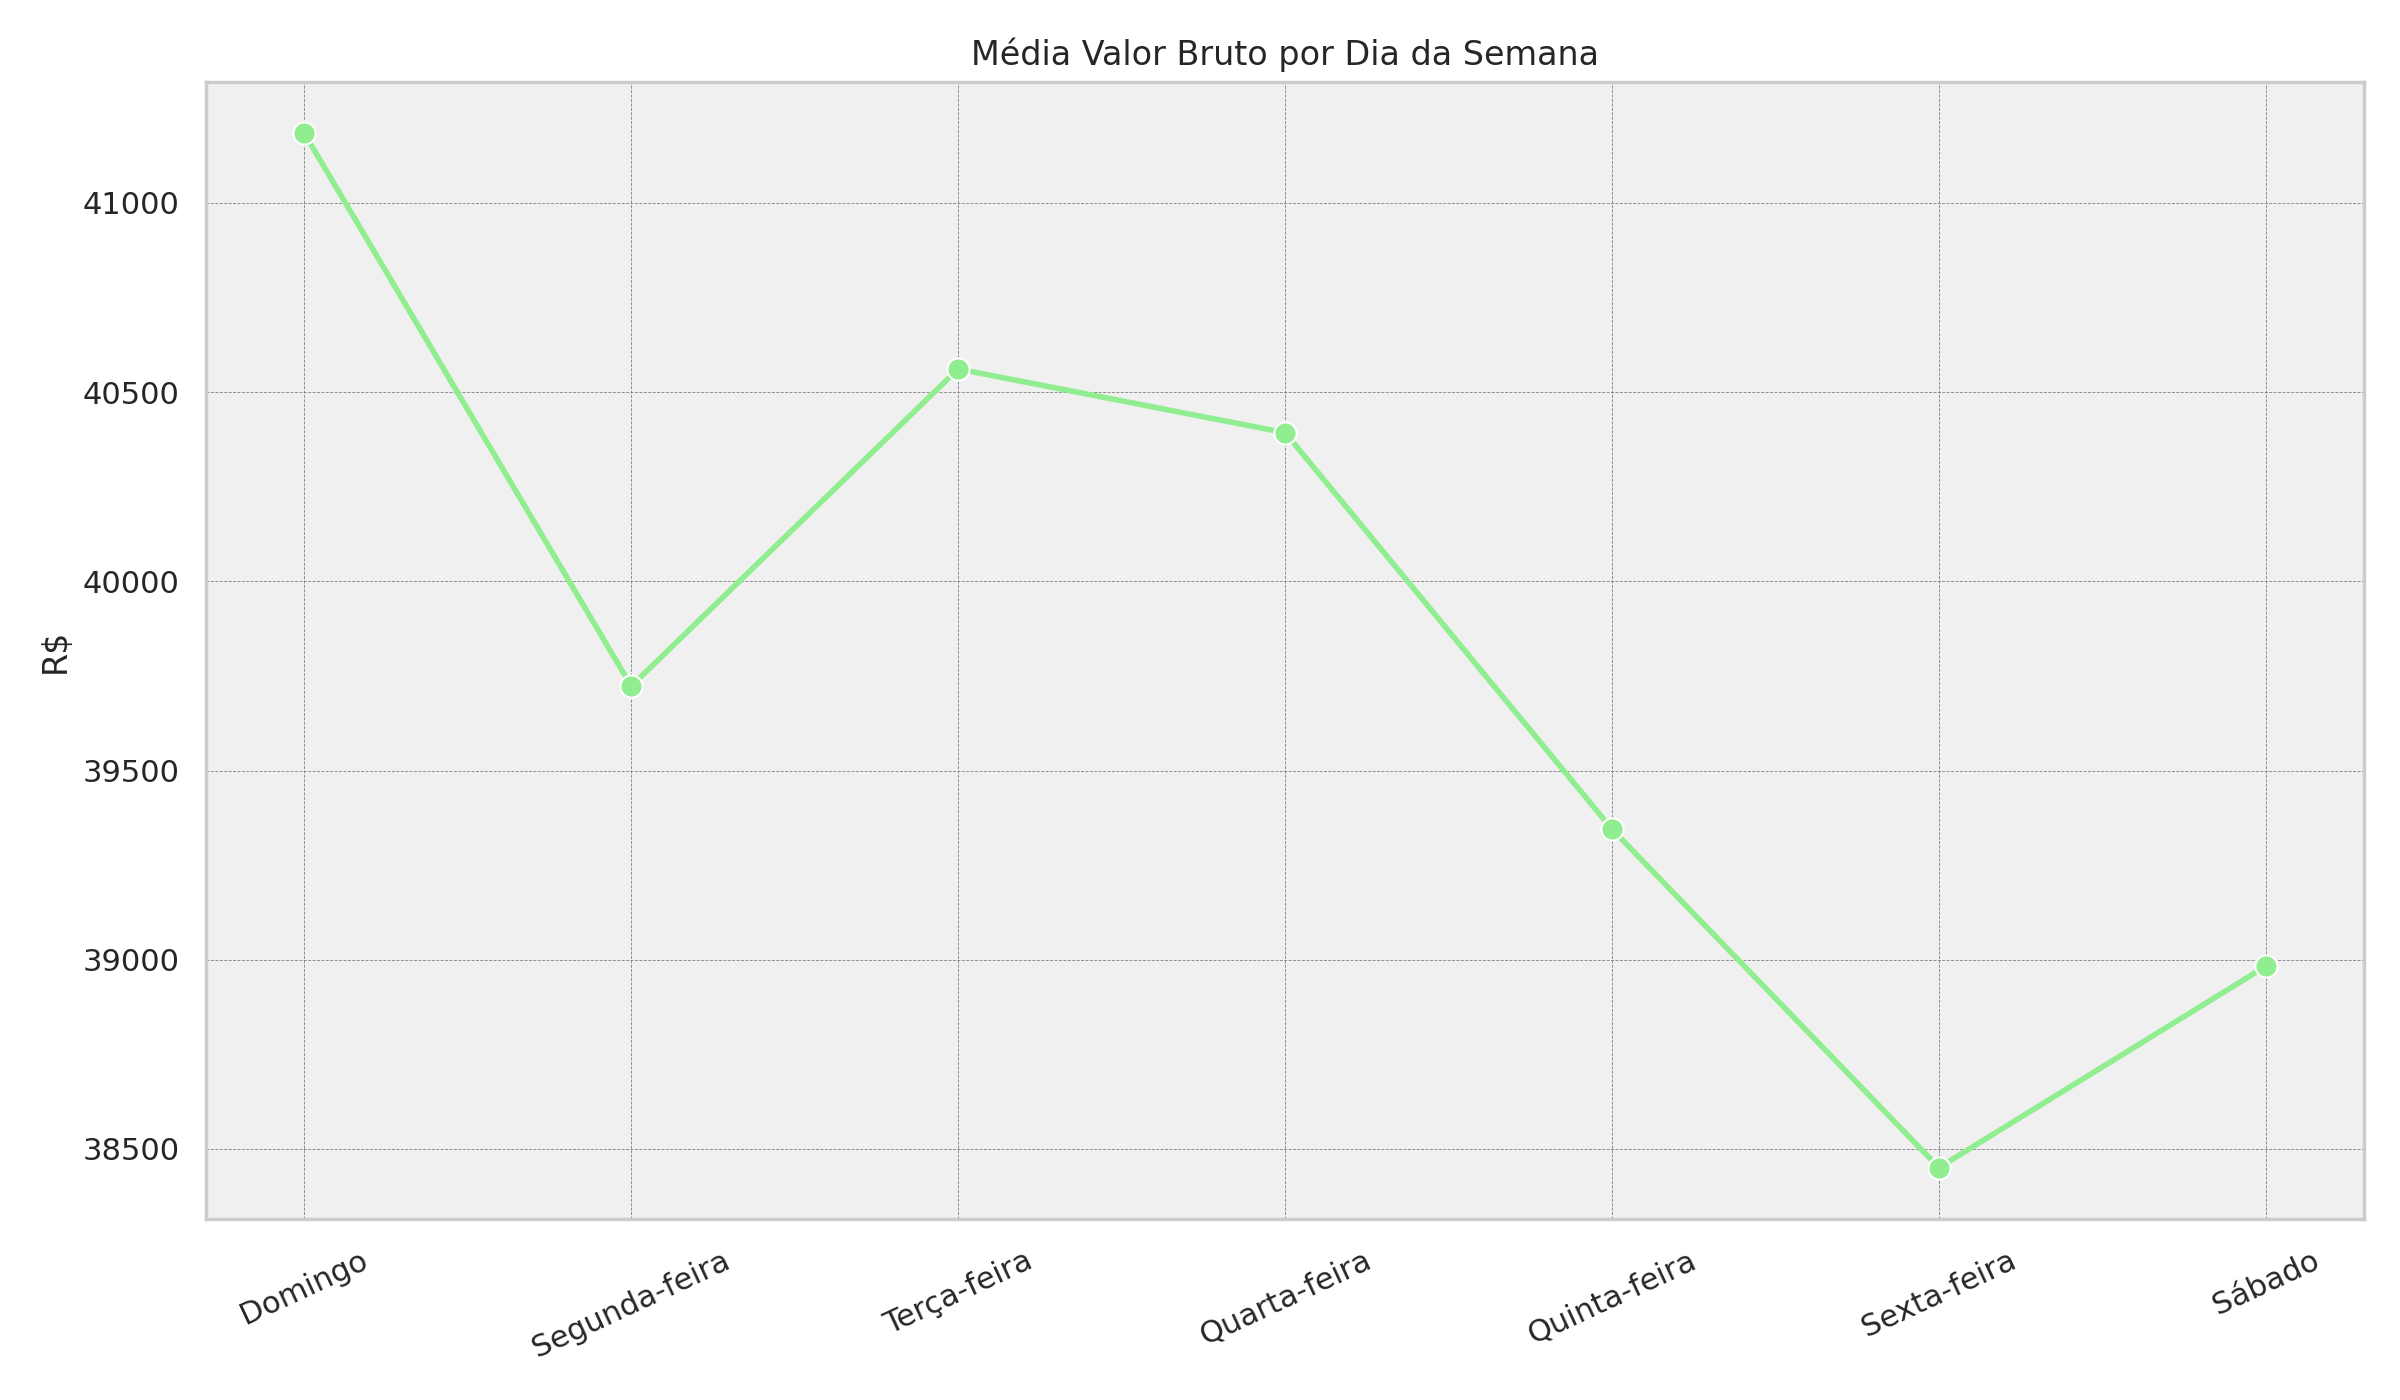

In [184]:
sns.set(style="whitegrid")

weekday_mean = data.groupby(['dia_da_semana'])['valor_bruto_venda'].mean().to_frame().reset_index()

custom_order = ['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado']

plt.figure(figsize=(12, 7))
sns.lineplot(x='dia_da_semana', y='valor_bruto_venda', data=weekday_mean, color='lightgreen', marker='o', markersize=8, linewidth=2)
plt.xlabel('')
plt.ylabel('R$')
plt.title('Média Valor Bruto por Dia da Semana')
plt.gca().set_facecolor('#F0F0F0')
plt.grid(color='gray', linestyle='--', linewidth=0.3)

plt.xticks(range(len(custom_order)), custom_order, rotation=25)

plt.tight_layout()
plt.show()

VALOR LIQUIDO DA VENDA

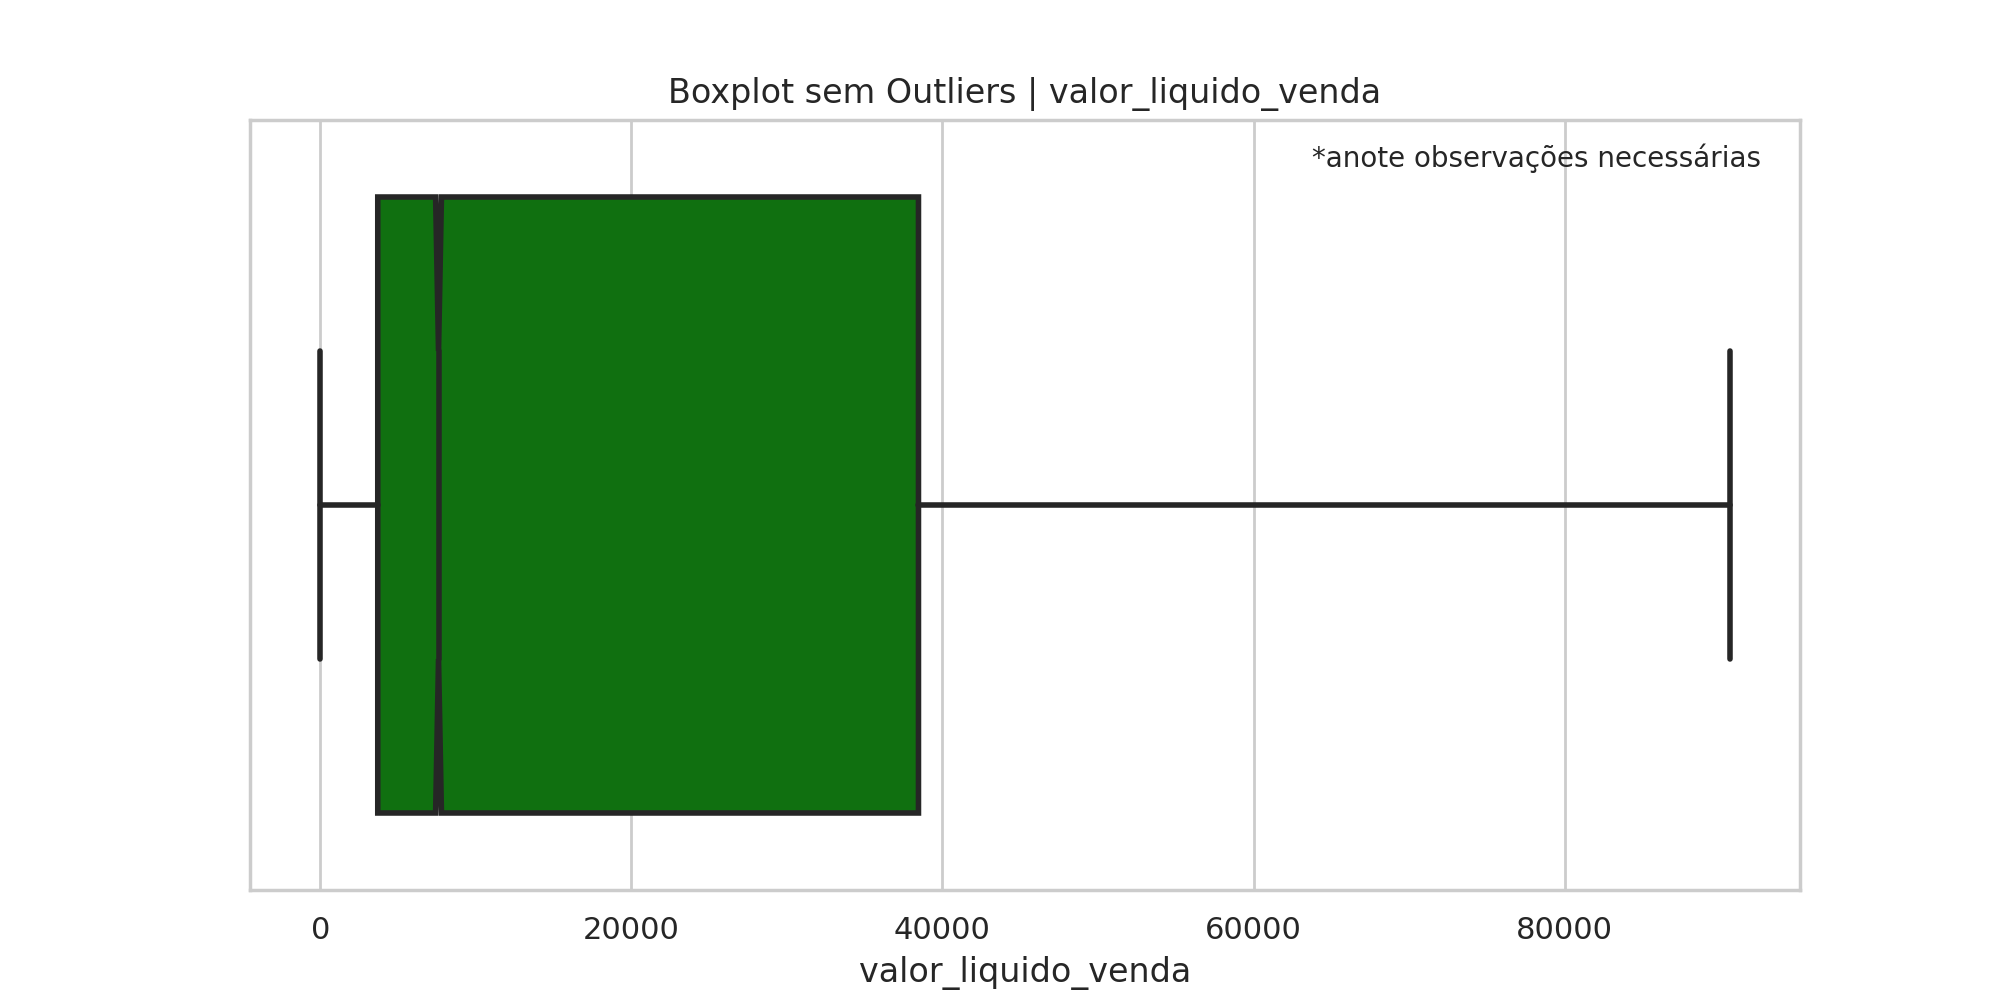

In [185]:
plt.figure(figsize=(10,5))
sns.boxplot(x='valor_liquido_venda', data=data, color='green', showfliers=False, linewidth=2, notch=True)
plt.title('Boxplot sem Outliers | valor_liquido_venda')
plt.text(0.83, 0.95, '*anote observações necessárias', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)
plt.show()

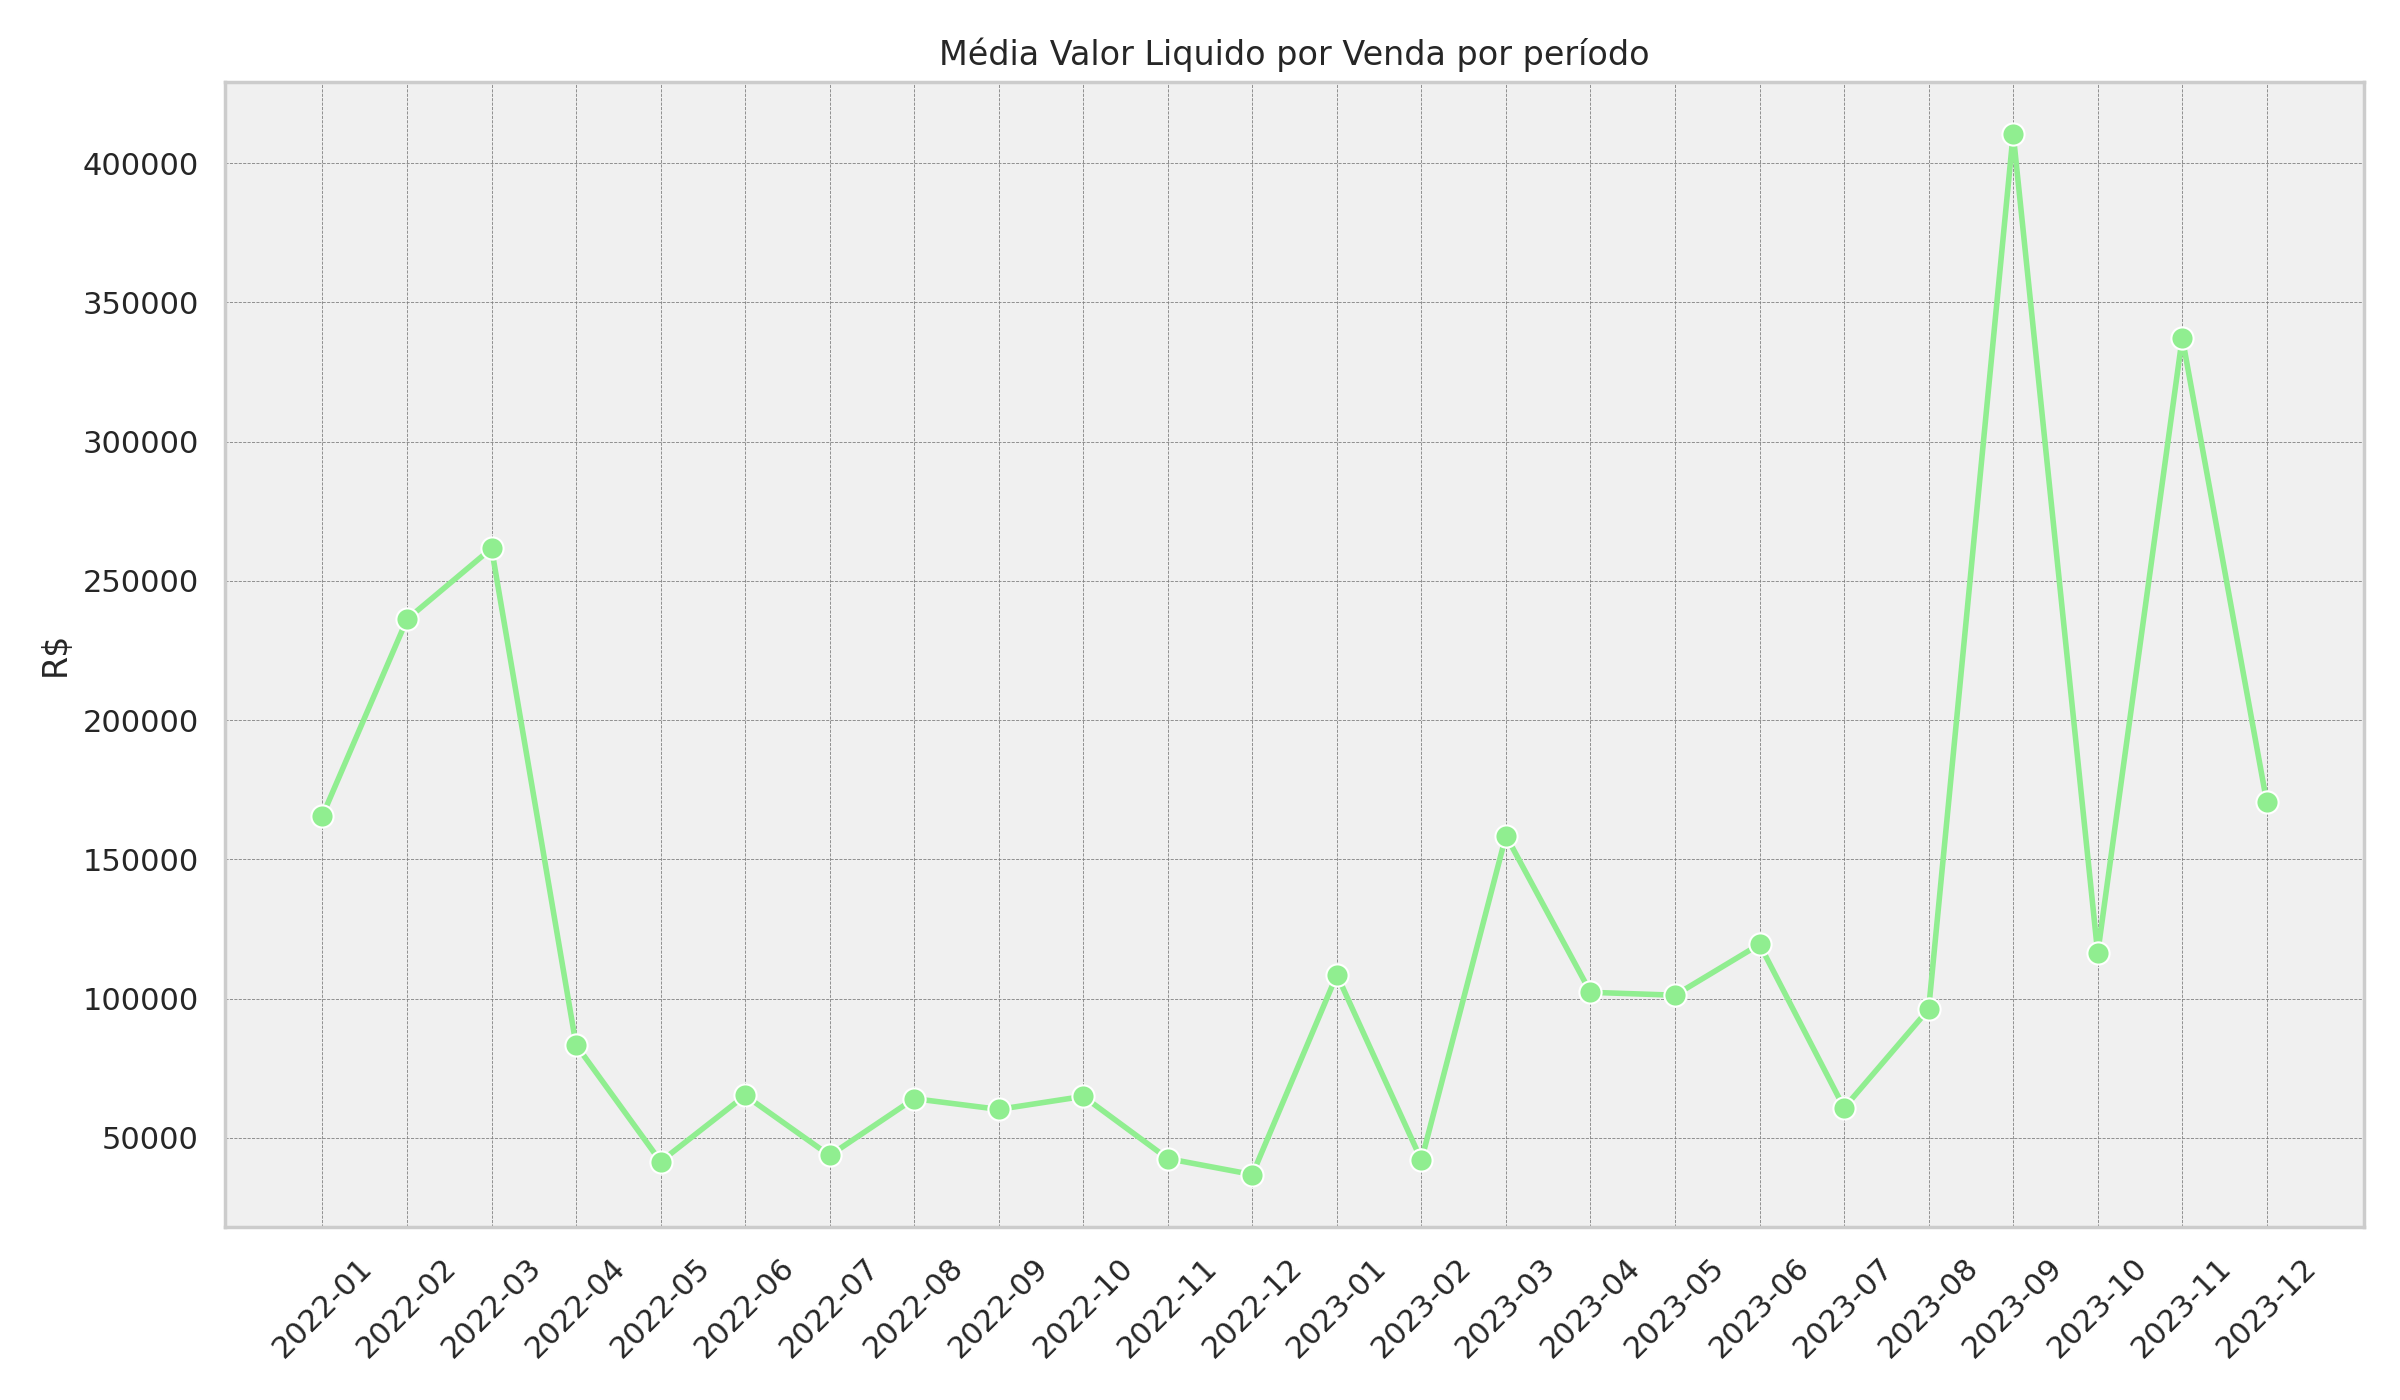

In [186]:
sns.set(style="whitegrid")

yearly_monthly_mean = data.groupby(['ano_mes'])['valor_liquido_venda'].mean().to_frame().sort_values(by='ano_mes',ascending=True).reset_index()

# Plotting line plot for mean 'valor_liquido_venda' per year-month
plt.figure(figsize=(12,7))
sns.lineplot(x='ano_mes', y='valor_liquido_venda', data=yearly_monthly_mean, color='lightgreen', marker='o', markersize=8, linewidth=2)
plt.xlabel('')
plt.ylabel('R$')
plt.title('Média Valor Liquido por Venda por período')
plt.xticks(rotation=45)
plt.gca().set_facecolor('#F0F0F0')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

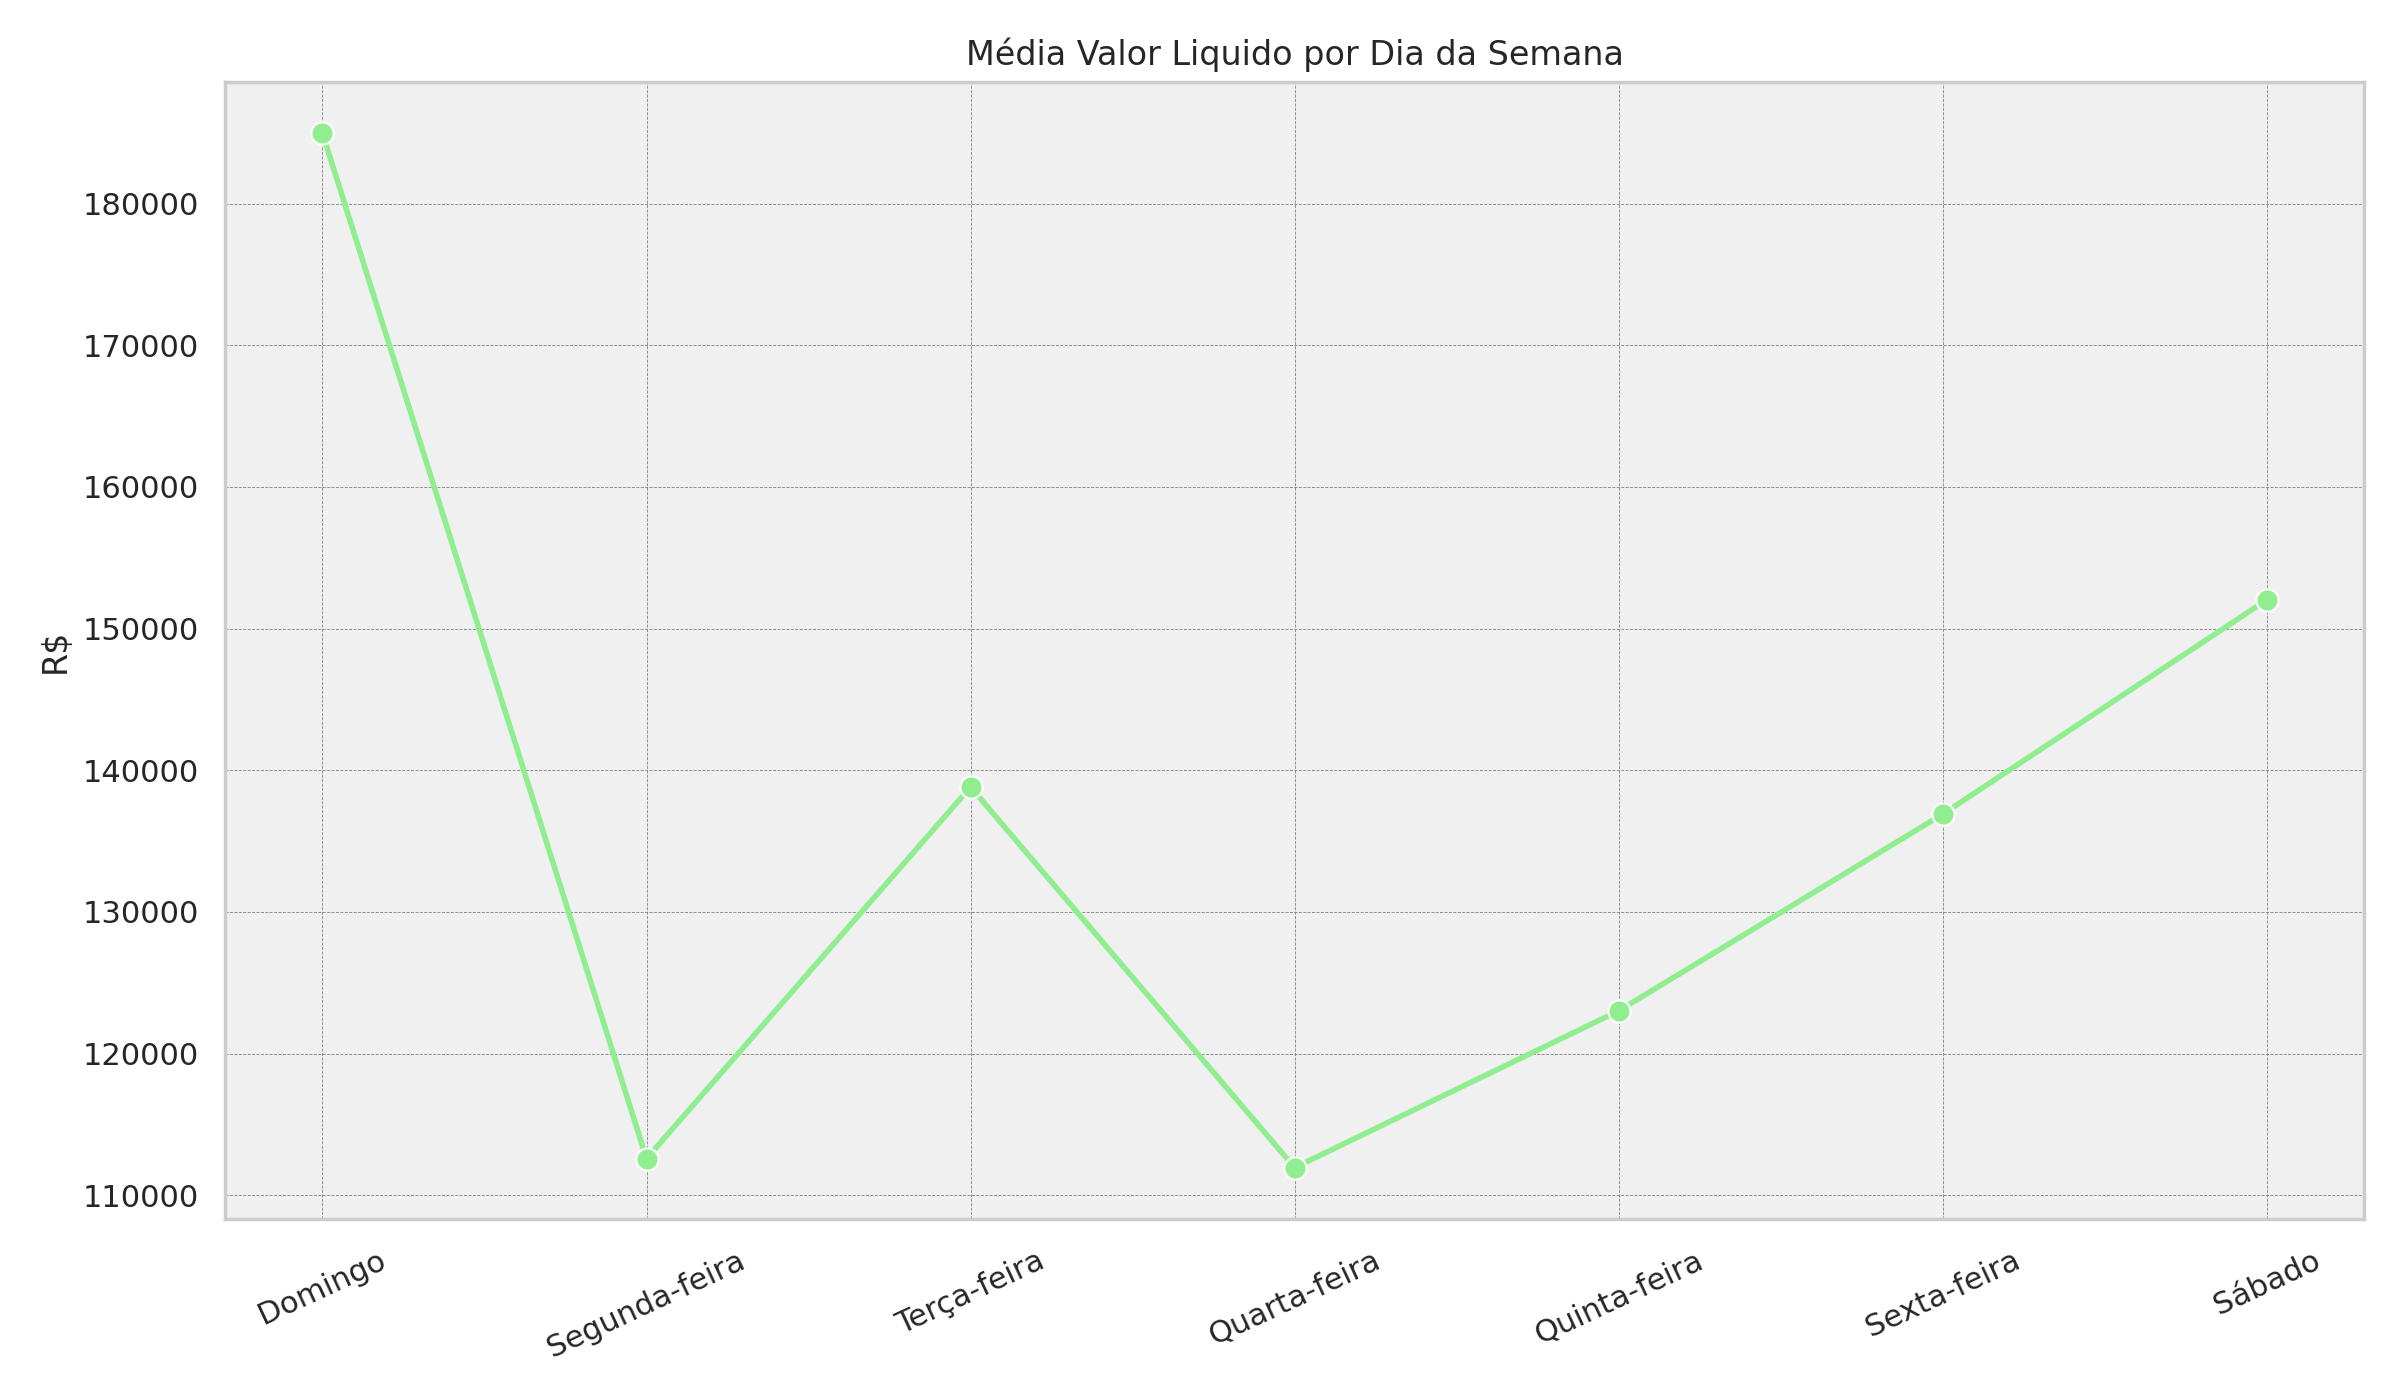

In [187]:
sns.set(style="whitegrid")

weekday_mean = data.groupby(['dia_da_semana'])['valor_liquido_venda'].mean().to_frame().reset_index()

custom_order = ['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado']

plt.figure(figsize=(12,7))
sns.lineplot(x='dia_da_semana', y='valor_liquido_venda', data=weekday_mean, color='lightgreen', marker='o', markersize=8, linewidth=2)
plt.xlabel('')
plt.ylabel('R$')
plt.title('Média Valor Liquido por Dia da Semana')
plt.gca().set_facecolor('#F0F0F0')
plt.grid(color='gray', linestyle='--', linewidth=0.3)

plt.xticks(range(len(custom_order)), custom_order, rotation=25)
plt.tight_layout()
plt.show()

PREÇO PRODUTO VENDIDO

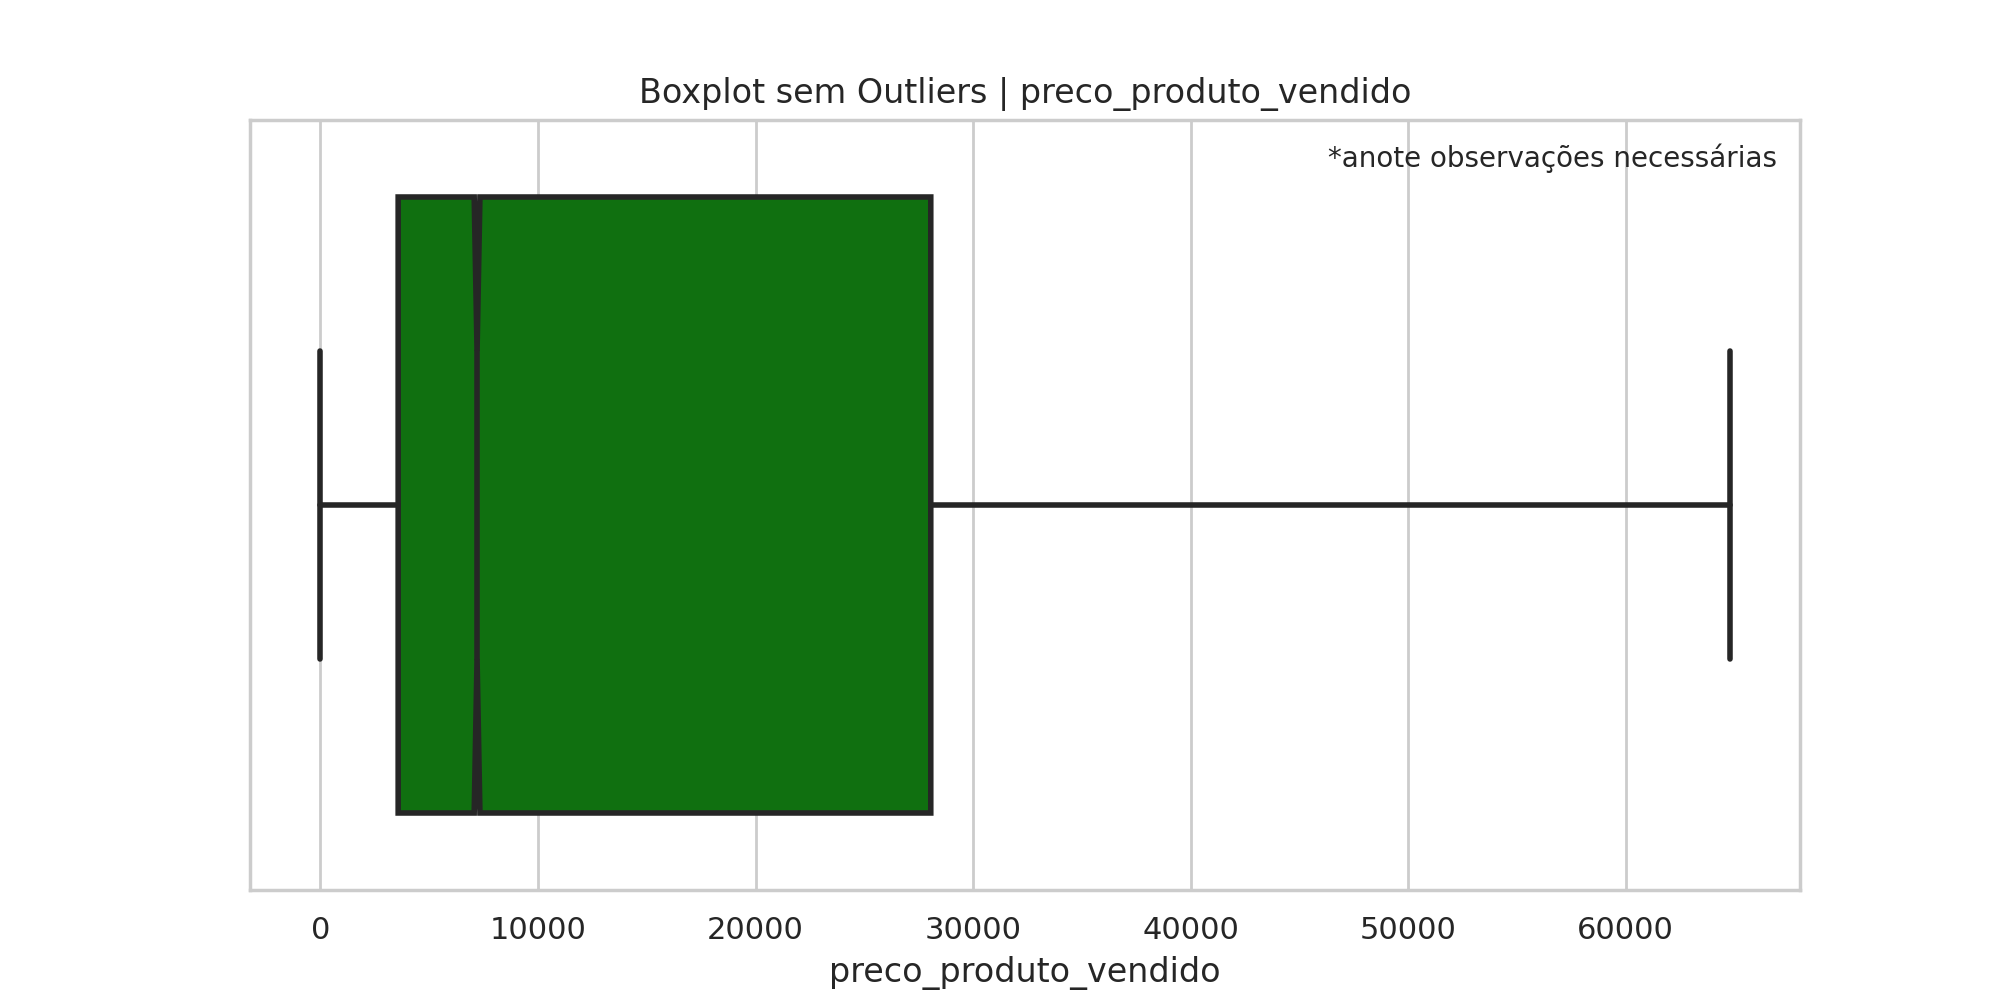

In [188]:
plt.figure(figsize=(10,5))
sns.boxplot(x='preco_produto_vendido', data=data, color='green', showfliers=False, linewidth=2, notch=True)
plt.title('Boxplot sem Outliers | preco_produto_vendido')
plt.text(0.84, 0.95, '*anote observações necessárias', transform=plt.gca().transAxes, ha='center', va='center', fontsize=10)
plt.show()

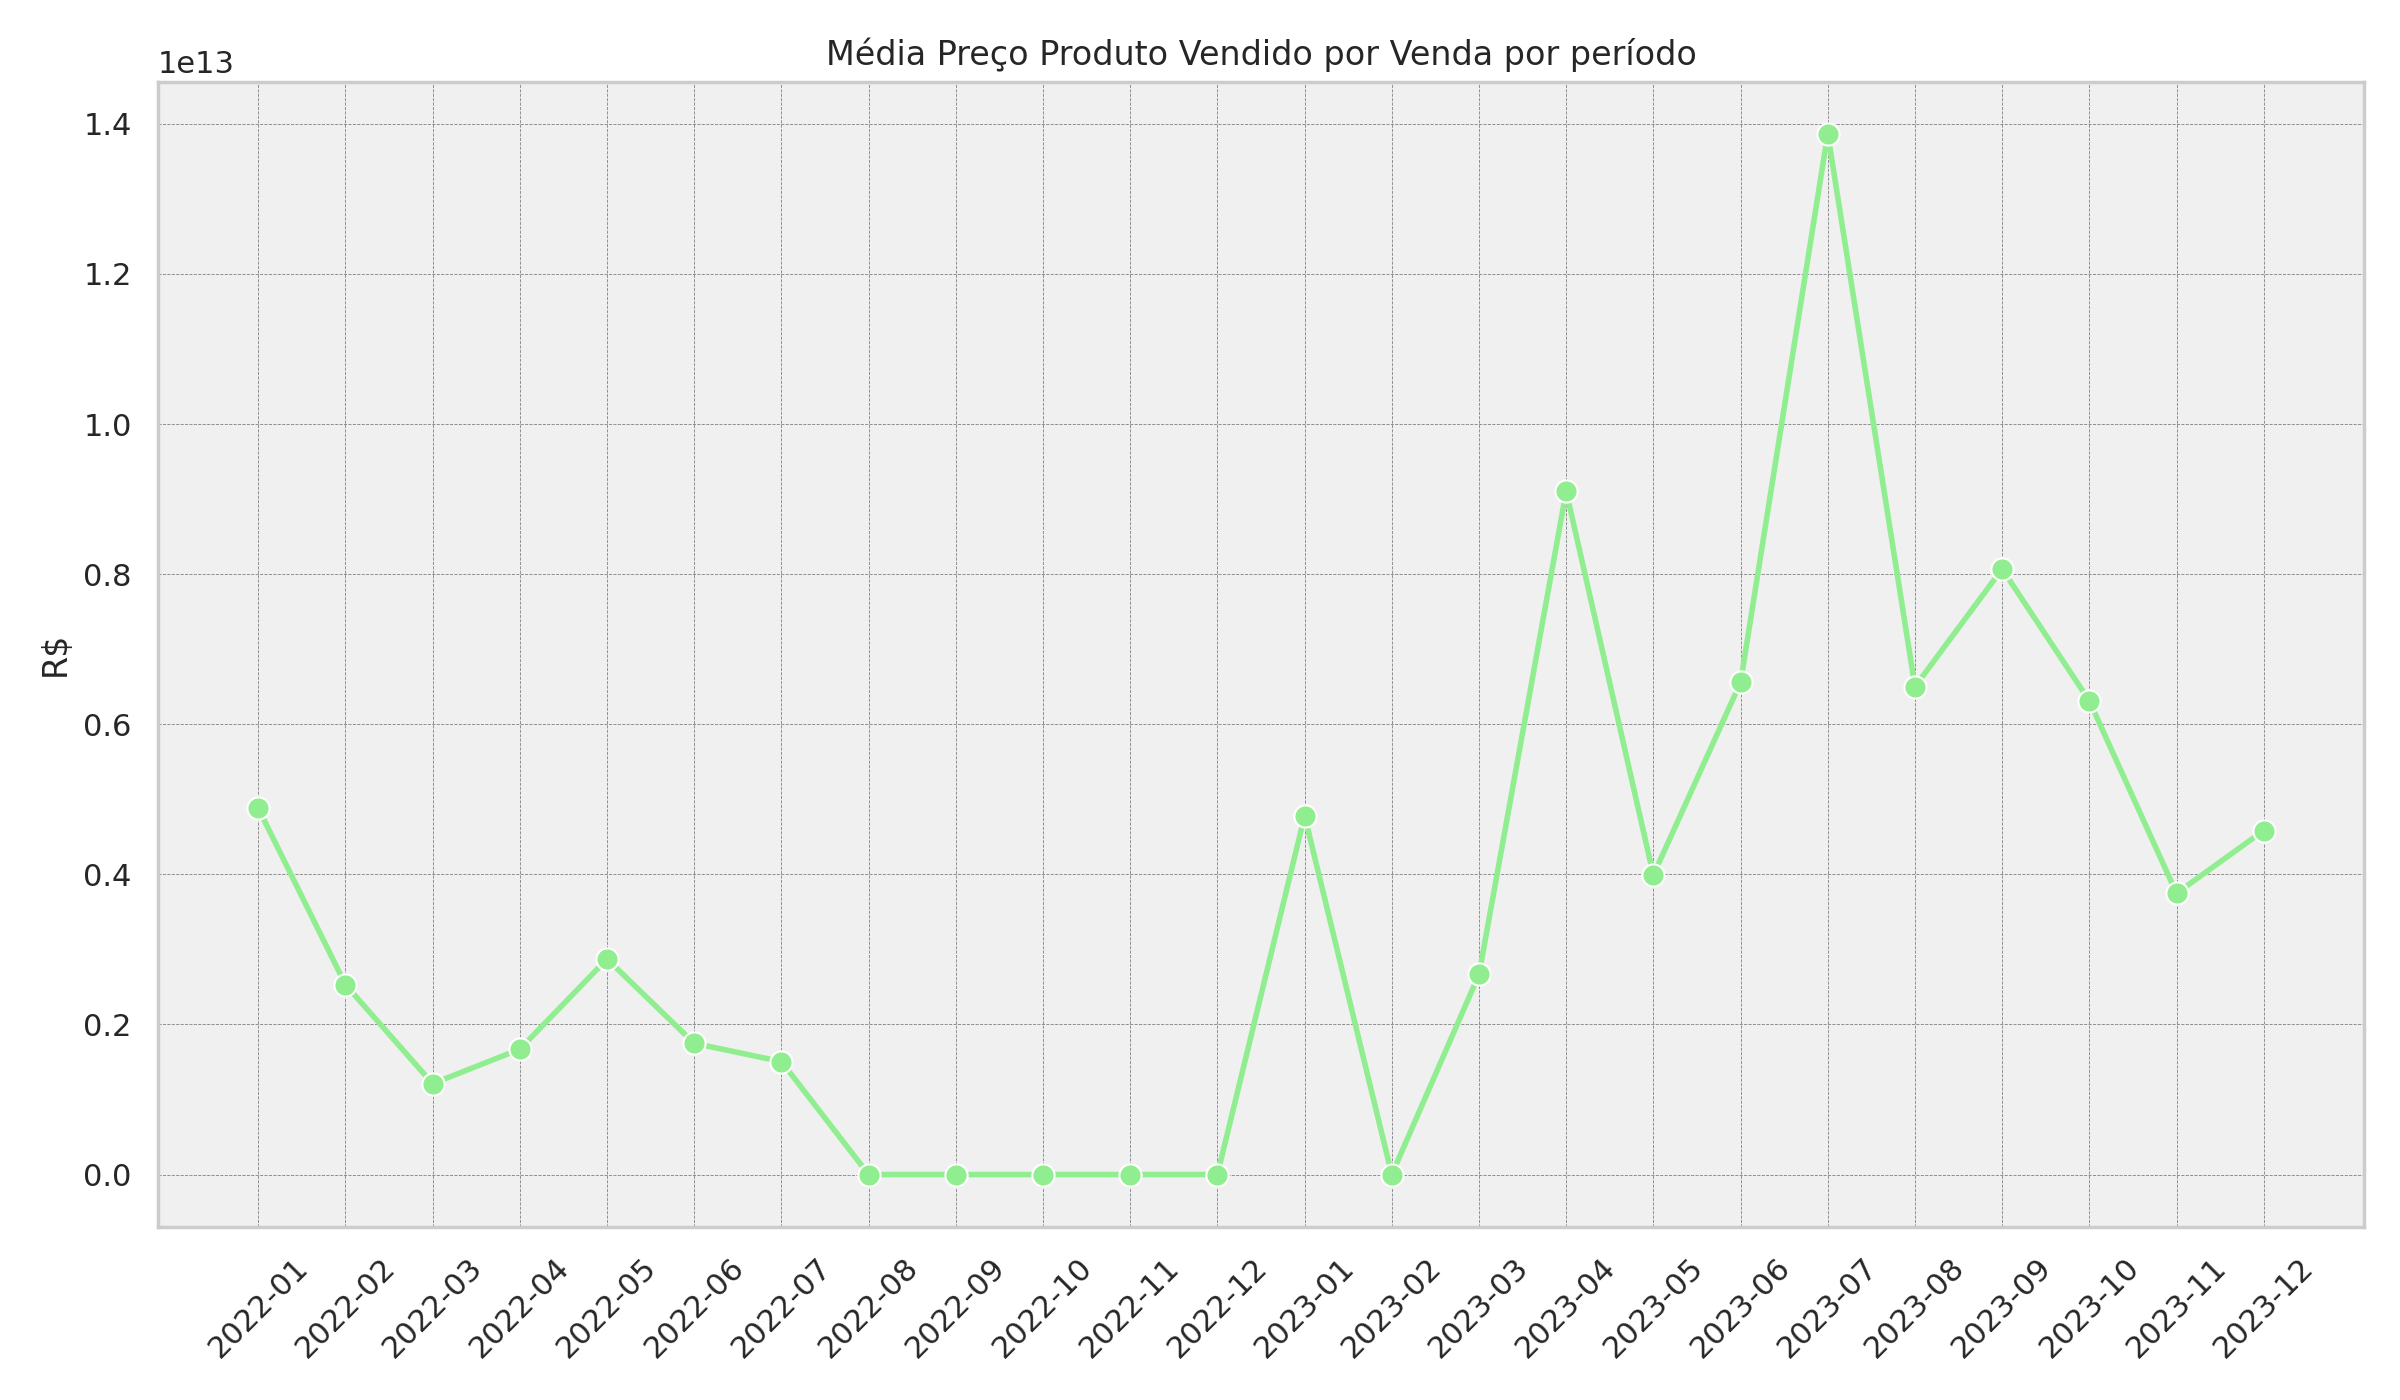

In [189]:
sns.set(style="whitegrid")

yearly_monthly_mean = data.groupby(['ano_mes'])['preco_produto_vendido'].mean().to_frame().sort_values(by='ano_mes',ascending=True).reset_index()

# Plotting line plot for mean 'preco_produto_vendido' per year-month
plt.figure(figsize=(12,7))
sns.lineplot(x='ano_mes', y='preco_produto_vendido', data=yearly_monthly_mean, color='lightgreen', marker='o', markersize=8, linewidth=2)
plt.xlabel('')
plt.ylabel('R$')
plt.title('Média Preço Produto Vendido por Venda por período')
plt.xticks(rotation=45)
plt.gca().set_facecolor('#F0F0F0')
plt.grid(color='gray', linestyle='--', linewidth=0.3)
plt.tight_layout()
plt.show()

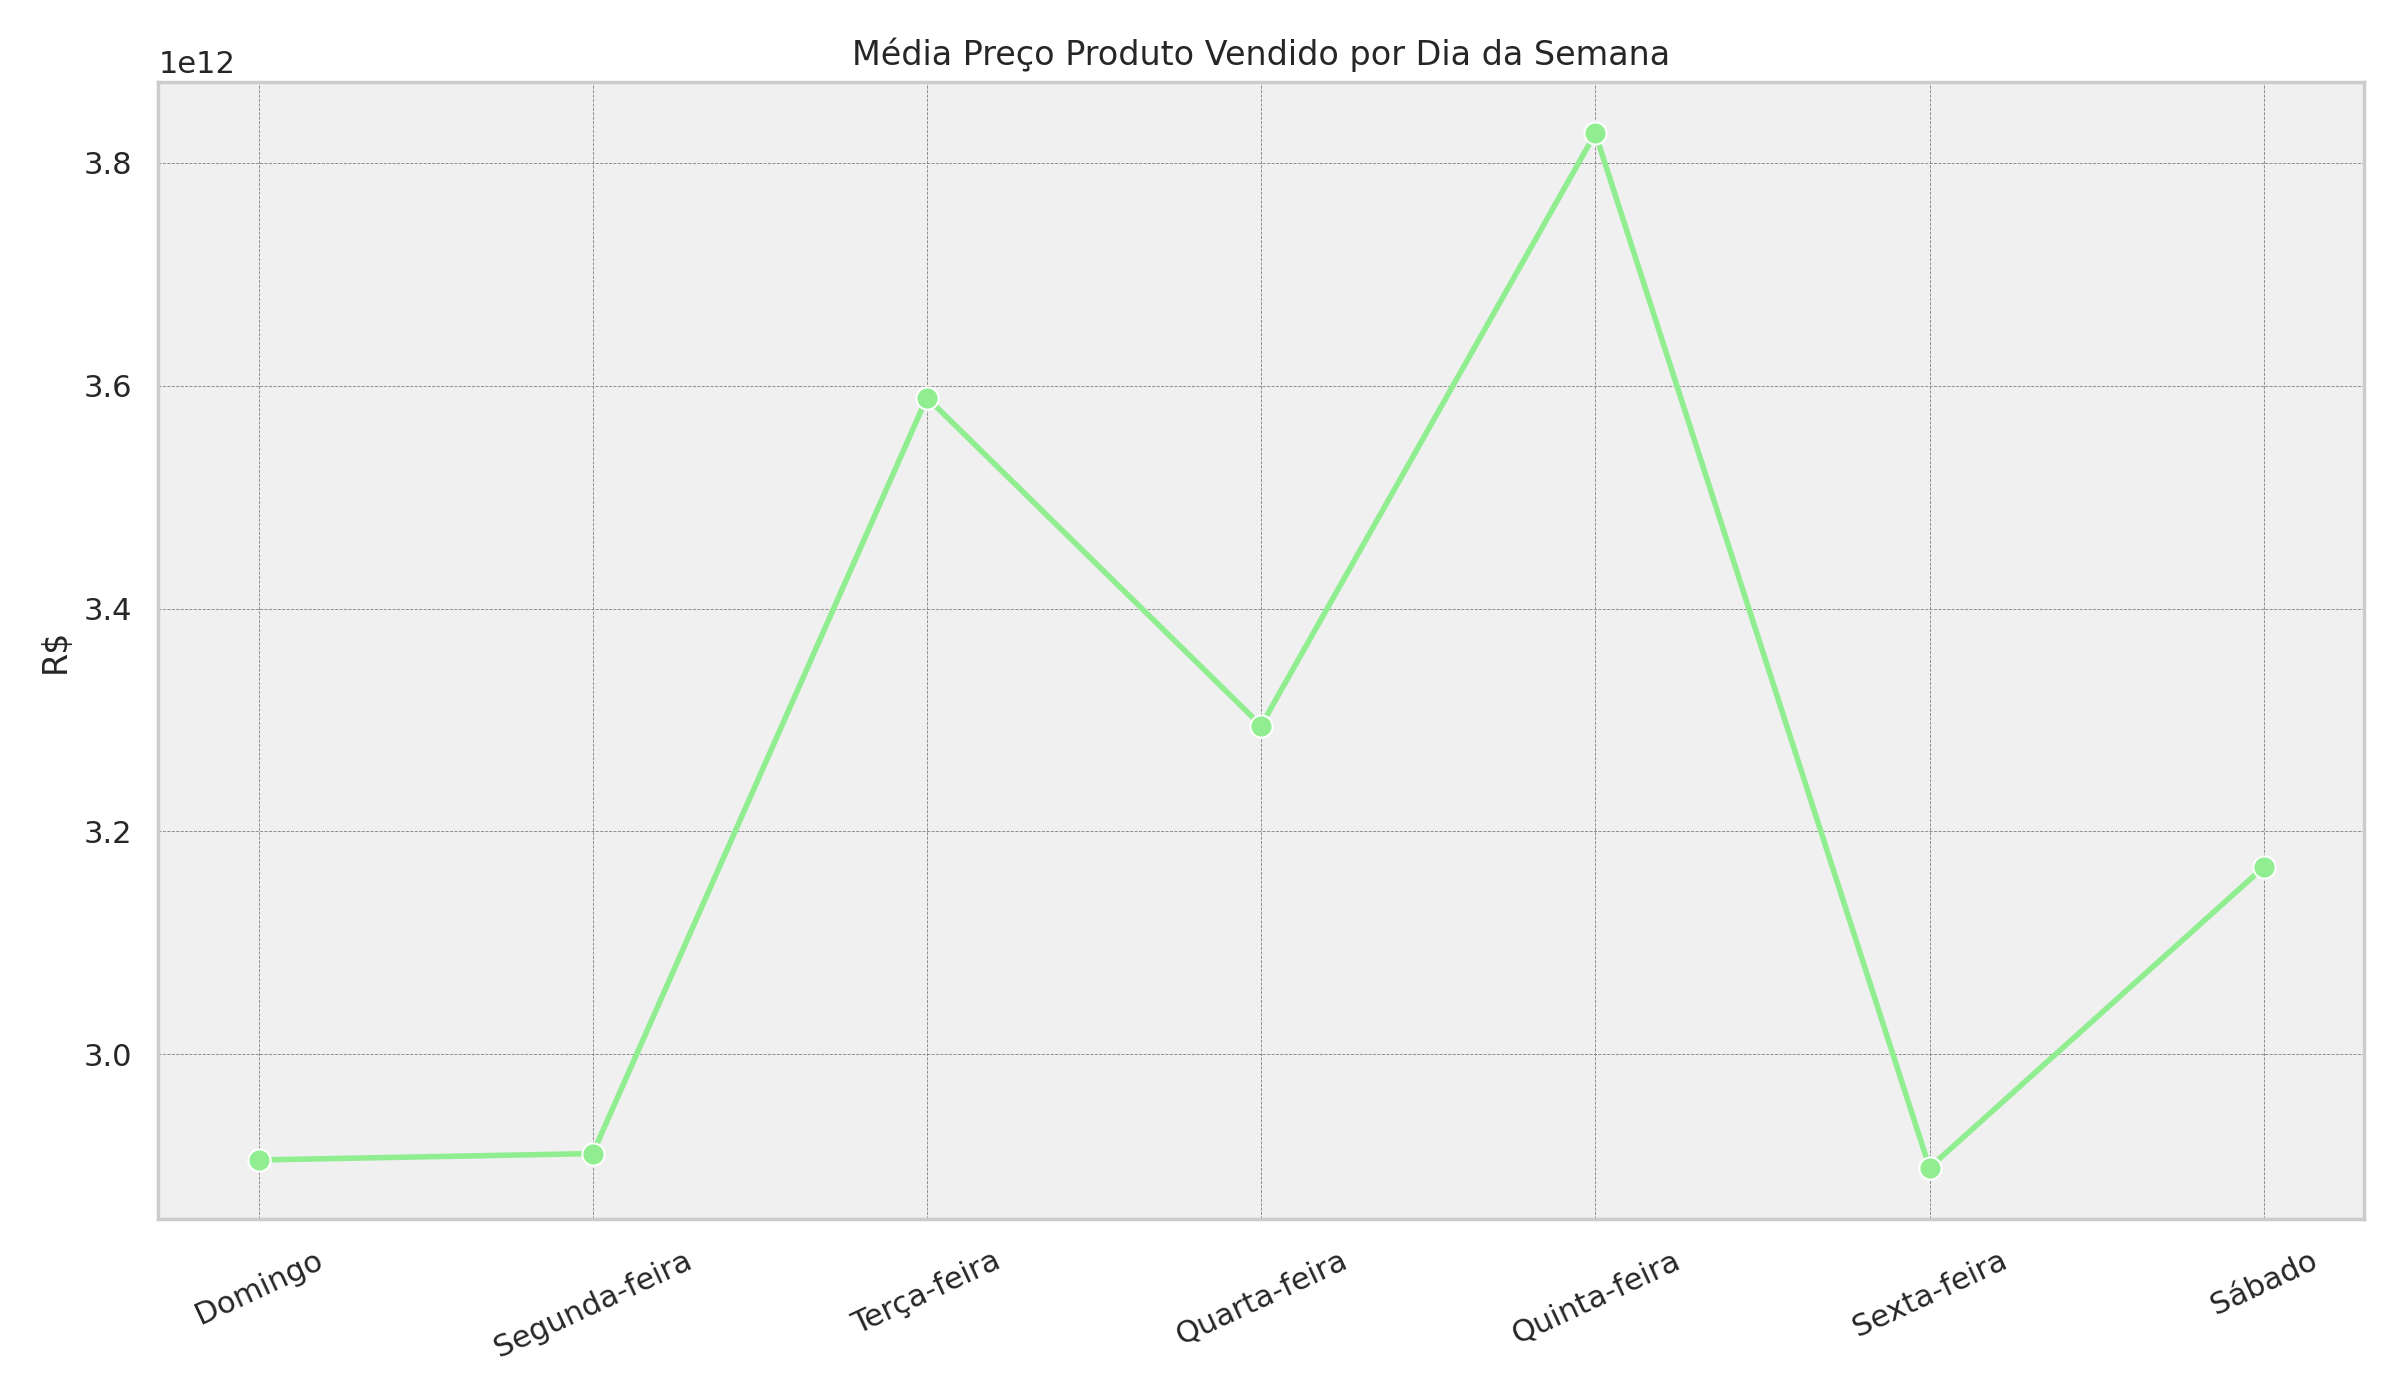

In [190]:
sns.set(style="whitegrid")

weekday_mean = data.groupby(['dia_da_semana'])['preco_produto_vendido'].mean().to_frame().reset_index()

custom_order = ['Domingo', 'Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado']

plt.figure(figsize=(12,7))
sns.lineplot(x='dia_da_semana', y='preco_produto_vendido', data=weekday_mean, color='lightgreen', marker='o', markersize=8, linewidth=2)
plt.xlabel('')
plt.ylabel('R$')
plt.title('Média Preço Produto Vendido por Dia da Semana')
plt.gca().set_facecolor('#F0F0F0')
plt.grid(color='gray', linestyle='--', linewidth=0.3)

plt.xticks(range(len(custom_order)), custom_order, rotation=25)

plt.tight_layout()
plt.show()

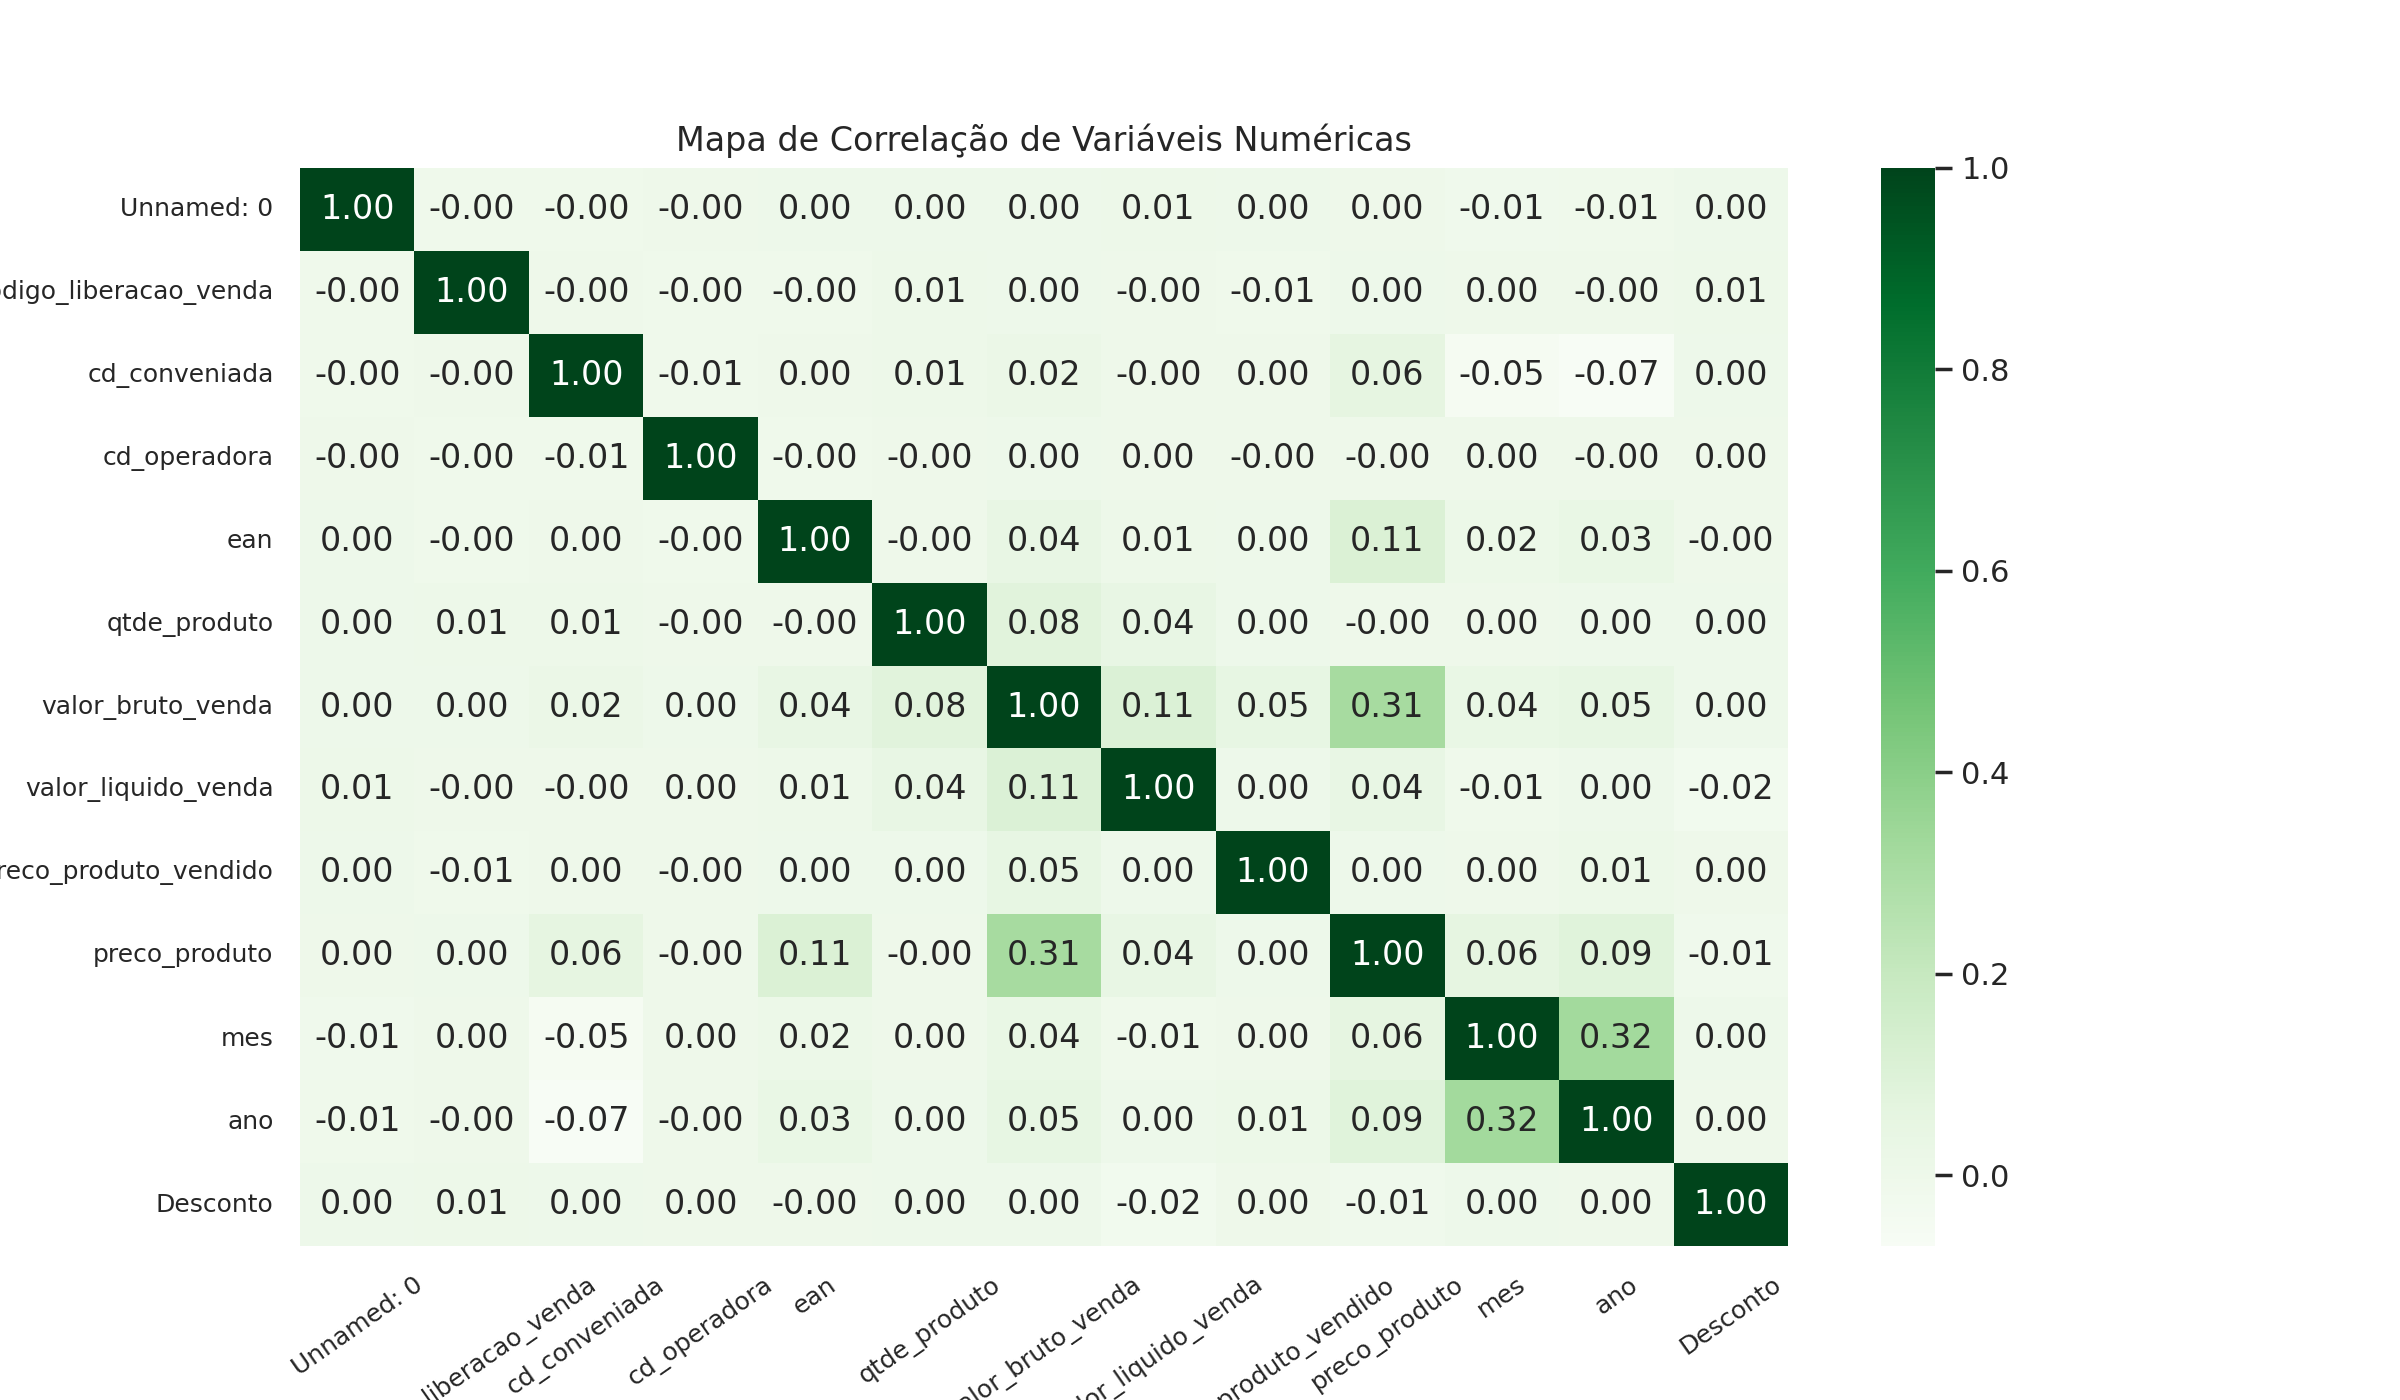

In [191]:
# Correlation heatmap
plt.figure(figsize=(12, 7))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Mapa de Correlação de Variáveis Numéricas')
plt.xticks(rotation=35)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.show()

**Análise Descritiva**

*Variáveis categóricas*

In [192]:
rp.summary_cat(data['uf'])

Variable Outcome  Count  Percent
0        uf      SP  49561   58.290
1                RJ  22029   25.910
2                MG   3810    4.480
3                BA   3497    4.110
4                ES   1718    2.020
5                DF   1339    1.570
6                PE   1204    1.420
7                GO    998    1.170
8                PR    680    0.800
9                MT    182    0.210
10               AC      5    0.010

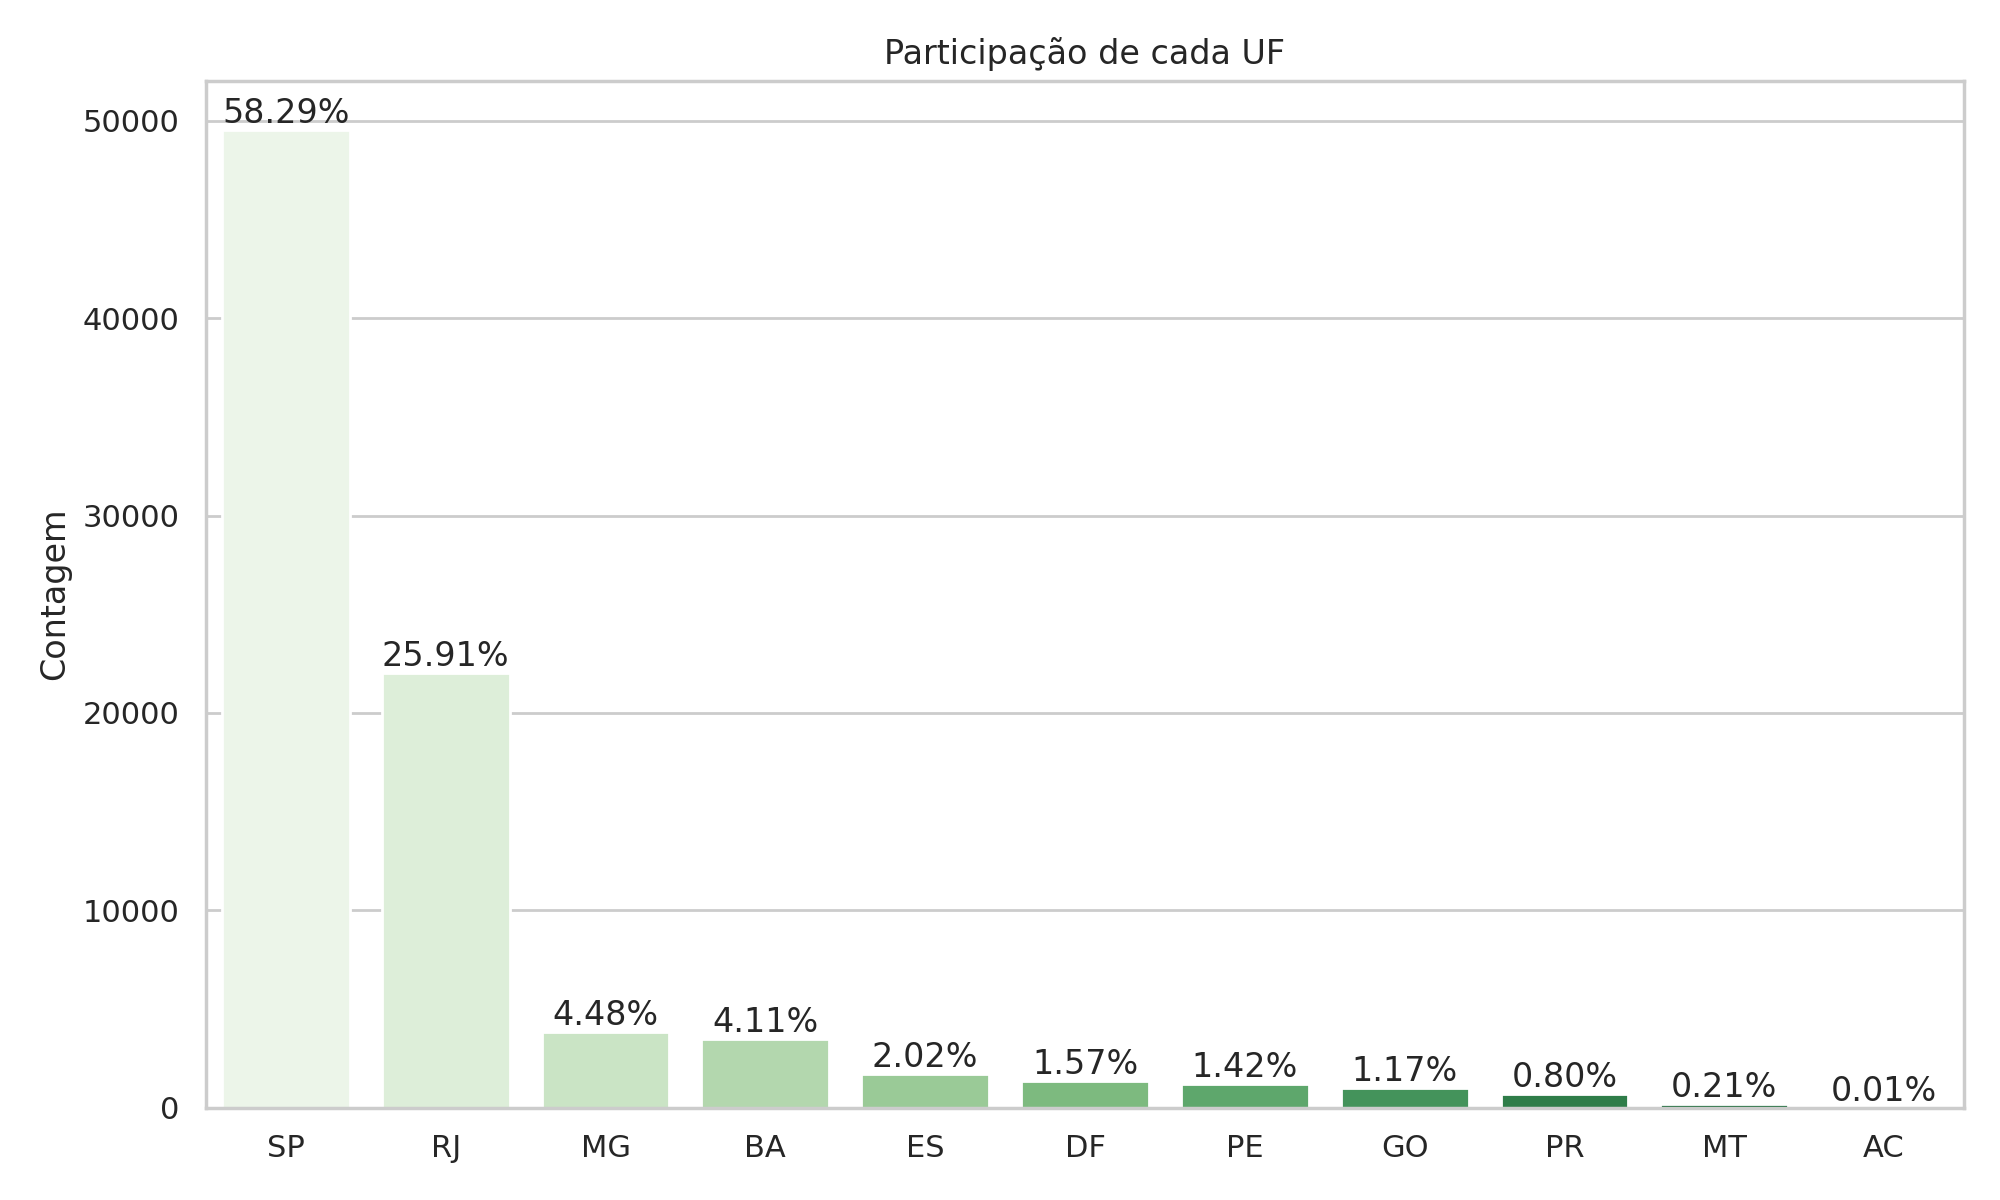

In [193]:
plt.figure(figsize=(10, 6))

rede_order = data['uf'].value_counts().index
ax = sns.countplot(data=data, x='uf', order=rede_order, palette='Greens')
plt.title('Participação de cada UF')
plt.xlabel('')
plt.ylabel('Contagem')
#plt.xticks(rotation=90)

total = len(data['uf'])  
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total)  
    x = p.get_x() + p.get_width() / 2  
    y = p.get_height()  
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [194]:
rp.summary_cat(data['sexo'])

Variable         Outcome  Count  Percent
0     sexo   nao_informado  71668   84.290
1           nao_preenchido   6994    8.230
2                        F   3497    4.110
3                        M   2835    3.330
4                        I     29    0.030

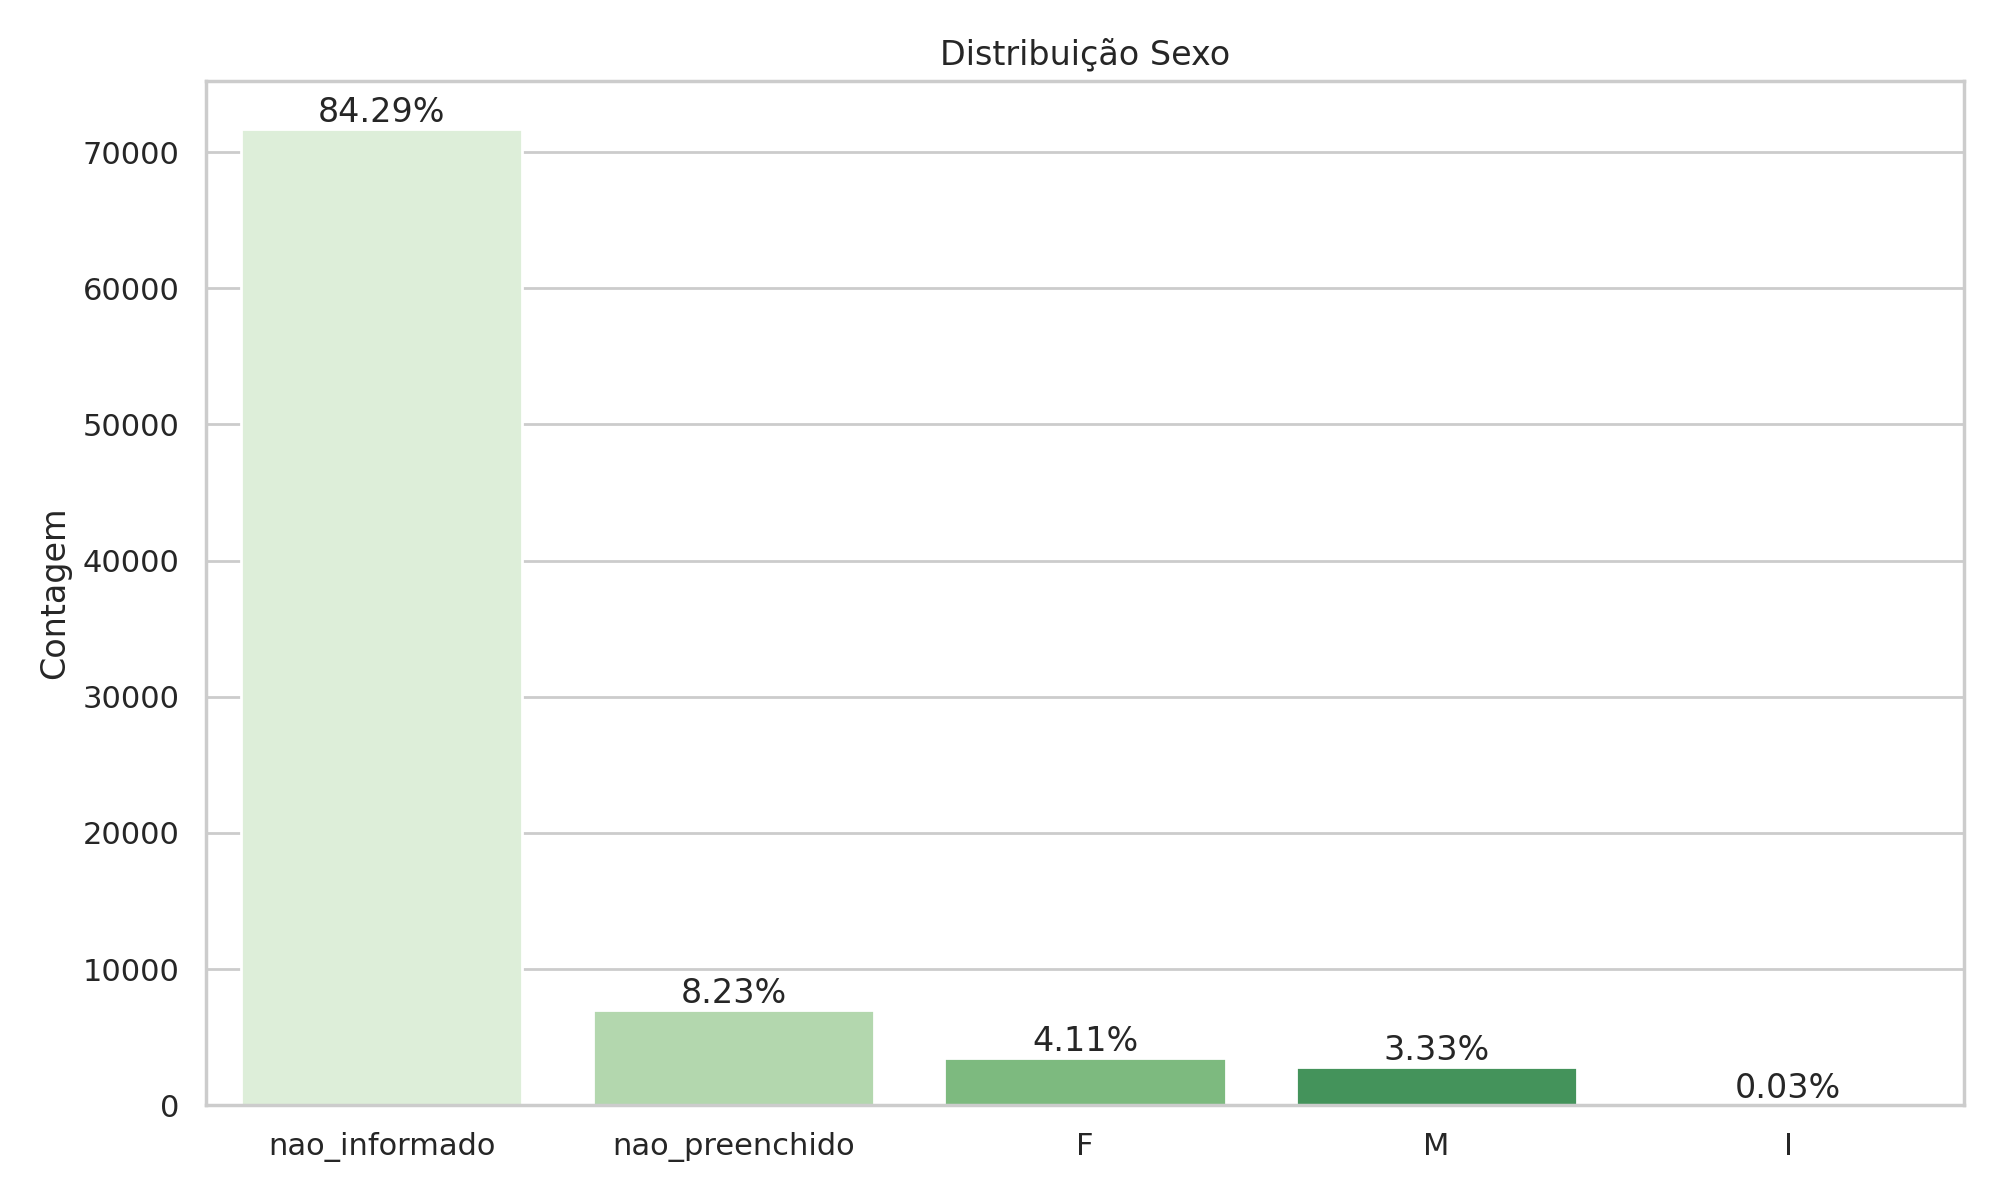

In [195]:
data['sexo'].fillna('nao_preenchido', inplace=True)
data['sexo'] = data['sexo'].replace(' ', 'nao_informado')

plt.figure(figsize=(10, 6))

rede_order = data['sexo'].value_counts().index
ax = sns.countplot(data=data, x='sexo', order=rede_order, palette='Greens')
plt.title('Distribuição Sexo')
plt.xlabel('')
plt.ylabel('Contagem')
#plt.xticks(rotation=90)


total = len(data['sexo'])  
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total)  
    x = p.get_x() + p.get_width() / 2  
    y = p.get_height()  
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [196]:
rp.summary_cat(data['rede'])

Variable    Outcome  Count  Percent
0     rede  Empresa B  42525   50.020
1           Empresa A  42498   49.980

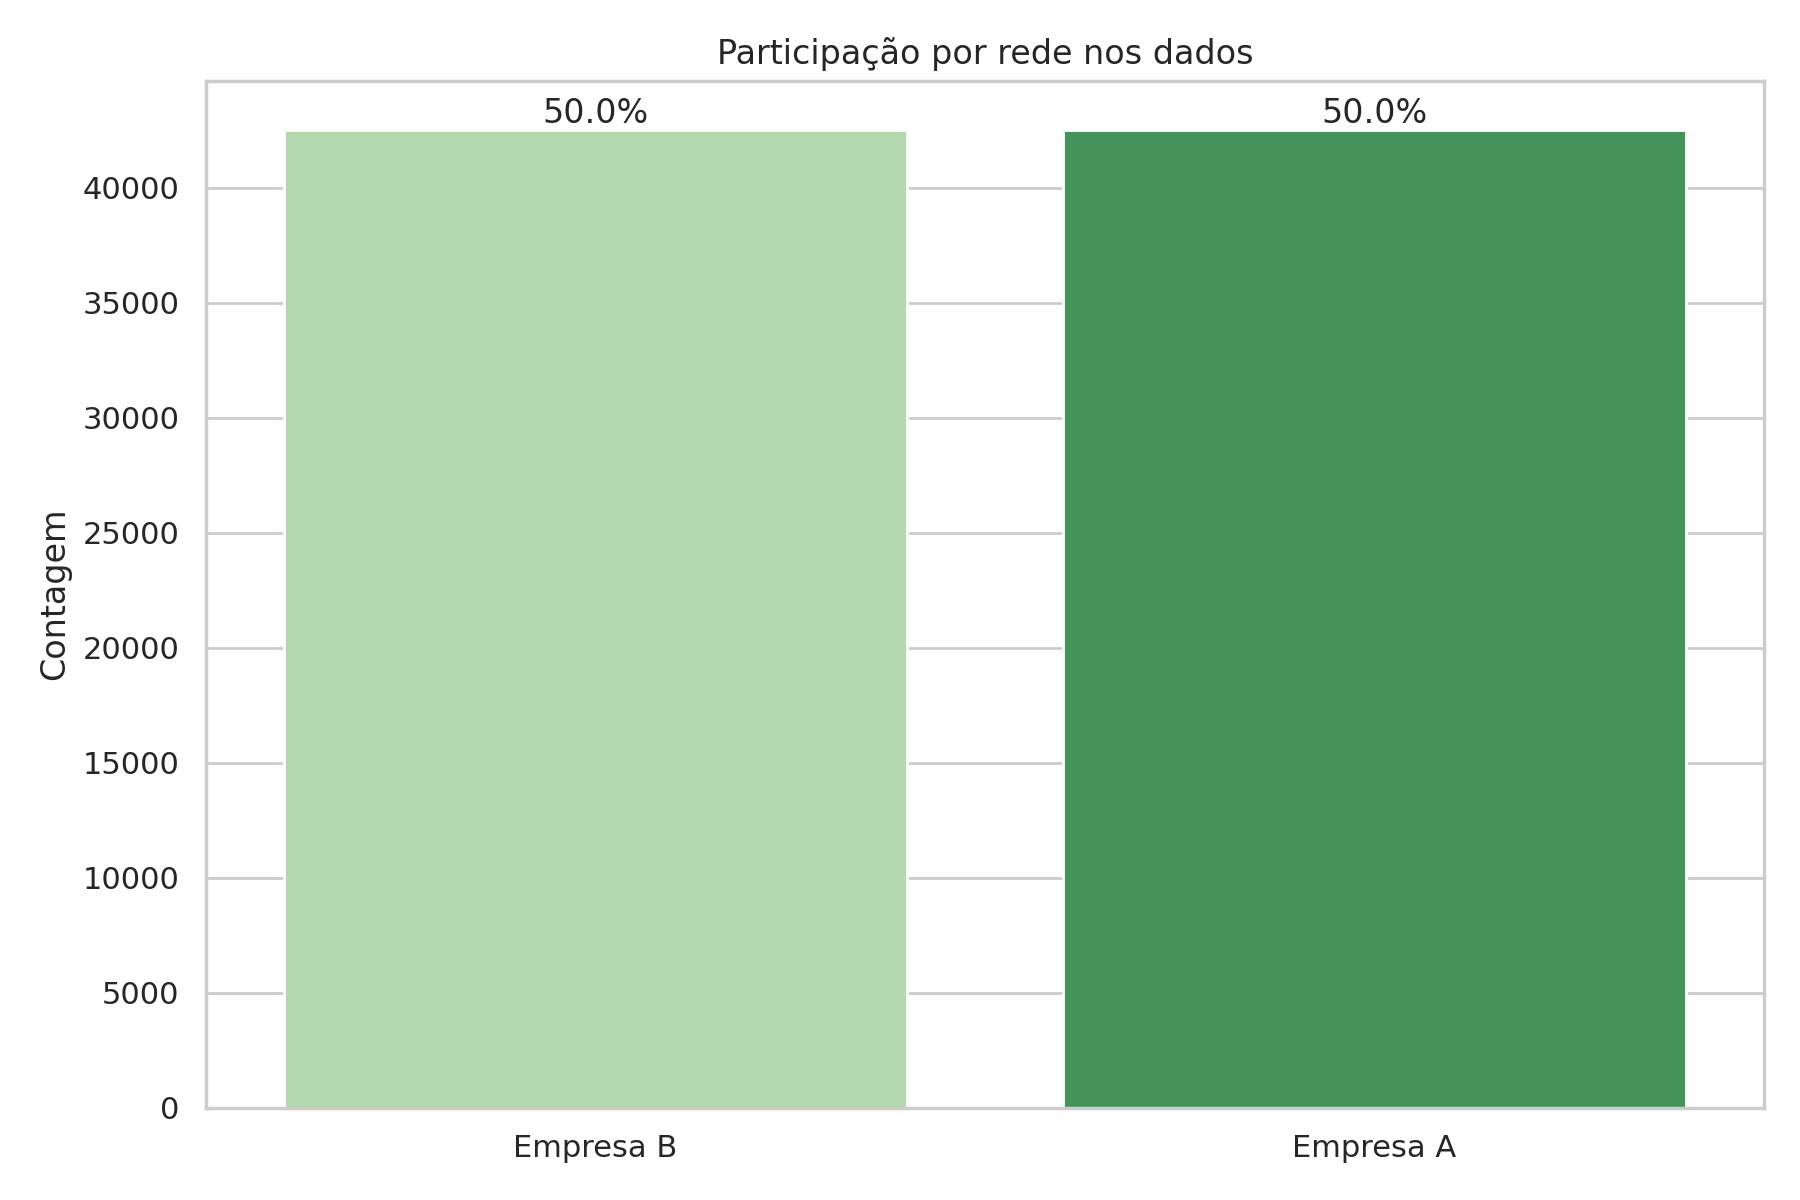

In [197]:
plt.figure(figsize=(9, 6))

rede_order = data['rede'].value_counts().index
ax = sns.countplot(data=data, x='rede', order=rede_order, palette='Greens')
plt.title('Participação por rede nos dados')
plt.xlabel('')
plt.ylabel('Contagem')
#plt.xticks(rotation=90)


total = len(data['rede'])  
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)  
    x = p.get_x() + p.get_width() / 2  
    y = p.get_height()  
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [198]:
rp.summary_cat(data['status_venda'])

Variable                  Outcome  Count  Percent
0  status_venda  Confirmada Parcialmente  42651   50.160
1                             Confirmada  42372   49.840

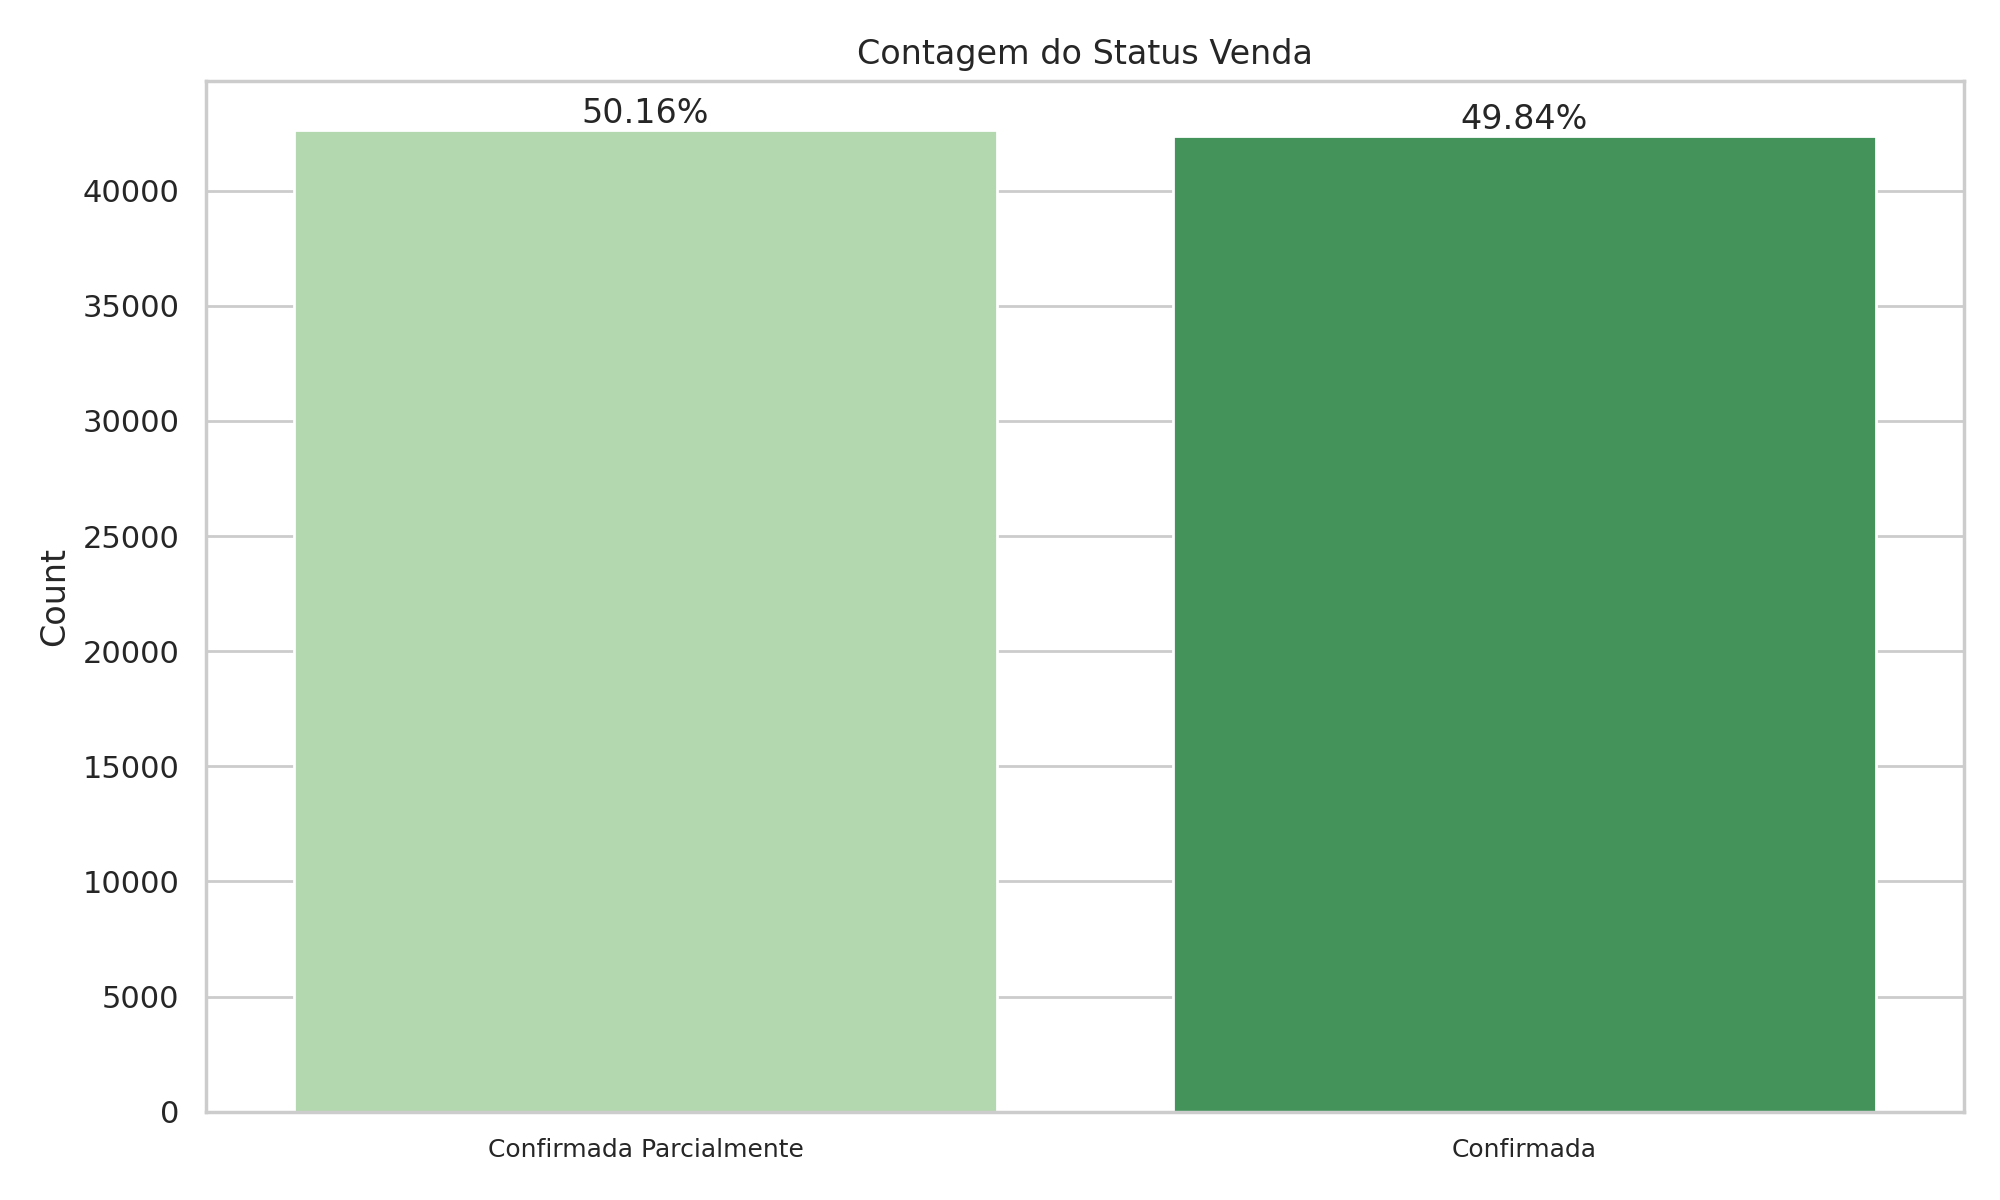

In [199]:
plt.figure(figsize=(10,6))

status_order = data['status_venda'].value_counts().index

ax = sns.countplot(data=data, x='status_venda', order=status_order, palette='Greens')
plt.title('Contagem do Status Venda')
plt.xlabel('')
plt.ylabel('Count')
plt.xticks(fontsize=9)

total = len(data['status_venda']) 
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height() / total)  
    x = p.get_x() + p.get_width() / 2  
    y = p.get_height()  
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.tight_layout()
plt.show()

**DETALHAMENTO.:** `DESCONTO`

In [200]:
# Essa veio sobrando...kkk
data.drop(columns=['Unnamed: 0'], inplace=True)

In [201]:
data.Desconto.describe()

count   85023.000
mean         -inf
std           NaN
min          -inf
25%      -108.585
50%        -0.519
75%        51.114
max       100.000
Name: Desconto, dtype: float64

Claramente temos que resolver umas coisas acima antes de detalhar o Desconto. Para isso, vou garantir apenas valores positivos.

In [202]:
data['Desconto'] = data['Desconto'][data['Desconto'] >= 0]

In [203]:
data.Desconto.describe()

count   42294.000
mean       51.157
std        29.231
min         0.000
25%        25.827
50%        51.376
75%        76.777
max       100.000
Name: Desconto, dtype: float64

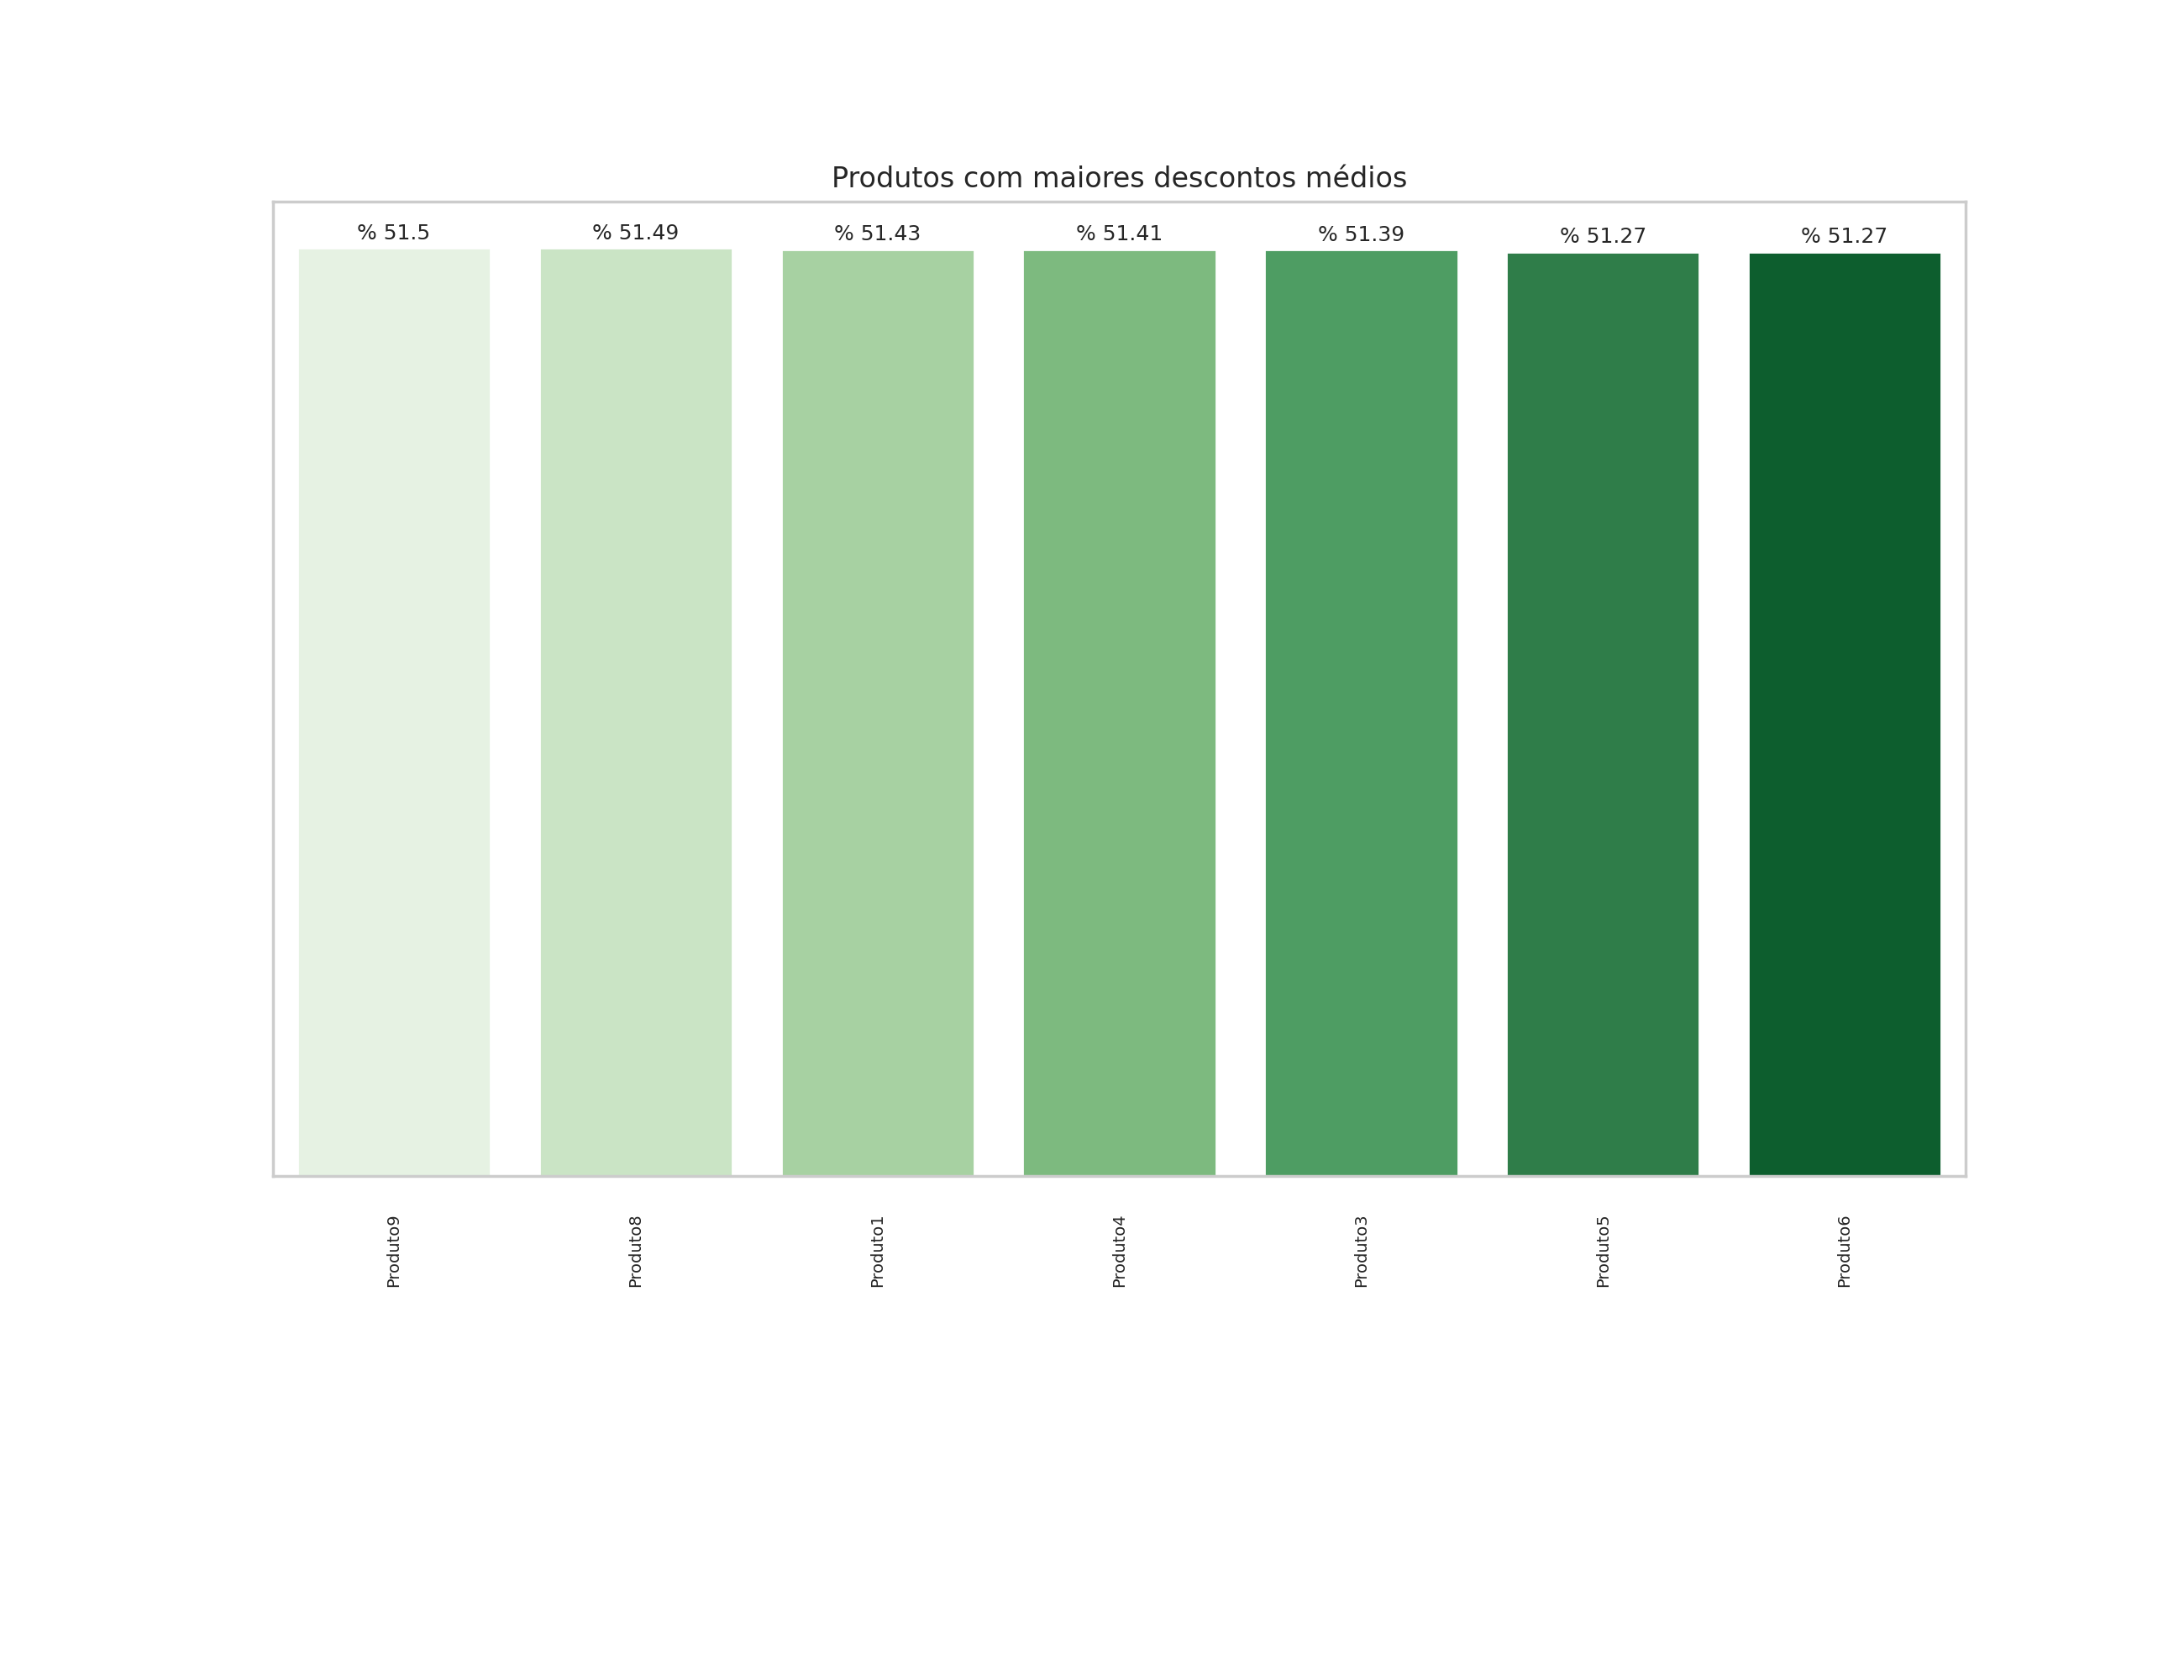

In [204]:
plt.figure(figsize=(13, 10))
sns.barplot(x='produto', y='mean', data=product, palette='Greens')

for index, row in product.iterrows():
    plt.text(index, row['mean'] + 0.5, f'% {round(row["mean"], 2)}', ha='center', fontsize=9)
    
plt.subplots_adjust(bottom=0.3)

plt.xlabel('', fontsize=4)
plt.ylabel('', fontsize=10)
plt.title('Produtos com maiores descontos médios')

plt.yticks([])
plt.xticks(rotation=90, fontsize=7)  
plt.tick_params(axis='x', which='major', pad=10)

plt.show()

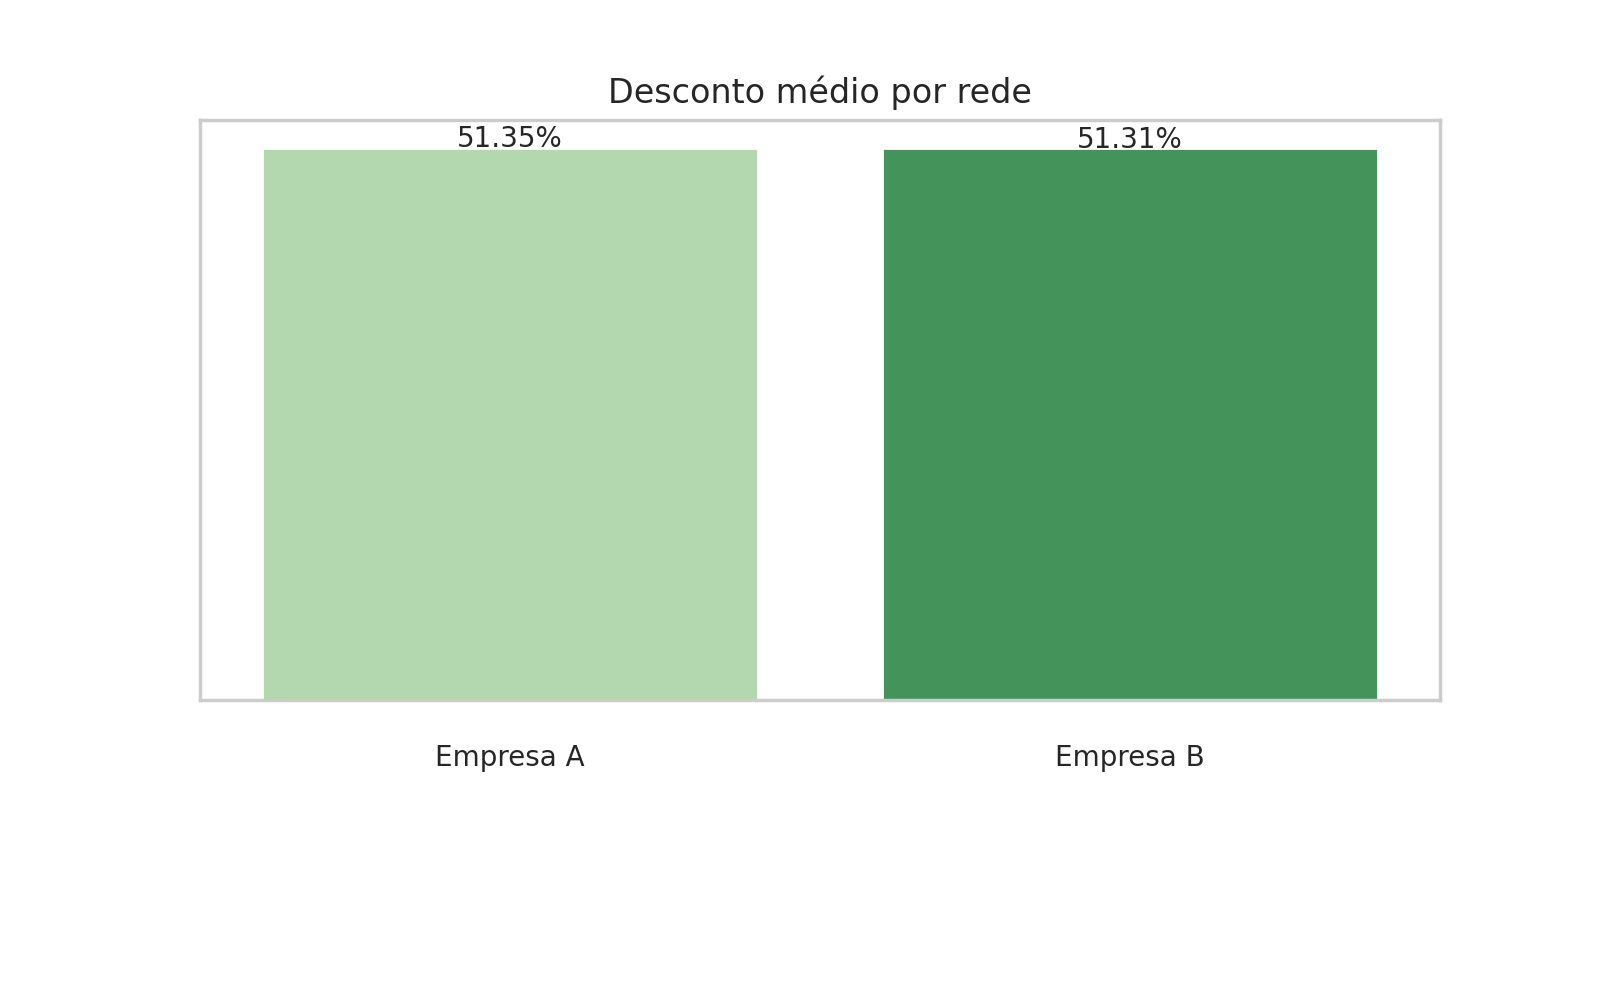

In [205]:
plt.figure(figsize=(8,5))
sns.barplot(x='rede', y='mean', data=redes, palette='Greens')

for index, row in redes.iterrows():
    plt.text(index, row['mean'] + 0.04, f'{round(row["mean"], 2)}%', ha='center', fontsize=10
             )
    
plt.subplots_adjust(bottom=0.3)

plt.xlabel('', fontsize=4)
plt.ylabel('', fontsize=10)
plt.title('Desconto médio por rede')

plt.yticks([])
plt.xticks(fontsize=10)  
plt.tick_params(axis='x', which='major', pad=10)

plt.show()

In [206]:
desired_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

plt.figure(figsize=(10, 8))
sns.barplot(x='dia_da_semana', y='mean', data=dia_semana, palette='Greens', order=desired_order)

for index, row in dia_semana.iterrows():
    # Find the position of the current day in the desired_order
    position = desired_order.index(row['dia_da_semana'])
    plt.text(position, row['mean'] + 0.01, f'{round(row["mean"], 2)}%', ha='center', fontsize=10)

plt.subplots_adjust(bottom=0.3)

plt.xlabel('', fontsize=4)
plt.ylabel('', fontsize=10)
plt.title('Desconto médio por dia da semana')

plt.yticks([])
plt.xticks(range(len(desired_order)), desired_order, rotation=90)  
plt.tick_params(axis='x', which='major', pad=10)

plt.show()

ValueError: Could not interpret input 'mean'

<Figure size 1000x800 with 0 Axes>

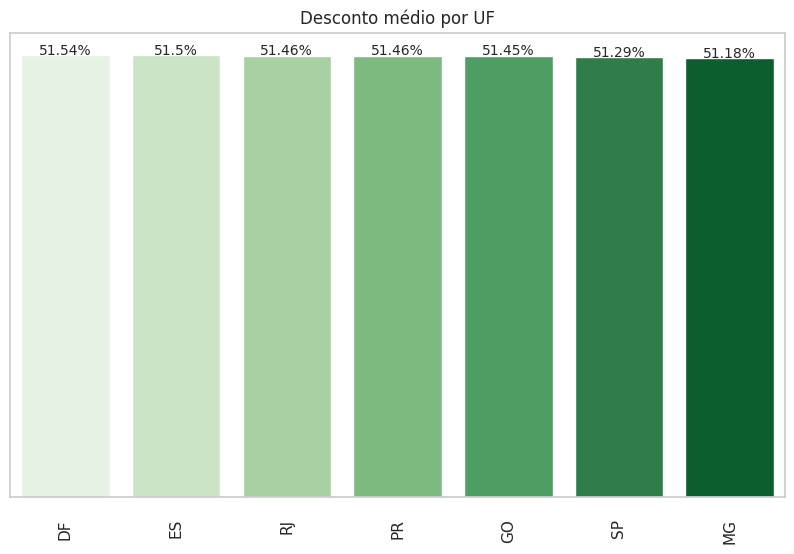

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='uf', y='mean', data=uf_, palette='Greens')

for index, row in uf_.iterrows():
    plt.text(index, row['mean'] + 0.04, f'{round(row["mean"], 2)}%', ha='center', fontsize=10)
    
plt.subplots_adjust(bottom=0.3)

plt.xlabel('', fontsize=4)
plt.ylabel('', fontsize=10)
plt.title('Desconto médio por UF')

plt.yticks([])
plt.xticks(rotation=90)  
plt.tick_params(axis='x', which='major', pad=10) 

plt.show()

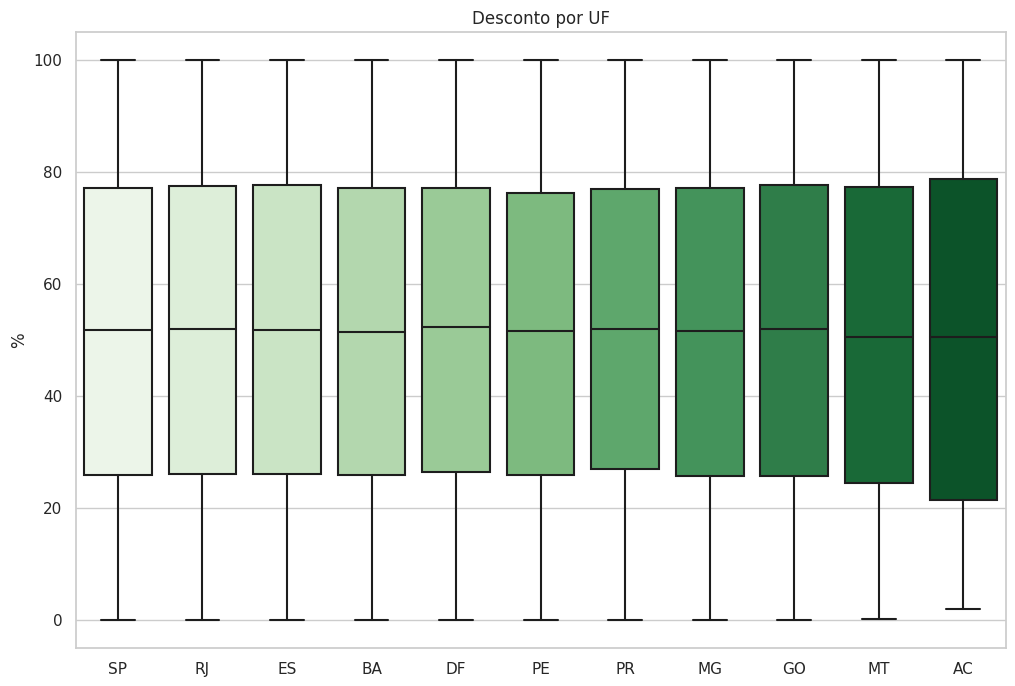

In [ ]:
# PLOTAR BOXPLOT DESCONTO POR UF

uf = data[['uf','Desconto']]
uf.dropna(inplace=True)
uf = uf.query('Desconto != 0')
plt.figure(figsize=(12, 8))
sns.boxplot(data=uf, x='uf', y='Desconto', showfliers=True, palette='Greens')
plt.title('Desconto por UF')
plt.xlabel('')
plt.ylabel('%')  # You may adjust this label based on the actual data

plt.show()

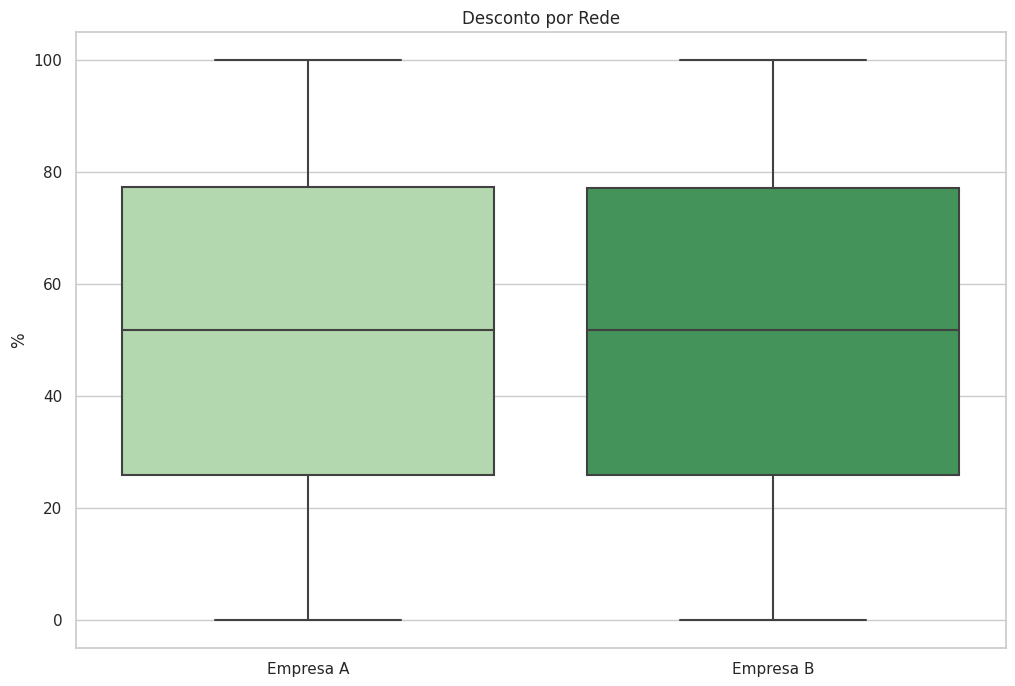

In [ ]:
# PLOTAR BOXPLOT DESCONTO POR REDE
rede = data[['rede','Desconto']]
rede.dropna(inplace=True)
rede = rede.query('Desconto != 0')

plt.figure(figsize=(12, 8))
sns.boxplot(data=rede, x='rede', y='Desconto', showfliers=True, palette='Greens')
plt.title('Desconto por Rede')
plt.xlabel('')
plt.ylabel('%')  

plt.show()

In [ ]:
# Define the order of days of the week
days_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

# Filter and preprocess data
dia_semana = data[['dia_da_semana', 'Desconto']].dropna().query('Desconto != 0')

# Convert 'dia_da_semana' to a categorical variable with specified order
dia_semana['dia_da_semana'] = pd.Categorical(dia_semana['dia_da_semana'], categories=days_order, ordered=True)

# Create the ggplot boxplot
boxplot = (
    pn.ggplot(dia_semana, pn.aes(x='dia_da_semana', y='Desconto'))
    + pn.geom_boxplot(fill='#66c2a5')
    + pn.theme_minimal()
    + pn.labs(title='Desconto por Dia da semana', x='', y='Desconto')  # Adjust labels based on your data
)

# Show the plot (optional)
plt.show()


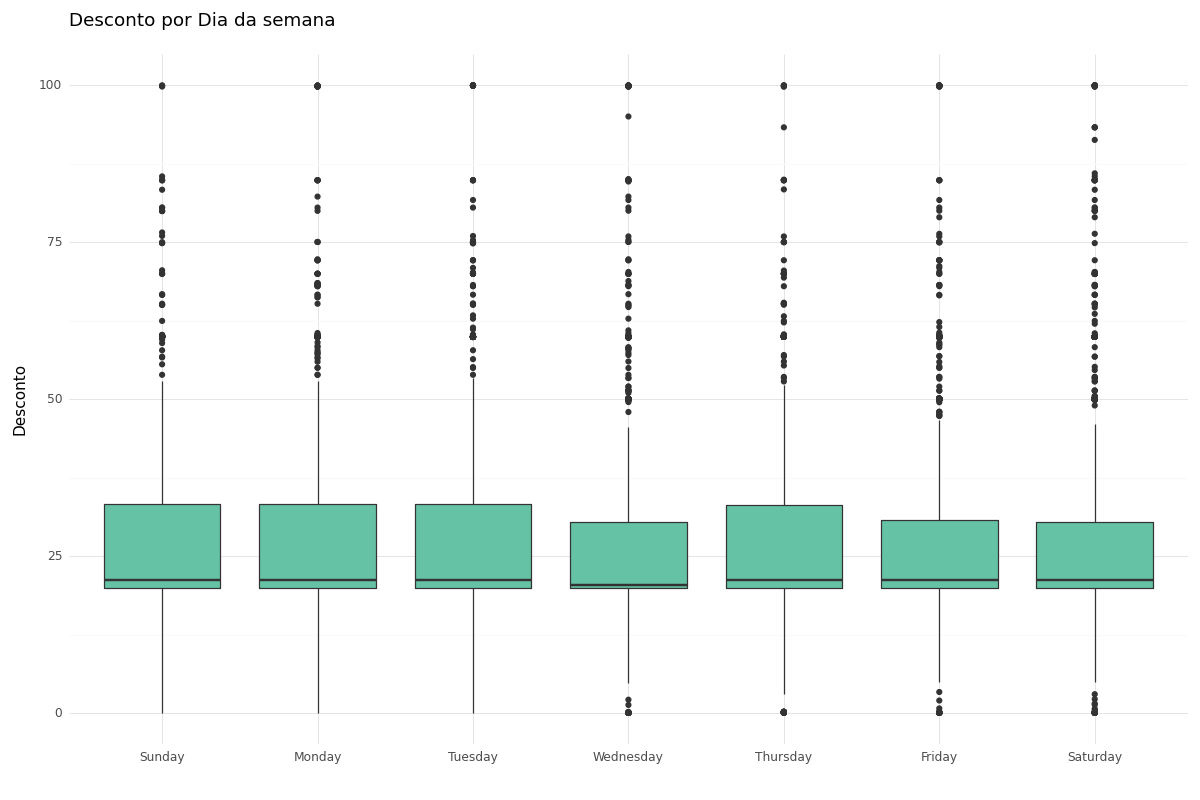

Correlation coefficient: 0.4826554811150993, p-value: 0.01690209088722894


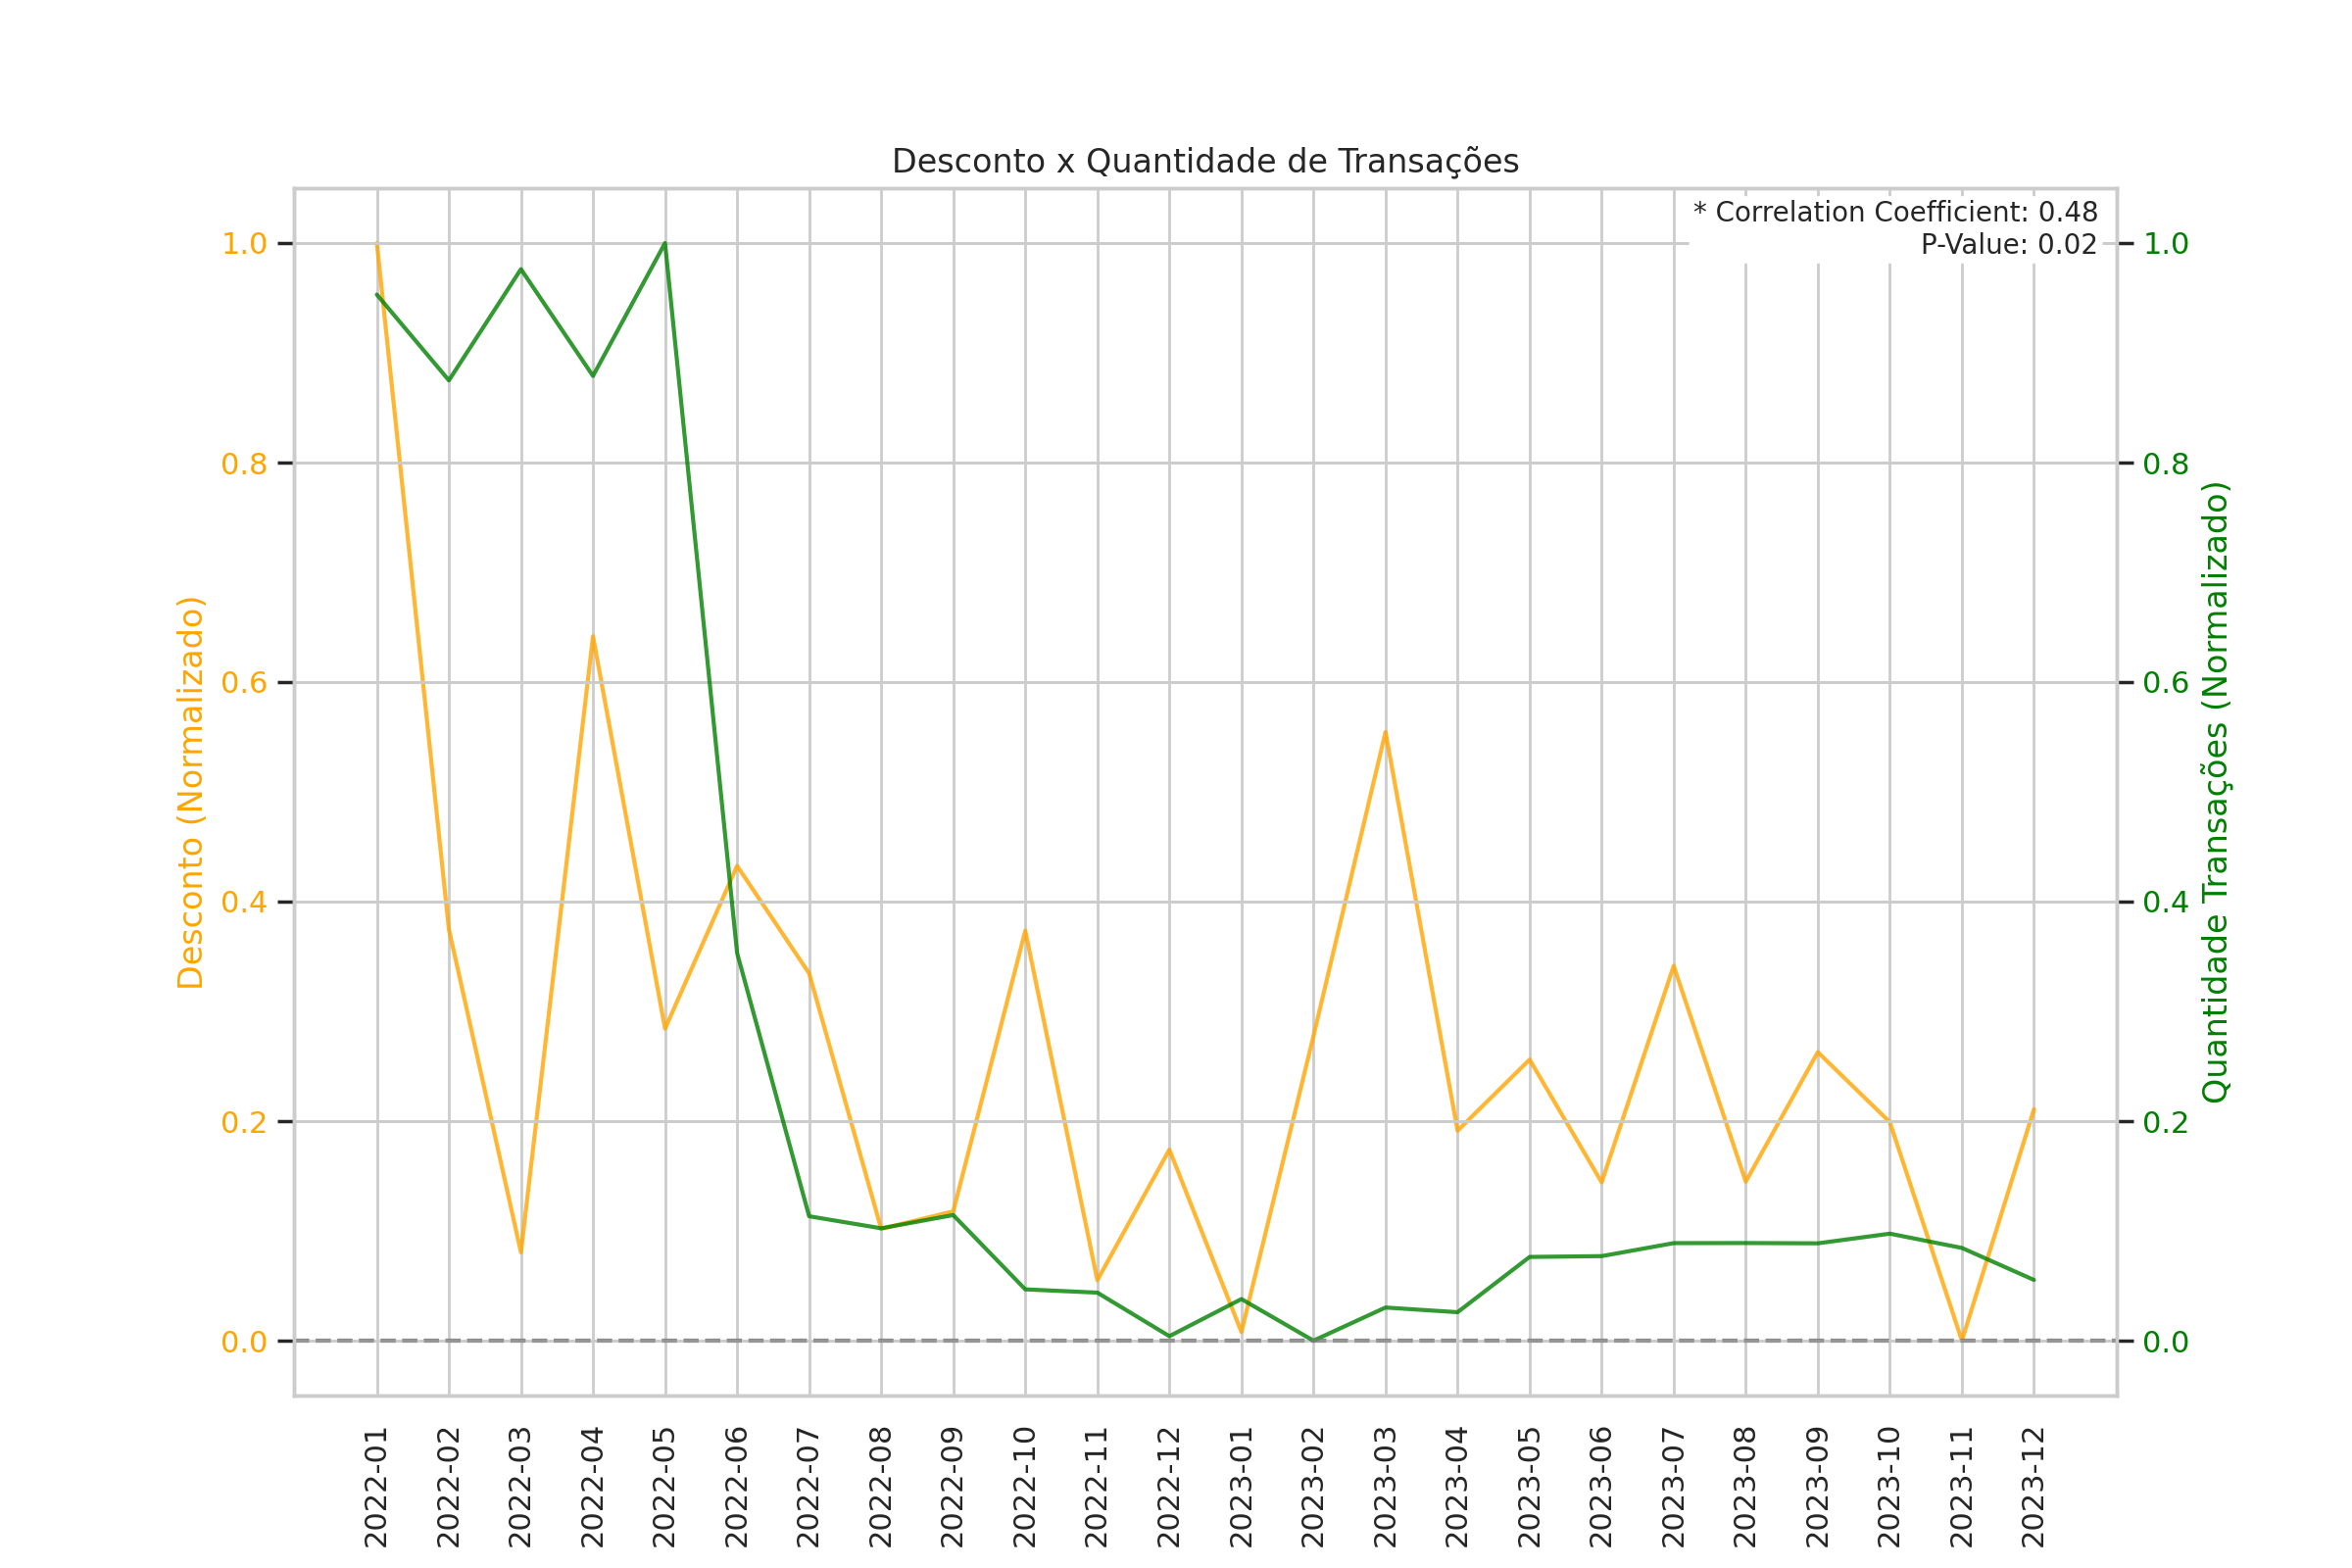

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

ano_mes = data.groupby(['ano_mes'], as_index=False).agg({'Desconto': 'mean', 'codigo_liberacao_venda': 'nunique'})

# Calculate the correlation and p-value
correlation, p_value = pearsonr(ano_mes['Desconto'], ano_mes['codigo_liberacao_venda'])
print(f"Correlation coefficient: {correlation}, p-value: {p_value}")

# Normalize the columns
scaler = MinMaxScaler()
ano_mes[['Desconto', 'codigo_liberacao_venda']] = scaler.fit_transform(ano_mes[['Desconto', 'codigo_liberacao_venda']])

# Create two subplots sharing the same x-axis
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.patch.set_alpha(0)

# Plot the first line with transparency
sns.lineplot(data=ano_mes, x='ano_mes', y='Desconto', color='orange', ax=ax1, alpha=0.8)
ax1.set_ylabel('Desconto (Normalizado)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
plt.xticks(rotation=90)

# Create a second y-axis for the second line
ax2 = ax1.twinx()
sns.lineplot(data=ano_mes, x='ano_mes', y='codigo_liberacao_venda', color='green', ax=ax2, alpha=0.8)
ax2.set_ylabel('Quantidade Transações (Normalizado)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Adding horizontal lines representing zero Desconto value & 0 transactions
ax1.axhline(y=0, linestyle="--", color='gray', alpha=0.7)
ax2.axhline(y=0, linestyle="--", color='gray', alpha=0.7)

# Determine if the correlation is statistically significant
is_sig = p_value < 0.05
star = '*' if is_sig else ''

# Annotate correlation value and significance level
annotation_text = f'{star} Correlation Coefficient: {correlation:.2f}\nP-Value: {p_value:.2f}'
plt.text(0.99, 0.99, annotation_text, ha='right', va='top', transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.1'))

# Set x-axis labels and title
ax1.set_xlabel('')
ax1.set_title('Desconto x Quantidade de Transações')

# Display fig
plt.show()

Correlation coefficient: -0.014194276930663254, p-value: 0.9475144685803115


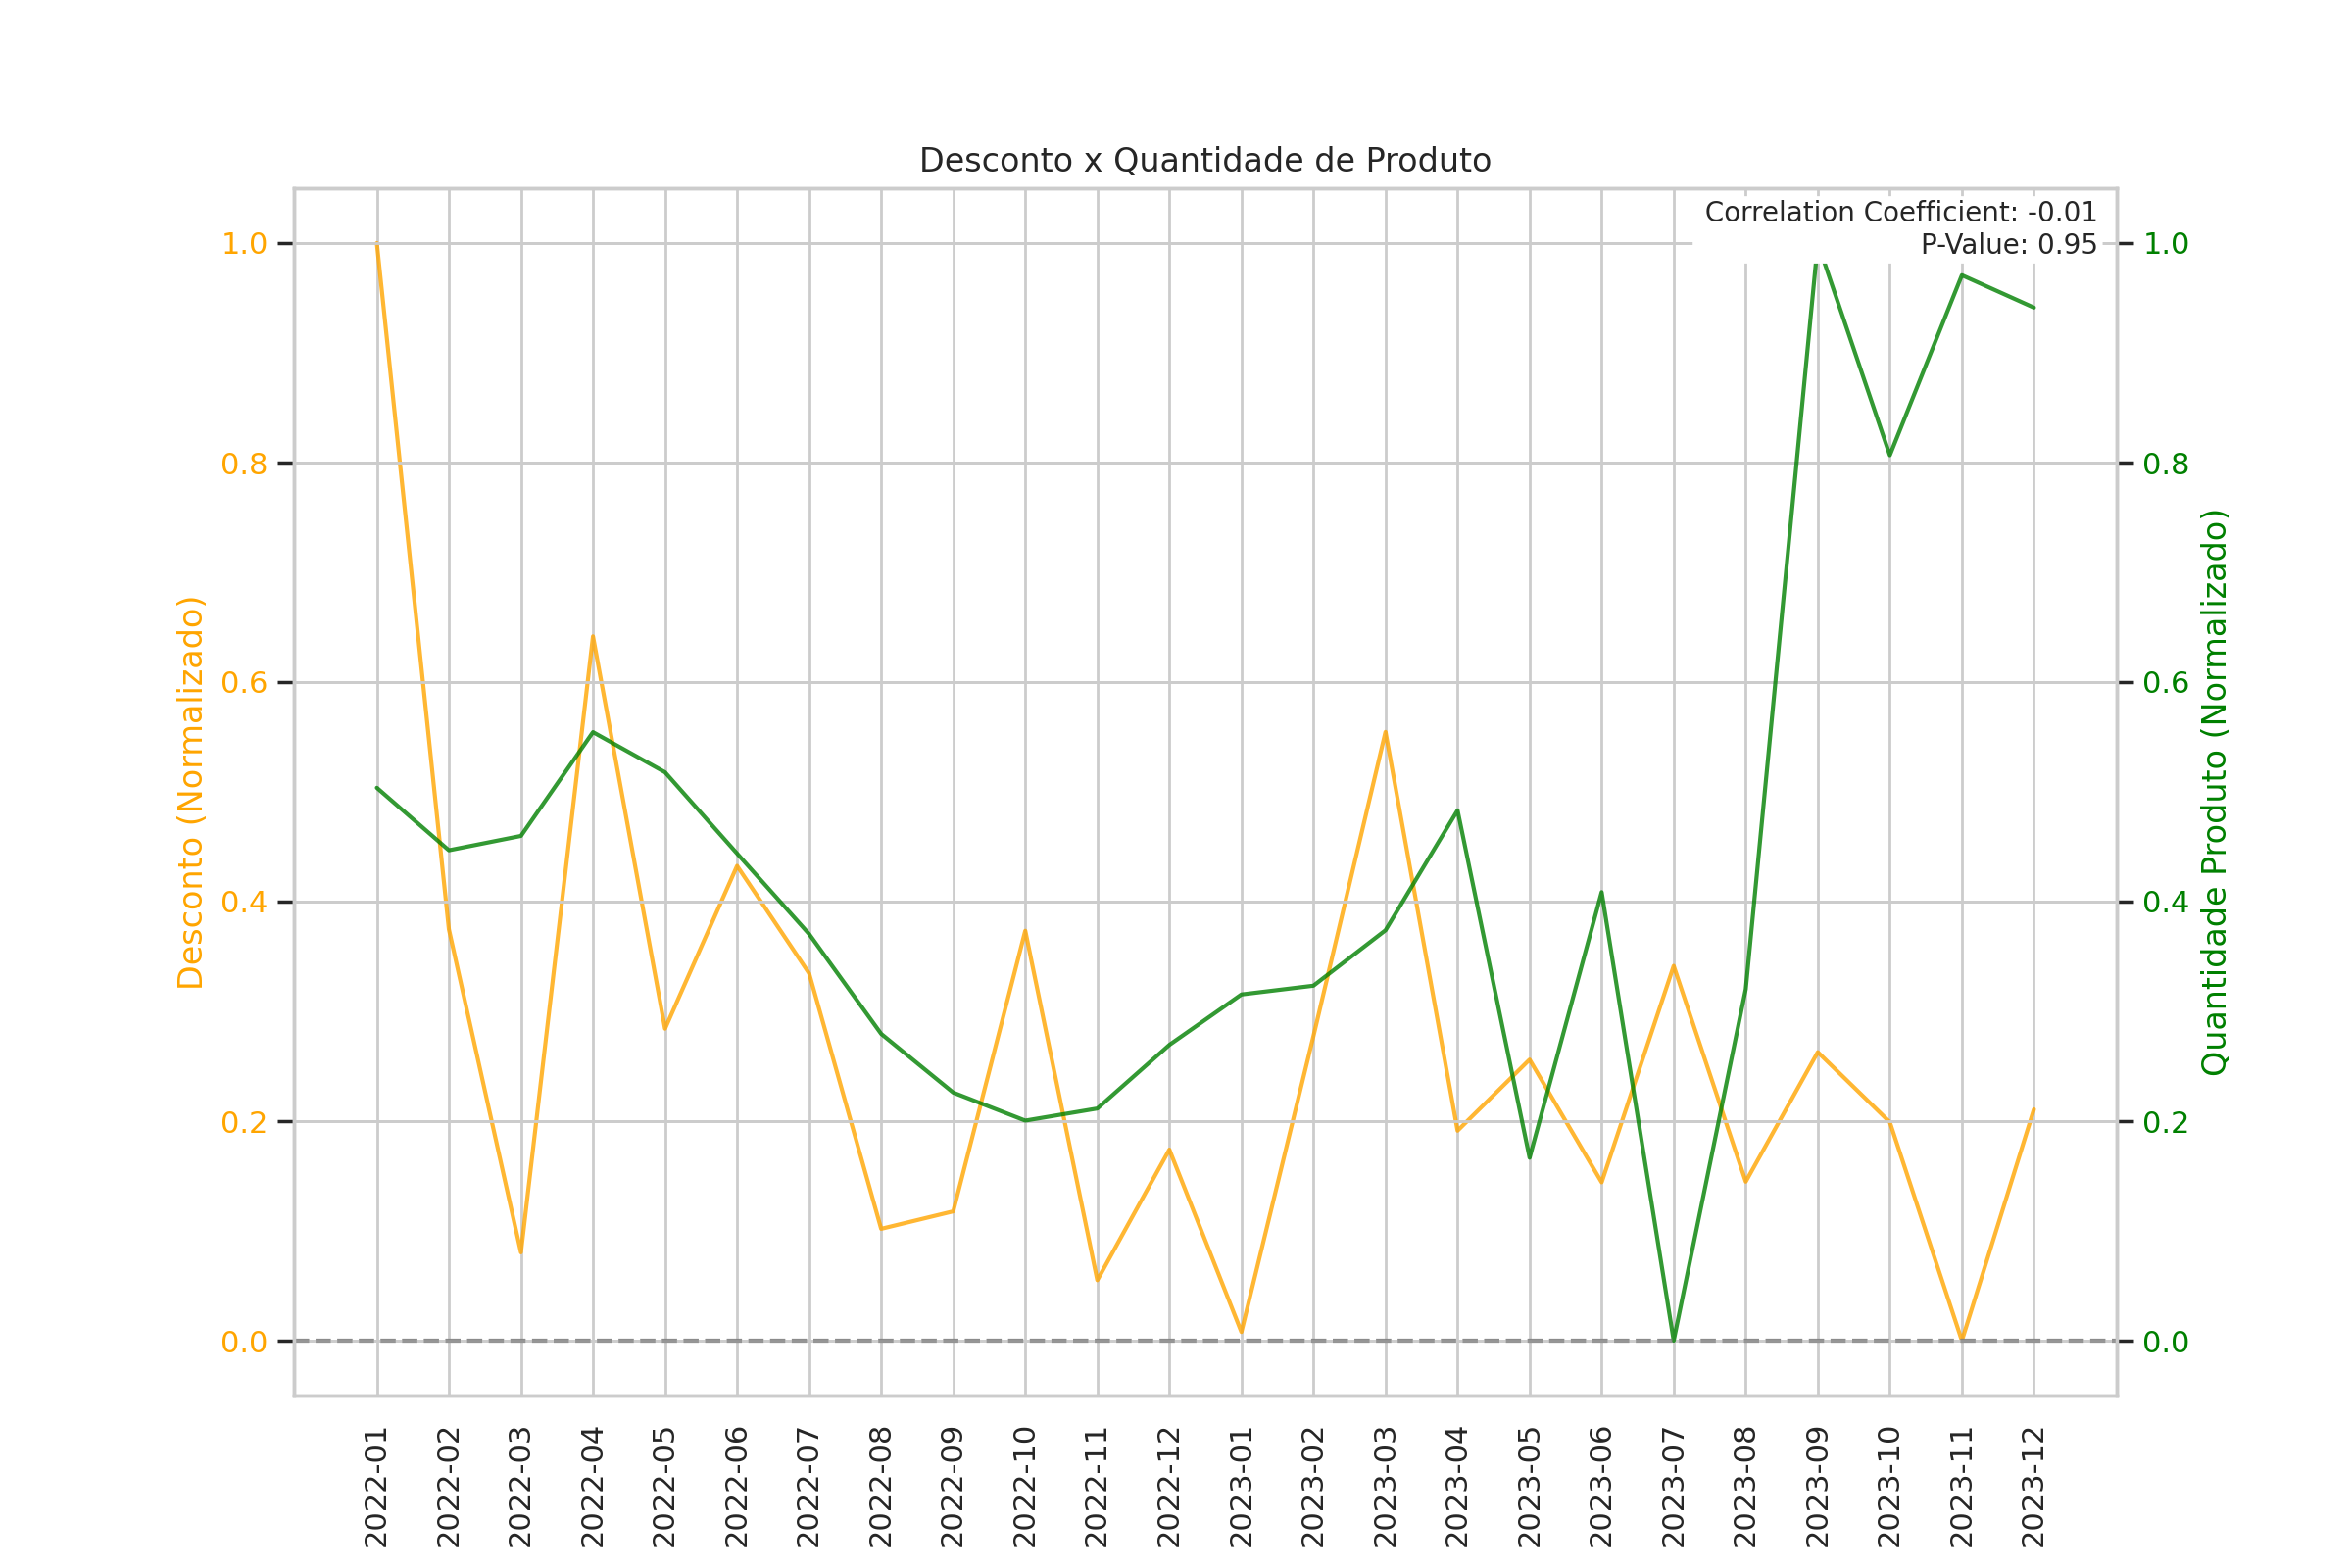

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

ano_mes = data.groupby(['ano_mes'], as_index=False).agg({'Desconto': 'mean', 'qtde_produto': 'mean'})

# Calculate the correlation and p-value
correlation, p_value = pearsonr(ano_mes['Desconto'], ano_mes['qtde_produto'])
print(f"Correlation coefficient: {correlation}, p-value: {p_value}")

# Normalize the columns
scaler = MinMaxScaler()
ano_mes[['Desconto', 'qtde_produto']] = scaler.fit_transform(ano_mes[['Desconto', 'qtde_produto']])

# Create two subplots sharing the same x-axis
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.patch.set_alpha(0)

# Plot the first line with transparency
sns.lineplot(data=ano_mes, x='ano_mes', y='Desconto', color='orange', ax=ax1, alpha=0.8)
ax1.set_ylabel('Desconto (Normalizado)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
plt.xticks(rotation=90)

# Create a second y-axis for the second line
ax2 = ax1.twinx()
sns.lineplot(data=ano_mes, x='ano_mes', y='qtde_produto', color='green', ax=ax2, alpha=0.8)
ax2.set_ylabel('Quantidade Produto (Normalizado)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Adding horizontal lines representing zero Desconto value & 0 transactions
ax1.axhline(y=0, linestyle="--", color='gray', alpha=0.7)
ax2.axhline(y=0, linestyle="--", color='gray', alpha=0.7)

# Determine if the correlation is statistically significant
is_sig = p_value < 0.05
star = '*' if is_sig else ''

# Annotate correlation value and significance level
annotation_text = f'{star} Correlation Coefficient: {correlation:.2f}\nP-Value: {p_value:.2f}'
plt.text(0.99, 0.99, annotation_text, ha='right', va='top', transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.1'))

# Set x-axis labels and title
ax1.set_xlabel('')
ax1.set_title('Desconto x Quantidade de Produto')

# Display fig
plt.show()

Correlation coefficient: -0.0651608059002341, p-value: 0.7622695843357166


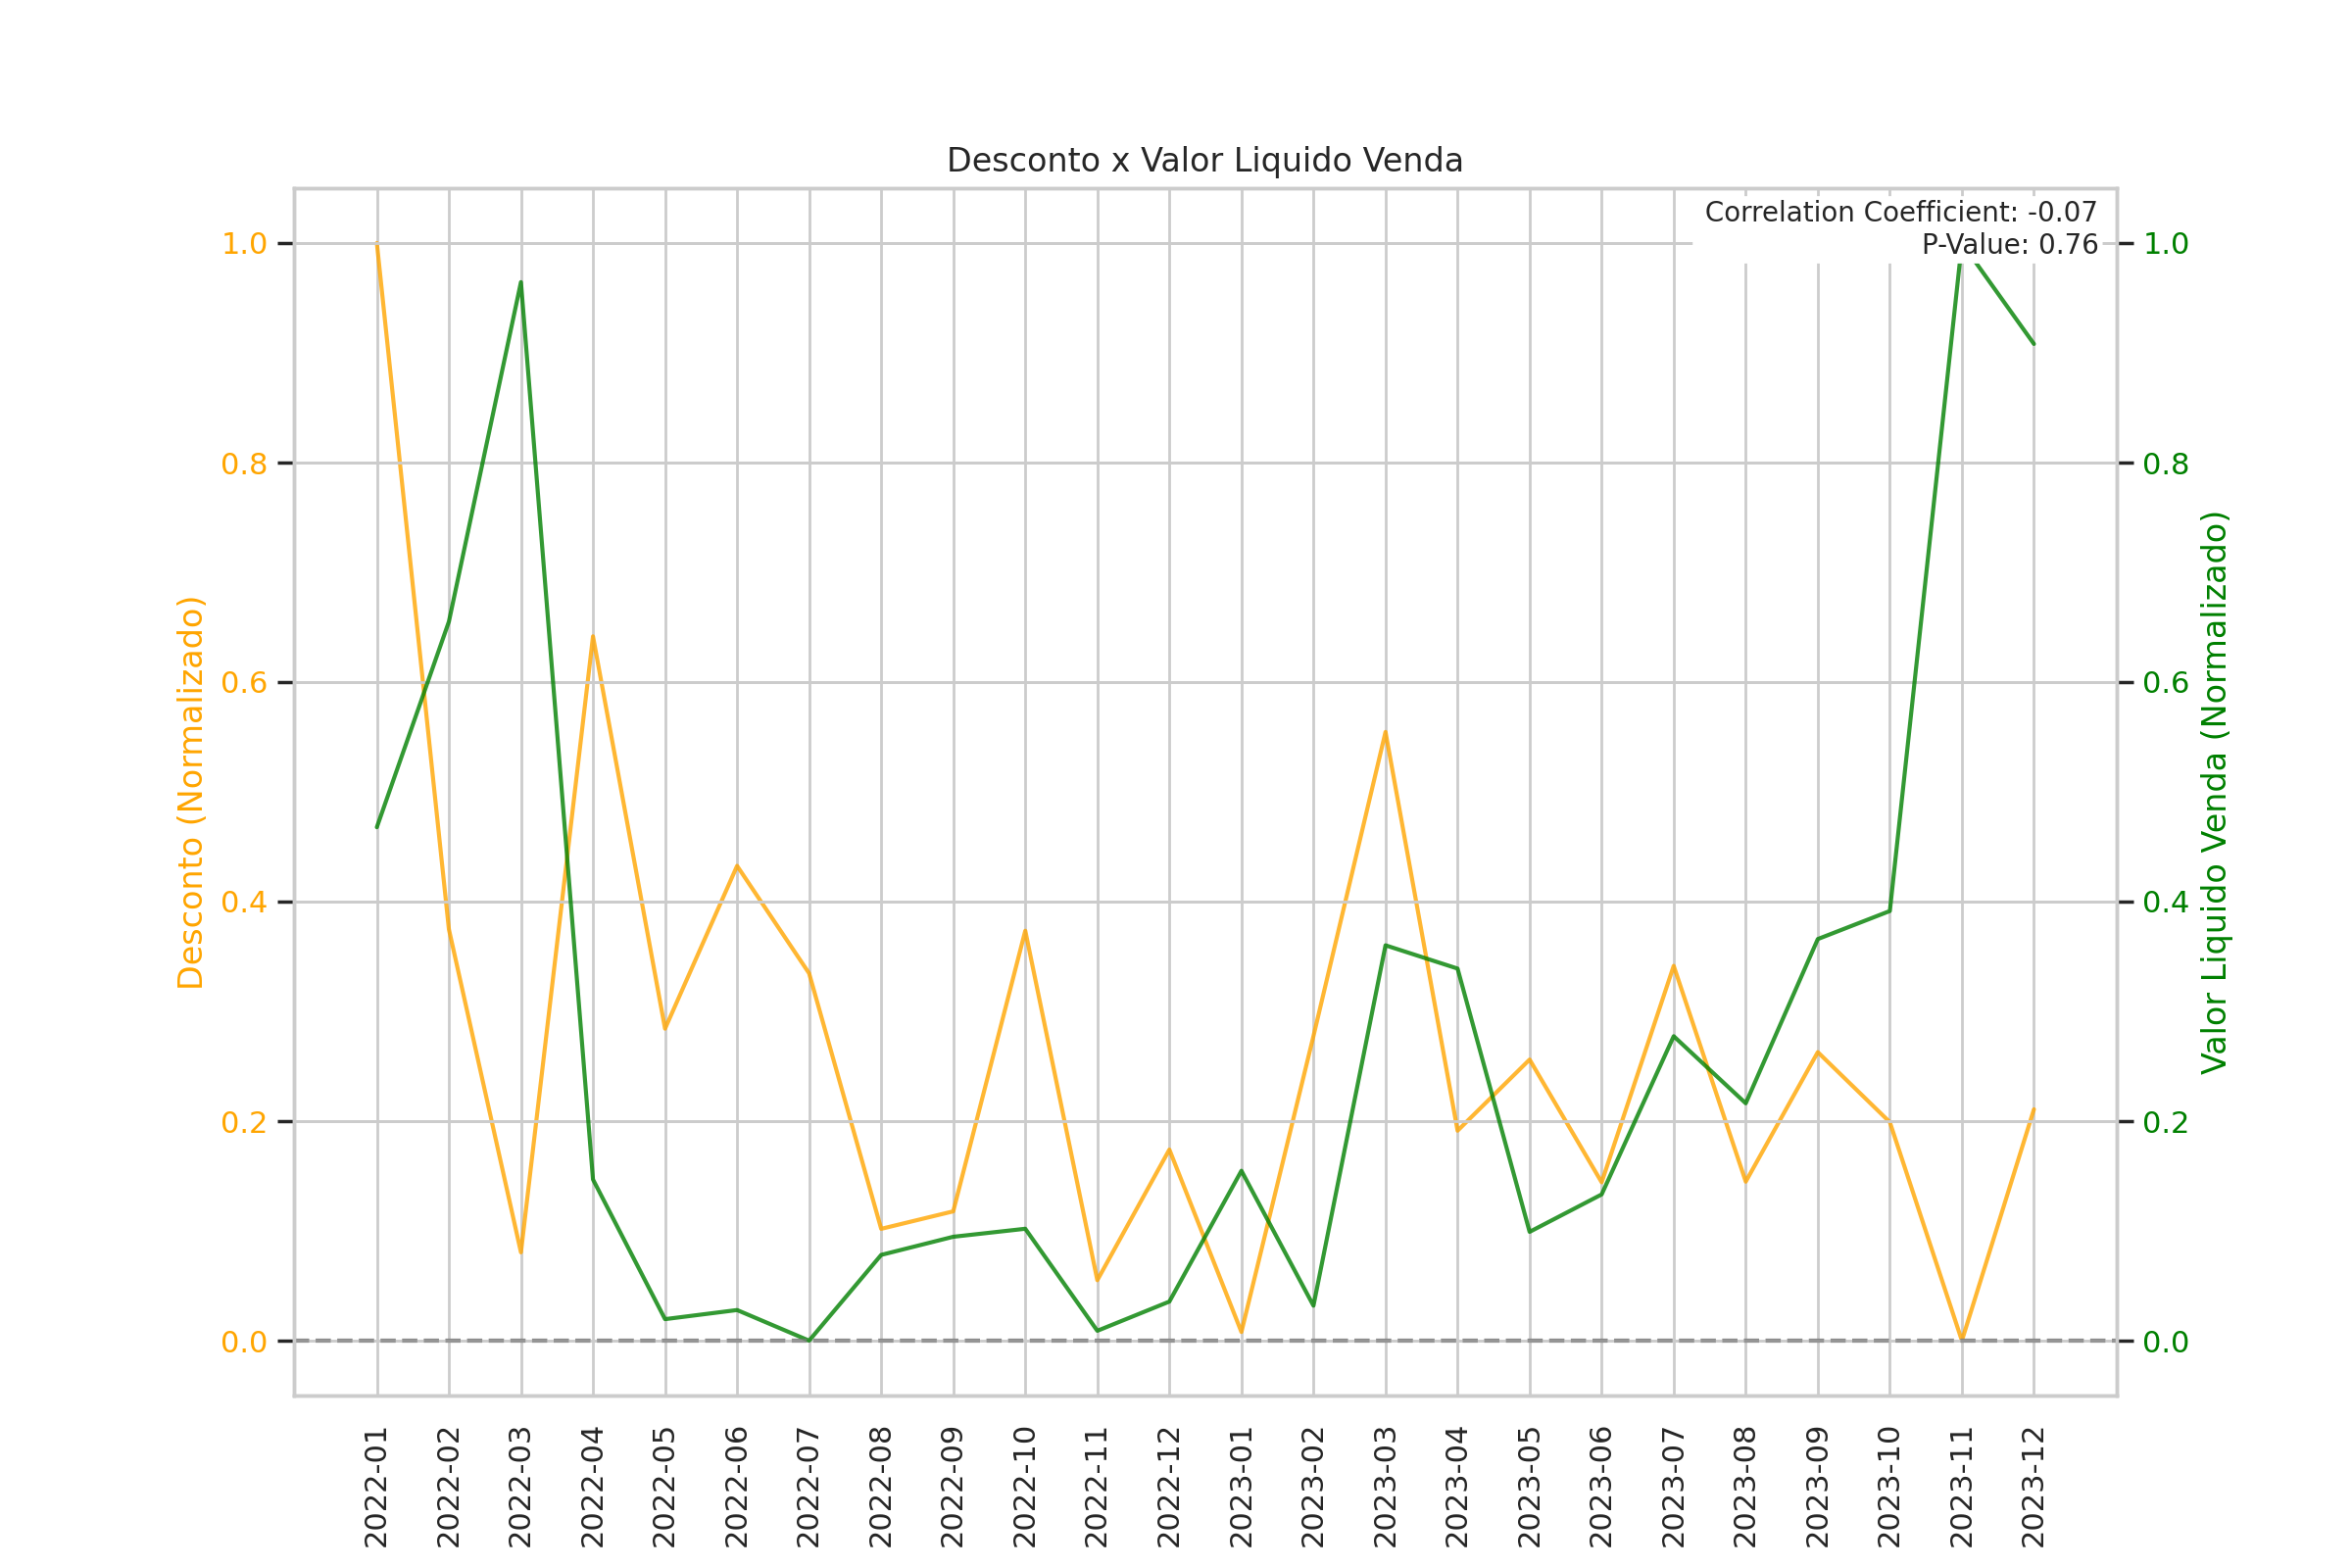

In [ ]:

from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr

ano_mes = data.groupby(['ano_mes'], as_index=False).agg({'Desconto': 'mean', 'valor_liquido_venda': 'mean'})

# Calculate the correlation and p-value
correlation, p_value = pearsonr(ano_mes['Desconto'], ano_mes['valor_liquido_venda'])
print(f"Correlation coefficient: {correlation}, p-value: {p_value}")

# Normalize the columns
scaler = MinMaxScaler()
ano_mes[['Desconto', 'valor_liquido_venda']] = scaler.fit_transform(ano_mes[['Desconto', 'valor_liquido_venda']])

# Create two subplots sharing the same x-axis
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.patch.set_alpha(0)

# Plot the first line with transparency
sns.lineplot(data=ano_mes, x='ano_mes', y='Desconto', color='orange', ax=ax1, alpha=0.8)
ax1.set_ylabel('Desconto (Normalizado)', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
plt.xticks(rotation=90)

# Create a second y-axis for the second line
ax2 = ax1.twinx()
sns.lineplot(data=ano_mes, x='ano_mes', y='valor_liquido_venda', color='green', ax=ax2, alpha=0.8)
ax2.set_ylabel('Valor Liquido Venda (Normalizado)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Adding horizontal lines representing zero Desconto value & 0 transactions
ax1.axhline(y=0, linestyle="--", color='gray', alpha=0.7)
ax2.axhline(y=0, linestyle="--", color='gray', alpha=0.7)

# Determine if the correlation is statistically significant
is_sig = p_value < 0.05
star = '*' if is_sig else ''

# Annotate correlation value and significance level
annotation_text = f'{star} Correlation Coefficient: {correlation:.2f}\nP-Value: {p_value:.2f}'
plt.text(0.99, 0.99, annotation_text, ha='right', va='top', transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.1'))

# Set x-axis labels and title
ax1.set_xlabel('')
ax1.set_title('Desconto x Valor Liquido Venda')

# Display fig
plt.show()

**Conclusões**

Aqui você anota em pontos as conclusões que até aqui você veio tirando. Ao longo da análise, abaixo de cada ponto, faça pequenas observações que servirão de base para esse final.

**Próximas etapas**

*Aqui, caso necessário, detalhe as próximas etapas*